In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt

In [2]:
data1 = pd.read_csv('monthlyCSV.csv', header = 0, index_col = 0)
data1 = data1.drop(range(1935, 2005))
npdata1 = data1.to_numpy()
g = []
for i in npdata1:
    for j in i:
        if not np.isnan(j):
            g.append(j)
min_y = min(g)
max_y = max(g)
for i in range(len(g)):
    g[i] -= min_y
    g[i] /= max_y - min_y
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(g, model = 'additive', period = 12)
trend = []
for i in decomp.trend:
    if not np.isnan(i):
        trend.append(i)

In [3]:
data2 = pd.read_csv('monthlyCSV.csv', header = 0, index_col = 0)
data2 = data2.drop(range(1935, 1975))
npdata2 = data2.to_numpy()
g2 = []
for i in npdata2:
    for j in i:
        if not np.isnan(j):
            g2.append(j)
min_y = min(g2)
max_y = max(g2)
for i in range(len(g2)):
    g2[i] -= min_y
    g2[i] /= max_y - min_y
prev_10 = []
prev_20 = []
prev_30 = []
i = 0
while (i < len(g2)-360):
    prev_10.append((sum(g2[i+240:i+360])/120))
    prev_20.append((sum(g2[i+120:i+240])/120))
    prev_30.append((sum(g2[i+240:i+360])/120))
    i += 1

In [4]:
def create_inout_sequences(input_data, tw = 48):
    global prev_10, prev_20, prev_30
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw-tw):
        train_seq = [prev_10[i], prev_20[i], prev_30[i]]
        train_seq.extend(input_data[i:i+tw])
        train_label = input_data[i+tw:i+tw+tw]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
train_inout_seq = create_inout_sequences(trend)

In [5]:
import torch.nn as nn
from torch.nn import Sequential
import torch as tr
tr.manual_seed(0)

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size = input_size,
            hidden_size = 128, #number of features coming out of the LSTM layer
            num_layers = 2, #number of LSTM layers
            batch_first = True,
            dropout = 0.2
            
        )
        self.out = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(1),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(1),
            nn.ReLU(),
            
            nn.Linear(32,input_size-3),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None) #initial h and c is 0
        out = self.out(r_out)
        return out
model = RNN(180)
loss_function = nn.MSELoss()
op = tr.optim.Adam(model.parameters(), lr=0.0001)
#op_2 = tr.optim.Adam(model.parameters(), lr = 0.0001)

In [72]:
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
model = model.to(device) #looks for gpu if gpu is available and puts model into gpu for computation
repeats = 1000 #decides how many times each piece of data is ran through the model
train_loss = []
test_loss = []
t_loss = 0
for repeat in range(repeats):
    model.train() #mode change into training
    #if repeats > 200:
        #op = op_2
    for seq, labels in train_inout_seq[:-1]: #enumerate returns data into data and index into index_train, for loop is a single test of all info
        #train_dataLoader includes 2 parts from the return, one is the target, other is data
        seq = [seq]
        labels = [labels]
        x = tr.Tensor(seq) #input
        y = tr.Tensor(labels) #label or target
        op.zero_grad() #clear previous derivative, otherwise would cause error
        pred = model(tr.unsqueeze(x, dim = 1)) #give the information (x) into the model, pred is the prediction of the model

        loss = loss_function(pred,tr.unsqueeze(y, 1)) # Compares prediction with actual target with cross entropy
        loss.backward() #pass the loss back (back propagation)
        op.step() #with the loss, can optimize the model
        train_loss.append(loss)

    seq, labels = train_inout_seq[-1]
    seq = [seq]
    labels = [labels]
    x = tr.Tensor(seq)
    y = tr.Tensor(labels)
    op.zero_grad()
    pred = model(tr.unsqueeze(x, dim = 1))
    t_loss = loss_function(pred, tr.unsqueeze(y, 1))
    test_loss.append(t_loss)

    print ("Epoch %d Loss: %f Test Loss: %f"%(repeat, loss, t_loss))



#% is a replacement, letter after decides format

Epoch 0 Loss: 0.057770 Test Loss: 0.057553
Epoch 1 Loss: 0.046582 Test Loss: 0.046378
Epoch 2 Loss: 0.038968 Test Loss: 0.038903
Epoch 3 Loss: 0.033133 Test Loss: 0.033011
Epoch 4 Loss: 0.028631 Test Loss: 0.028562
Epoch 5 Loss: 0.025134 Test Loss: 0.024922
Epoch 6 Loss: 0.022491 Test Loss: 0.022315
Epoch 7 Loss: 0.020495 Test Loss: 0.020289
Epoch 8 Loss: 0.018974 Test Loss: 0.018771
Epoch 9 Loss: 0.017798 Test Loss: 0.017518
Epoch 10 Loss: 0.016914 Test Loss: 0.016661
Epoch 11 Loss: 0.016203 Test Loss: 0.015913
Epoch 12 Loss: 0.015628 Test Loss: 0.015346
Epoch 13 Loss: 0.015152 Test Loss: 0.014868
Epoch 14 Loss: 0.014810 Test Loss: 0.014503
Epoch 15 Loss: 0.014540 Test Loss: 0.014268
Epoch 16 Loss: 0.014363 Test Loss: 0.014081
Epoch 17 Loss: 0.014074 Test Loss: 0.013775
Epoch 18 Loss: 0.013905 Test Loss: 0.013610
Epoch 19 Loss: 0.013874 Test Loss: 0.013442
Epoch 20 Loss: 0.013675 Test Loss: 0.013399
Epoch 21 Loss: 0.013591 Test Loss: 0.013272
Epoch 22 Loss: 0.013496 Test Loss: 0.01322

Epoch 185 Loss: 0.000805 Test Loss: 0.001166
Epoch 186 Loss: 0.000472 Test Loss: 0.000684
Epoch 187 Loss: 0.000533 Test Loss: 0.001296
Epoch 188 Loss: 0.000463 Test Loss: 0.000661
Epoch 189 Loss: 0.000701 Test Loss: 0.000983
Epoch 190 Loss: 0.000400 Test Loss: 0.000776
Epoch 191 Loss: 0.000668 Test Loss: 0.001055
Epoch 192 Loss: 0.000472 Test Loss: 0.001658
Epoch 193 Loss: 0.001233 Test Loss: 0.000822
Epoch 194 Loss: 0.000367 Test Loss: 0.000765
Epoch 195 Loss: 0.000714 Test Loss: 0.002522
Epoch 196 Loss: 0.000358 Test Loss: 0.000769
Epoch 197 Loss: 0.000580 Test Loss: 0.001169
Epoch 198 Loss: 0.000509 Test Loss: 0.000781
Epoch 199 Loss: 0.000589 Test Loss: 0.001163
Epoch 200 Loss: 0.000567 Test Loss: 0.000951
Epoch 201 Loss: 0.000714 Test Loss: 0.001084
Epoch 202 Loss: 0.000457 Test Loss: 0.001689
Epoch 203 Loss: 0.000596 Test Loss: 0.000980
Epoch 204 Loss: 0.000857 Test Loss: 0.000734
Epoch 205 Loss: 0.000596 Test Loss: 0.000900
Epoch 206 Loss: 0.000383 Test Loss: 0.000636
Epoch 207 

Epoch 368 Loss: 0.000412 Test Loss: 0.001510
Epoch 369 Loss: 0.000266 Test Loss: 0.000624
Epoch 370 Loss: 0.000370 Test Loss: 0.000510
Epoch 371 Loss: 0.000178 Test Loss: 0.000502
Epoch 372 Loss: 0.000897 Test Loss: 0.000558
Epoch 373 Loss: 0.000294 Test Loss: 0.000447
Epoch 374 Loss: 0.000272 Test Loss: 0.000501
Epoch 375 Loss: 0.000315 Test Loss: 0.000378
Epoch 376 Loss: 0.000197 Test Loss: 0.000409
Epoch 377 Loss: 0.000248 Test Loss: 0.000596
Epoch 378 Loss: 0.000232 Test Loss: 0.000392
Epoch 379 Loss: 0.000238 Test Loss: 0.000431
Epoch 380 Loss: 0.000740 Test Loss: 0.000751
Epoch 381 Loss: 0.000287 Test Loss: 0.000449
Epoch 382 Loss: 0.000343 Test Loss: 0.000430
Epoch 383 Loss: 0.000282 Test Loss: 0.000370
Epoch 384 Loss: 0.000215 Test Loss: 0.000447
Epoch 385 Loss: 0.000251 Test Loss: 0.000573
Epoch 386 Loss: 0.000240 Test Loss: 0.000374
Epoch 387 Loss: 0.000339 Test Loss: 0.000512
Epoch 388 Loss: 0.000186 Test Loss: 0.000499
Epoch 389 Loss: 0.000239 Test Loss: 0.001699
Epoch 390 

Epoch 551 Loss: 0.000132 Test Loss: 0.000377
Epoch 552 Loss: 0.000150 Test Loss: 0.000323
Epoch 553 Loss: 0.000177 Test Loss: 0.000228
Epoch 554 Loss: 0.000127 Test Loss: 0.000317
Epoch 555 Loss: 0.000151 Test Loss: 0.000379
Epoch 556 Loss: 0.000210 Test Loss: 0.000257
Epoch 557 Loss: 0.000160 Test Loss: 0.000274
Epoch 558 Loss: 0.000212 Test Loss: 0.000359
Epoch 559 Loss: 0.000197 Test Loss: 0.000304
Epoch 560 Loss: 0.000270 Test Loss: 0.000552
Epoch 561 Loss: 0.000084 Test Loss: 0.000248
Epoch 562 Loss: 0.000233 Test Loss: 0.000416
Epoch 563 Loss: 0.000114 Test Loss: 0.000272
Epoch 564 Loss: 0.000213 Test Loss: 0.000363
Epoch 565 Loss: 0.000099 Test Loss: 0.000282
Epoch 566 Loss: 0.000179 Test Loss: 0.000298
Epoch 567 Loss: 0.000092 Test Loss: 0.000285
Epoch 568 Loss: 0.000215 Test Loss: 0.000360
Epoch 569 Loss: 0.000188 Test Loss: 0.000300
Epoch 570 Loss: 0.000127 Test Loss: 0.000276
Epoch 571 Loss: 0.000341 Test Loss: 0.000574
Epoch 572 Loss: 0.000139 Test Loss: 0.000233
Epoch 573 

Epoch 734 Loss: 0.000104 Test Loss: 0.000163
Epoch 735 Loss: 0.000063 Test Loss: 0.000180
Epoch 736 Loss: 0.000154 Test Loss: 0.000255
Epoch 737 Loss: 0.000201 Test Loss: 0.000130
Epoch 738 Loss: 0.000088 Test Loss: 0.000215
Epoch 739 Loss: 0.000093 Test Loss: 0.000149
Epoch 740 Loss: 0.000144 Test Loss: 0.000176
Epoch 741 Loss: 0.000065 Test Loss: 0.000119
Epoch 742 Loss: 0.000164 Test Loss: 0.000294
Epoch 743 Loss: 0.000037 Test Loss: 0.000122
Epoch 744 Loss: 0.000157 Test Loss: 0.000219
Epoch 745 Loss: 0.000046 Test Loss: 0.000101
Epoch 746 Loss: 0.000240 Test Loss: 0.000353
Epoch 747 Loss: 0.000087 Test Loss: 0.000194
Epoch 748 Loss: 0.000146 Test Loss: 0.000294
Epoch 749 Loss: 0.000044 Test Loss: 0.000327
Epoch 750 Loss: 0.000111 Test Loss: 0.000281
Epoch 751 Loss: 0.000097 Test Loss: 0.000151
Epoch 752 Loss: 0.000134 Test Loss: 0.000240
Epoch 753 Loss: 0.000107 Test Loss: 0.000116
Epoch 754 Loss: 0.000063 Test Loss: 0.000181
Epoch 755 Loss: 0.000048 Test Loss: 0.000255
Epoch 756 

Epoch 917 Loss: 0.000107 Test Loss: 0.000144
Epoch 918 Loss: 0.000335 Test Loss: 0.000297
Epoch 919 Loss: 0.000081 Test Loss: 0.000077
Epoch 920 Loss: 0.000041 Test Loss: 0.000087
Epoch 921 Loss: 0.000075 Test Loss: 0.000197
Epoch 922 Loss: 0.000089 Test Loss: 0.000173
Epoch 923 Loss: 0.000038 Test Loss: 0.000125
Epoch 924 Loss: 0.000111 Test Loss: 0.000070
Epoch 925 Loss: 0.000092 Test Loss: 0.000179
Epoch 926 Loss: 0.000120 Test Loss: 0.000056
Epoch 927 Loss: 0.000119 Test Loss: 0.000147
Epoch 928 Loss: 0.000043 Test Loss: 0.000114
Epoch 929 Loss: 0.000144 Test Loss: 0.000117
Epoch 930 Loss: 0.000067 Test Loss: 0.000117
Epoch 931 Loss: 0.000080 Test Loss: 0.000077
Epoch 932 Loss: 0.000025 Test Loss: 0.000097
Epoch 933 Loss: 0.000079 Test Loss: 0.000179
Epoch 934 Loss: 0.000024 Test Loss: 0.000188
Epoch 935 Loss: 0.000115 Test Loss: 0.000169
Epoch 936 Loss: 0.000079 Test Loss: 0.000091
Epoch 937 Loss: 0.000046 Test Loss: 0.000119
Epoch 938 Loss: 0.000142 Test Loss: 0.000250
Epoch 939 

In [11]:
#tr.save(model, 'model_48')
model = tr.load('model_180')

In [8]:
data1 = pd.read_csv('monthlyCSV.csv', header = 0, index_col = 0)
data1 = data1.drop(range(1935, 2005))
npdata1 = data1.to_numpy()
g = []
for i in npdata1:
    for j in i:
        if not np.isnan(j):
            g.append(j)
min_y = min(g)
max_y = max(g)
for i in range(len(g)):
    g[i] -= min_y
    g[i] /= max_y - min_y
tw = 60
g1 = g
z = [sum(g1[-120-tw:-tw])/120, sum(g1[-240-tw:-120-tw])/120, sum(g1[-360-tw:-240-tw])/300]
z.extend(g1[-tw:])
pred = []
z = [z]
z = tr.tensor(z, dtype = tr.float32)
z = tr.unsqueeze(z, dim = 1)
print(z)
for i in range(9):
    z = model(z)
    z = tr.squeeze(z)
    pred.append(z)
    z = z.tolist()
    g1.extend(z)
    z = [sum(g1[-120-tw:-tw])/120, sum(g1[-240-tw:-120-tw])/120, sum(g1[-360-tw:-240-tw])/300]
    z.extend(g1[-tw:])
    z = [z]
    z = tr.tensor(z, dtype = tr.float32)
    z = tr.unsqueeze(z, dim = 1)
prev_x = []
for i in decomp.trend:
    if not np.isnan(i):
        prev_x.append(i * (max_y - min_y) + min_y)
final_2030 = []
for i in pred:
    for j in i:
        final_2030.append(((j * (max_y - min_y)) + min_y))
time_to = len(prev_x)+len(final_2030)
now = len(prev_x)
plt.plot(range(len(prev_x)),prev_x)
plt.plot(range(now, time_to), final_2030)
plt.title('Result of the Model Trained with Drought Data')
plt.xlabel('Time Since January 2007 (Months)')
plt.ylabel('Water Elevation (ft)')
plt.ylim([1070, 1150])
#plt.savefig('result_drought.pdf')

tensor([[[4.2541e-01, 1.5155e-01, 0.0000e+00, 1.0861e-01, 1.1124e-01,
          1.6460e-01, 2.3035e-01, 2.7659e-01, 2.5759e-01, 2.1547e-01,
          1.7385e-01, 1.4836e-01, 1.4223e-01, 1.7235e-01, 1.7998e-01,
          1.8310e-01, 1.6623e-01, 1.8585e-01, 2.4809e-01, 2.5697e-01,
          2.5572e-01, 2.1047e-01, 1.5436e-01, 1.1449e-01, 1.2223e-01,
          1.4036e-01, 1.3298e-01, 1.3586e-01, 1.3336e-01, 1.7260e-01,
          2.2622e-01, 2.5397e-01, 2.8234e-01, 2.6622e-01, 2.3535e-01,
          2.1322e-01, 1.8960e-01, 1.9748e-01, 1.9185e-01, 1.8698e-01,
          2.0247e-01, 2.8546e-01, 3.3783e-01, 3.5771e-01, 3.8670e-01,
          3.5921e-01, 2.9584e-01, 2.4272e-01, 2.1222e-01, 2.0485e-01,
          1.9448e-01, 1.7785e-01, 1.6773e-01, 2.0085e-01, 2.2872e-01,
          2.4509e-01, 2.0922e-01, 1.4561e-01, 7.3116e-02, 1.3998e-02,
          0.0000e+00, 3.8745e-03, 3.7495e-04]]])


RuntimeError: input.size(-1) must be equal to input_size. Expected 180, got 63

In [174]:
a = np.zeros((36, 20))

In [ ]:

#a = np.load('sensitivity.npy', allow_pickle = True)
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
k = -1
for i in range(36, 73):
    train_inout_seq = create_inout_sequences(trend, i)
    k = -1
    for j in np.arange(0.0001, 0.00104, 0.00005):
        model = RNN(i+3)
        k += 1
        op = tr.optim.Adam(model.parameters(), lr=j)
        model = model.to(device) #looks for gpu if gpu is available and puts model into gpu for computation
        repeats = 600 #decides how many times each piece of data is ran through the model
        train_loss = []
        test_loss = []
        t_loss = 0
        loss = 0
        print('yes')
        for repeat in range(repeats):
            if a[i-36][k] != 0: 
                print('skip')
                continue
            model.train() #mode change into training
            #if repeats > 200:
                #op = op_2
            for seq, labels in train_inout_seq[:-1]: #enumerate returns data into data and index into index_train, for loop is a single test of all info
                #train_dataLoader includes 2 parts from the return, one is the target, other is data
                seq = [seq]
                labels = [labels]
                x = tr.Tensor(seq) #input
                y = tr.Tensor(labels) #label or target
                op.zero_grad() #clear previous derivative, otherwise would cause error
                pred = model(tr.unsqueeze(x, dim = 1)) #give the information (x) into the model, pred is the prediction of the model

                loss = loss_function(pred,tr.unsqueeze(y, 1)) # Compares prediction with actual target with cross entropy
                loss.backward() #pass the loss back (back propagation)
                op.step() #with the loss, can optimize the model
                train_loss.append(loss)

            seq, labels = train_inout_seq[-1]
            seq = [seq]
            labels = [labels]
            x = tr.Tensor(seq)
            y = tr.Tensor(labels)
            op.zero_grad()
            pred = model(tr.unsqueeze(x, dim = 1))
            t_loss = loss_function(pred, tr.unsqueeze(y, 1))
            test_loss.append(t_loss)
            print ("Epoch %d Loss: %f Test Loss: %f"%(repeat, loss, t_loss))
        a[i-36][k] = t_loss
        np.savetxt("data3.csv", a, delimiter = ",")



#% is a replacement, letter after decides format

yes
Epoch 0 Loss: 0.055034 Test Loss: 0.055475
Epoch 1 Loss: 0.043623 Test Loss: 0.043982
Epoch 2 Loss: 0.035199 Test Loss: 0.035595
Epoch 3 Loss: 0.029368 Test Loss: 0.029730
Epoch 4 Loss: 0.025229 Test Loss: 0.025526
Epoch 5 Loss: 0.022343 Test Loss: 0.022502
Epoch 6 Loss: 0.019772 Test Loss: 0.020411
Epoch 7 Loss: 0.017425 Test Loss: 0.017643
Epoch 8 Loss: 0.016081 Test Loss: 0.016318
Epoch 9 Loss: 0.015632 Test Loss: 0.015652
Epoch 10 Loss: 0.015116 Test Loss: 0.015391
Epoch 11 Loss: 0.014465 Test Loss: 0.014533
Epoch 12 Loss: 0.013619 Test Loss: 0.013675
Epoch 13 Loss: 0.013042 Test Loss: 0.013311
Epoch 14 Loss: 0.012720 Test Loss: 0.012850
Epoch 15 Loss: 0.012473 Test Loss: 0.012507
Epoch 16 Loss: 0.012371 Test Loss: 0.012642
Epoch 17 Loss: 0.012095 Test Loss: 0.012932
Epoch 18 Loss: 0.011898 Test Loss: 0.012312
Epoch 19 Loss: 0.011722 Test Loss: 0.011611
Epoch 20 Loss: 0.010991 Test Loss: 0.011624
Epoch 21 Loss: 0.011450 Test Loss: 0.011531
Epoch 22 Loss: 0.010604 Test Loss: 0.0

Epoch 185 Loss: 0.000883 Test Loss: 0.001112
Epoch 186 Loss: 0.000672 Test Loss: 0.001012
Epoch 187 Loss: 0.000749 Test Loss: 0.000802
Epoch 188 Loss: 0.001148 Test Loss: 0.001077
Epoch 189 Loss: 0.000750 Test Loss: 0.001469
Epoch 190 Loss: 0.000740 Test Loss: 0.001089
Epoch 191 Loss: 0.000663 Test Loss: 0.000955
Epoch 192 Loss: 0.000749 Test Loss: 0.001051
Epoch 193 Loss: 0.001012 Test Loss: 0.001138
Epoch 194 Loss: 0.000818 Test Loss: 0.001140
Epoch 195 Loss: 0.000522 Test Loss: 0.000928
Epoch 196 Loss: 0.000827 Test Loss: 0.001255
Epoch 197 Loss: 0.000529 Test Loss: 0.000882
Epoch 198 Loss: 0.000899 Test Loss: 0.000996
Epoch 199 Loss: 0.000483 Test Loss: 0.000979
Epoch 200 Loss: 0.000508 Test Loss: 0.001247
Epoch 201 Loss: 0.000754 Test Loss: 0.000827
Epoch 202 Loss: 0.000648 Test Loss: 0.000926
Epoch 203 Loss: 0.000756 Test Loss: 0.001510
Epoch 204 Loss: 0.000654 Test Loss: 0.001206
Epoch 205 Loss: 0.000603 Test Loss: 0.001590
Epoch 206 Loss: 0.000509 Test Loss: 0.000991
Epoch 207 

Epoch 368 Loss: 0.000414 Test Loss: 0.000722
Epoch 369 Loss: 0.000239 Test Loss: 0.000859
Epoch 370 Loss: 0.000309 Test Loss: 0.000647
Epoch 371 Loss: 0.000312 Test Loss: 0.000418
Epoch 372 Loss: 0.000526 Test Loss: 0.000984
Epoch 373 Loss: 0.000387 Test Loss: 0.000555
Epoch 374 Loss: 0.000235 Test Loss: 0.000519
Epoch 375 Loss: 0.000153 Test Loss: 0.000490
Epoch 376 Loss: 0.000149 Test Loss: 0.000380
Epoch 377 Loss: 0.000227 Test Loss: 0.000731
Epoch 378 Loss: 0.000339 Test Loss: 0.000763
Epoch 379 Loss: 0.000300 Test Loss: 0.000816
Epoch 380 Loss: 0.000591 Test Loss: 0.000319
Epoch 381 Loss: 0.000547 Test Loss: 0.000813
Epoch 382 Loss: 0.000315 Test Loss: 0.000500
Epoch 383 Loss: 0.000154 Test Loss: 0.000410
Epoch 384 Loss: 0.000163 Test Loss: 0.000381
Epoch 385 Loss: 0.000329 Test Loss: 0.000321
Epoch 386 Loss: 0.000243 Test Loss: 0.000433
Epoch 387 Loss: 0.000173 Test Loss: 0.000336
Epoch 388 Loss: 0.000629 Test Loss: 0.000976
Epoch 389 Loss: 0.000619 Test Loss: 0.000563
Epoch 390 

Epoch 551 Loss: 0.000193 Test Loss: 0.000306
Epoch 552 Loss: 0.000177 Test Loss: 0.000375
Epoch 553 Loss: 0.000265 Test Loss: 0.000359
Epoch 554 Loss: 0.000181 Test Loss: 0.000303
Epoch 555 Loss: 0.000433 Test Loss: 0.000292
Epoch 556 Loss: 0.000203 Test Loss: 0.000387
Epoch 557 Loss: 0.000173 Test Loss: 0.000718
Epoch 558 Loss: 0.000419 Test Loss: 0.000427
Epoch 559 Loss: 0.000176 Test Loss: 0.000259
Epoch 560 Loss: 0.000209 Test Loss: 0.000267
Epoch 561 Loss: 0.000105 Test Loss: 0.000166
Epoch 562 Loss: 0.000257 Test Loss: 0.000391
Epoch 563 Loss: 0.000614 Test Loss: 0.000615
Epoch 564 Loss: 0.000345 Test Loss: 0.000402
Epoch 565 Loss: 0.000243 Test Loss: 0.000478
Epoch 566 Loss: 0.000117 Test Loss: 0.000256
Epoch 567 Loss: 0.000070 Test Loss: 0.000865
Epoch 568 Loss: 0.000124 Test Loss: 0.000258
Epoch 569 Loss: 0.000413 Test Loss: 0.000481
Epoch 570 Loss: 0.000327 Test Loss: 0.000535
Epoch 571 Loss: 0.000249 Test Loss: 0.000327
Epoch 572 Loss: 0.000124 Test Loss: 0.000429
Epoch 573 

Epoch 136 Loss: 0.000919 Test Loss: 0.001398
Epoch 137 Loss: 0.000882 Test Loss: 0.001357
Epoch 138 Loss: 0.000829 Test Loss: 0.001316
Epoch 139 Loss: 0.000803 Test Loss: 0.001284
Epoch 140 Loss: 0.000921 Test Loss: 0.001409
Epoch 141 Loss: 0.000904 Test Loss: 0.001376
Epoch 142 Loss: 0.000821 Test Loss: 0.001404
Epoch 143 Loss: 0.000886 Test Loss: 0.001406
Epoch 144 Loss: 0.001066 Test Loss: 0.001529
Epoch 145 Loss: 0.000834 Test Loss: 0.001368
Epoch 146 Loss: 0.000953 Test Loss: 0.001334
Epoch 147 Loss: 0.000978 Test Loss: 0.001555
Epoch 148 Loss: 0.000854 Test Loss: 0.001384
Epoch 149 Loss: 0.000787 Test Loss: 0.001285
Epoch 150 Loss: 0.000841 Test Loss: 0.001321
Epoch 151 Loss: 0.000876 Test Loss: 0.001227
Epoch 152 Loss: 0.000929 Test Loss: 0.001375
Epoch 153 Loss: 0.000842 Test Loss: 0.001342
Epoch 154 Loss: 0.000914 Test Loss: 0.001480
Epoch 155 Loss: 0.000785 Test Loss: 0.001195
Epoch 156 Loss: 0.000905 Test Loss: 0.001395
Epoch 157 Loss: 0.000812 Test Loss: 0.001272
Epoch 158 

Epoch 319 Loss: 0.000524 Test Loss: 0.000495
Epoch 320 Loss: 0.000408 Test Loss: 0.000686
Epoch 321 Loss: 0.000246 Test Loss: 0.000658
Epoch 322 Loss: 0.000331 Test Loss: 0.000564
Epoch 323 Loss: 0.000204 Test Loss: 0.000524
Epoch 324 Loss: 0.000325 Test Loss: 0.000692
Epoch 325 Loss: 0.000178 Test Loss: 0.000464
Epoch 326 Loss: 0.000411 Test Loss: 0.000665
Epoch 327 Loss: 0.000414 Test Loss: 0.000743
Epoch 328 Loss: 0.000756 Test Loss: 0.000915
Epoch 329 Loss: 0.000258 Test Loss: 0.000561
Epoch 330 Loss: 0.000317 Test Loss: 0.000657
Epoch 331 Loss: 0.000179 Test Loss: 0.000707
Epoch 332 Loss: 0.000558 Test Loss: 0.000717
Epoch 333 Loss: 0.000115 Test Loss: 0.000641
Epoch 334 Loss: 0.000755 Test Loss: 0.000867
Epoch 335 Loss: 0.000223 Test Loss: 0.000686
Epoch 336 Loss: 0.000596 Test Loss: 0.000939
Epoch 337 Loss: 0.000199 Test Loss: 0.000427
Epoch 338 Loss: 0.000704 Test Loss: 0.001015
Epoch 339 Loss: 0.000481 Test Loss: 0.000549
Epoch 340 Loss: 0.000500 Test Loss: 0.000593
Epoch 341 

Epoch 502 Loss: 0.000163 Test Loss: 0.000351
Epoch 503 Loss: 0.000139 Test Loss: 0.000316
Epoch 504 Loss: 0.000201 Test Loss: 0.000294
Epoch 505 Loss: 0.000103 Test Loss: 0.000292
Epoch 506 Loss: 0.000231 Test Loss: 0.000470
Epoch 507 Loss: 0.000292 Test Loss: 0.000802
Epoch 508 Loss: 0.000088 Test Loss: 0.000359
Epoch 509 Loss: 0.000100 Test Loss: 0.000275
Epoch 510 Loss: 0.000220 Test Loss: 0.000412
Epoch 511 Loss: 0.000350 Test Loss: 0.000456
Epoch 512 Loss: 0.000321 Test Loss: 0.000255
Epoch 513 Loss: 0.000184 Test Loss: 0.000362
Epoch 514 Loss: 0.000348 Test Loss: 0.000271
Epoch 515 Loss: 0.000331 Test Loss: 0.000377
Epoch 516 Loss: 0.000225 Test Loss: 0.000468
Epoch 517 Loss: 0.000471 Test Loss: 0.000545
Epoch 518 Loss: 0.000110 Test Loss: 0.000422
Epoch 519 Loss: 0.000430 Test Loss: 0.000699
Epoch 520 Loss: 0.000196 Test Loss: 0.000259
Epoch 521 Loss: 0.000296 Test Loss: 0.000403
Epoch 522 Loss: 0.000118 Test Loss: 0.000238
Epoch 523 Loss: 0.000329 Test Loss: 0.000289
Epoch 524 

Epoch 87 Loss: 0.000825 Test Loss: 0.001187
Epoch 88 Loss: 0.000824 Test Loss: 0.001375
Epoch 89 Loss: 0.001139 Test Loss: 0.001522
Epoch 90 Loss: 0.000758 Test Loss: 0.001245
Epoch 91 Loss: 0.000812 Test Loss: 0.001331
Epoch 92 Loss: 0.000716 Test Loss: 0.001044
Epoch 93 Loss: 0.000753 Test Loss: 0.001051
Epoch 94 Loss: 0.000683 Test Loss: 0.001162
Epoch 95 Loss: 0.000704 Test Loss: 0.001546
Epoch 96 Loss: 0.000678 Test Loss: 0.001057
Epoch 97 Loss: 0.000658 Test Loss: 0.001612
Epoch 98 Loss: 0.001350 Test Loss: 0.001419
Epoch 99 Loss: 0.001147 Test Loss: 0.001842
Epoch 100 Loss: 0.001062 Test Loss: 0.001561
Epoch 101 Loss: 0.000878 Test Loss: 0.001166
Epoch 102 Loss: 0.000765 Test Loss: 0.001049
Epoch 103 Loss: 0.000634 Test Loss: 0.001010
Epoch 104 Loss: 0.000549 Test Loss: 0.001038
Epoch 105 Loss: 0.000825 Test Loss: 0.001324
Epoch 106 Loss: 0.000601 Test Loss: 0.000961
Epoch 107 Loss: 0.000821 Test Loss: 0.001129
Epoch 108 Loss: 0.000642 Test Loss: 0.001054
Epoch 109 Loss: 0.00064

Epoch 270 Loss: 0.000316 Test Loss: 0.000570
Epoch 271 Loss: 0.000369 Test Loss: 0.000803
Epoch 272 Loss: 0.000266 Test Loss: 0.000341
Epoch 273 Loss: 0.000519 Test Loss: 0.000386
Epoch 274 Loss: 0.000404 Test Loss: 0.000834
Epoch 275 Loss: 0.000152 Test Loss: 0.000540
Epoch 276 Loss: 0.000302 Test Loss: 0.000676
Epoch 277 Loss: 0.000280 Test Loss: 0.000531
Epoch 278 Loss: 0.000206 Test Loss: 0.000567
Epoch 279 Loss: 0.000403 Test Loss: 0.000627
Epoch 280 Loss: 0.000214 Test Loss: 0.000484
Epoch 281 Loss: 0.000159 Test Loss: 0.000388
Epoch 282 Loss: 0.000189 Test Loss: 0.000457
Epoch 283 Loss: 0.000322 Test Loss: 0.000857
Epoch 284 Loss: 0.000412 Test Loss: 0.000464
Epoch 285 Loss: 0.000228 Test Loss: 0.000455
Epoch 286 Loss: 0.000502 Test Loss: 0.000590
Epoch 287 Loss: 0.000264 Test Loss: 0.000641
Epoch 288 Loss: 0.000159 Test Loss: 0.000491
Epoch 289 Loss: 0.000295 Test Loss: 0.000385
Epoch 290 Loss: 0.000188 Test Loss: 0.000475
Epoch 291 Loss: 0.000269 Test Loss: 0.000432
Epoch 292 

Epoch 453 Loss: 0.000068 Test Loss: 0.000416
Epoch 454 Loss: 0.000245 Test Loss: 0.000344
Epoch 455 Loss: 0.000114 Test Loss: 0.000669
Epoch 456 Loss: 0.000136 Test Loss: 0.000246
Epoch 457 Loss: 0.000460 Test Loss: 0.000162
Epoch 458 Loss: 0.000104 Test Loss: 0.000354
Epoch 459 Loss: 0.000075 Test Loss: 0.000398
Epoch 460 Loss: 0.000143 Test Loss: 0.000409
Epoch 461 Loss: 0.000046 Test Loss: 0.000720
Epoch 462 Loss: 0.000303 Test Loss: 0.000128
Epoch 463 Loss: 0.000151 Test Loss: 0.000259
Epoch 464 Loss: 0.000103 Test Loss: 0.000228
Epoch 465 Loss: 0.000073 Test Loss: 0.000216
Epoch 466 Loss: 0.000317 Test Loss: 0.000111
Epoch 467 Loss: 0.000105 Test Loss: 0.000348
Epoch 468 Loss: 0.000240 Test Loss: 0.000267
Epoch 469 Loss: 0.000124 Test Loss: 0.000647
Epoch 470 Loss: 0.000310 Test Loss: 0.000191
Epoch 471 Loss: 0.000145 Test Loss: 0.000251
Epoch 472 Loss: 0.000533 Test Loss: 0.000161
Epoch 473 Loss: 0.000577 Test Loss: 0.000126
Epoch 474 Loss: 0.000217 Test Loss: 0.000194
Epoch 475 

Epoch 36 Loss: 0.009521 Test Loss: 0.009616
Epoch 37 Loss: 0.009705 Test Loss: 0.009796
Epoch 38 Loss: 0.010084 Test Loss: 0.010181
Epoch 39 Loss: 0.009882 Test Loss: 0.010002
Epoch 40 Loss: 0.009992 Test Loss: 0.010103
Epoch 41 Loss: 0.010080 Test Loss: 0.010182
Epoch 42 Loss: 0.010139 Test Loss: 0.010276
Epoch 43 Loss: 0.010194 Test Loss: 0.010307
Epoch 44 Loss: 0.010220 Test Loss: 0.010375
Epoch 45 Loss: 0.010434 Test Loss: 0.010549
Epoch 46 Loss: 0.010287 Test Loss: 0.010386
Epoch 47 Loss: 0.010301 Test Loss: 0.010373
Epoch 48 Loss: 0.010244 Test Loss: 0.010409
Epoch 49 Loss: 0.010254 Test Loss: 0.010414
Epoch 50 Loss: 0.010368 Test Loss: 0.010466
Epoch 51 Loss: 0.010133 Test Loss: 0.010191
Epoch 52 Loss: 0.010055 Test Loss: 0.010120
Epoch 53 Loss: 0.009716 Test Loss: 0.009826
Epoch 54 Loss: 0.009364 Test Loss: 0.009657
Epoch 55 Loss: 0.008992 Test Loss: 0.008740
Epoch 56 Loss: 0.008803 Test Loss: 0.008618
Epoch 57 Loss: 0.007257 Test Loss: 0.007418
Epoch 58 Loss: 0.005998 Test Los

Epoch 220 Loss: 0.000193 Test Loss: 0.000425
Epoch 221 Loss: 0.000257 Test Loss: 0.000559
Epoch 222 Loss: 0.000189 Test Loss: 0.000631
Epoch 223 Loss: 0.000644 Test Loss: 0.000673
Epoch 224 Loss: 0.000219 Test Loss: 0.000545
Epoch 225 Loss: 0.000102 Test Loss: 0.000323
Epoch 226 Loss: 0.000201 Test Loss: 0.000321
Epoch 227 Loss: 0.000175 Test Loss: 0.000480
Epoch 228 Loss: 0.000203 Test Loss: 0.000241
Epoch 229 Loss: 0.000215 Test Loss: 0.000435
Epoch 230 Loss: 0.000132 Test Loss: 0.000355
Epoch 231 Loss: 0.000158 Test Loss: 0.000760
Epoch 232 Loss: 0.000338 Test Loss: 0.000361
Epoch 233 Loss: 0.000300 Test Loss: 0.000491
Epoch 234 Loss: 0.000443 Test Loss: 0.001005
Epoch 235 Loss: 0.000177 Test Loss: 0.000506
Epoch 236 Loss: 0.000249 Test Loss: 0.000192
Epoch 237 Loss: 0.000180 Test Loss: 0.000559
Epoch 238 Loss: 0.000085 Test Loss: 0.000369
Epoch 239 Loss: 0.000442 Test Loss: 0.000541
Epoch 240 Loss: 0.000398 Test Loss: 0.000483
Epoch 241 Loss: 0.000301 Test Loss: 0.000332
Epoch 242 

Epoch 403 Loss: 0.000058 Test Loss: 0.000471
Epoch 404 Loss: 0.000145 Test Loss: 0.000363
Epoch 405 Loss: 0.000089 Test Loss: 0.000133
Epoch 406 Loss: 0.000199 Test Loss: 0.000438
Epoch 407 Loss: 0.000094 Test Loss: 0.000272
Epoch 408 Loss: 0.000137 Test Loss: 0.000252
Epoch 409 Loss: 0.000044 Test Loss: 0.000283
Epoch 410 Loss: 0.000095 Test Loss: 0.000353
Epoch 411 Loss: 0.000666 Test Loss: 0.000522
Epoch 412 Loss: 0.000069 Test Loss: 0.000408
Epoch 413 Loss: 0.000224 Test Loss: 0.000551
Epoch 414 Loss: 0.000108 Test Loss: 0.000323
Epoch 415 Loss: 0.000206 Test Loss: 0.000633
Epoch 416 Loss: 0.000241 Test Loss: 0.000322
Epoch 417 Loss: 0.000055 Test Loss: 0.000187
Epoch 418 Loss: 0.000025 Test Loss: 0.000144
Epoch 419 Loss: 0.000274 Test Loss: 0.000443
Epoch 420 Loss: 0.000053 Test Loss: 0.000202
Epoch 421 Loss: 0.000047 Test Loss: 0.000115
Epoch 422 Loss: 0.000047 Test Loss: 0.000185
Epoch 423 Loss: 0.000097 Test Loss: 0.000120
Epoch 424 Loss: 0.000023 Test Loss: 0.000184
Epoch 425 

Epoch 586 Loss: 0.000236 Test Loss: 0.000143
Epoch 587 Loss: 0.000037 Test Loss: 0.000054
Epoch 588 Loss: 0.000022 Test Loss: 0.000072
Epoch 589 Loss: 0.000827 Test Loss: 0.001122
Epoch 590 Loss: 0.000128 Test Loss: 0.000057
Epoch 591 Loss: 0.000165 Test Loss: 0.000543
Epoch 592 Loss: 0.000091 Test Loss: 0.000088
Epoch 593 Loss: 0.000089 Test Loss: 0.000182
Epoch 594 Loss: 0.000273 Test Loss: 0.000473
Epoch 595 Loss: 0.000244 Test Loss: 0.000244
Epoch 596 Loss: 0.000167 Test Loss: 0.000212
Epoch 597 Loss: 0.000153 Test Loss: 0.000135
Epoch 598 Loss: 0.000424 Test Loss: 0.000405
Epoch 599 Loss: 0.000349 Test Loss: 0.000392
yes
Epoch 0 Loss: 0.033481 Test Loss: 0.033199
Epoch 1 Loss: 0.016205 Test Loss: 0.016108
Epoch 2 Loss: 0.011824 Test Loss: 0.011730
Epoch 3 Loss: 0.009824 Test Loss: 0.009778
Epoch 4 Loss: 0.009099 Test Loss: 0.009087
Epoch 5 Loss: 0.008854 Test Loss: 0.008836
Epoch 6 Loss: 0.009026 Test Loss: 0.009015
Epoch 7 Loss: 0.008926 Test Loss: 0.008946
Epoch 8 Loss: 0.009036

Epoch 171 Loss: 0.000348 Test Loss: 0.000629
Epoch 172 Loss: 0.000581 Test Loss: 0.001004
Epoch 173 Loss: 0.000272 Test Loss: 0.000613
Epoch 174 Loss: 0.000425 Test Loss: 0.000908
Epoch 175 Loss: 0.000393 Test Loss: 0.000738
Epoch 176 Loss: 0.000380 Test Loss: 0.000479
Epoch 177 Loss: 0.000241 Test Loss: 0.000693
Epoch 178 Loss: 0.000373 Test Loss: 0.000732
Epoch 179 Loss: 0.000193 Test Loss: 0.000699
Epoch 180 Loss: 0.000357 Test Loss: 0.000875
Epoch 181 Loss: 0.000524 Test Loss: 0.000781
Epoch 182 Loss: 0.000305 Test Loss: 0.000590
Epoch 183 Loss: 0.000245 Test Loss: 0.000512
Epoch 184 Loss: 0.000328 Test Loss: 0.000659
Epoch 185 Loss: 0.000308 Test Loss: 0.000458
Epoch 186 Loss: 0.000399 Test Loss: 0.000878
Epoch 187 Loss: 0.000366 Test Loss: 0.000835
Epoch 188 Loss: 0.000285 Test Loss: 0.000601
Epoch 189 Loss: 0.000493 Test Loss: 0.000830
Epoch 190 Loss: 0.000410 Test Loss: 0.000791
Epoch 191 Loss: 0.000180 Test Loss: 0.000814
Epoch 192 Loss: 0.000387 Test Loss: 0.000610
Epoch 193 

Epoch 354 Loss: 0.000178 Test Loss: 0.000373
Epoch 355 Loss: 0.000119 Test Loss: 0.000387
Epoch 356 Loss: 0.000116 Test Loss: 0.000321
Epoch 357 Loss: 0.000150 Test Loss: 0.000451
Epoch 358 Loss: 0.000156 Test Loss: 0.000409
Epoch 359 Loss: 0.000267 Test Loss: 0.000300
Epoch 360 Loss: 0.000360 Test Loss: 0.000351
Epoch 361 Loss: 0.000231 Test Loss: 0.000418
Epoch 362 Loss: 0.000138 Test Loss: 0.000286
Epoch 363 Loss: 0.000169 Test Loss: 0.000352
Epoch 364 Loss: 0.000277 Test Loss: 0.000502
Epoch 365 Loss: 0.000302 Test Loss: 0.000471
Epoch 366 Loss: 0.000260 Test Loss: 0.000312
Epoch 367 Loss: 0.000238 Test Loss: 0.000522
Epoch 368 Loss: 0.000112 Test Loss: 0.000466
Epoch 369 Loss: 0.000777 Test Loss: 0.001327
Epoch 370 Loss: 0.000355 Test Loss: 0.000663
Epoch 371 Loss: 0.000349 Test Loss: 0.000562
Epoch 372 Loss: 0.000326 Test Loss: 0.000417
Epoch 373 Loss: 0.000353 Test Loss: 0.000921
Epoch 374 Loss: 0.000237 Test Loss: 0.000422
Epoch 375 Loss: 0.000194 Test Loss: 0.000869
Epoch 376 

Epoch 537 Loss: 0.000297 Test Loss: 0.000435
Epoch 538 Loss: 0.000192 Test Loss: 0.000520
Epoch 539 Loss: 0.000128 Test Loss: 0.000303
Epoch 540 Loss: 0.000092 Test Loss: 0.000435
Epoch 541 Loss: 0.000112 Test Loss: 0.000821
Epoch 542 Loss: 0.000066 Test Loss: 0.000603
Epoch 543 Loss: 0.000317 Test Loss: 0.000331
Epoch 544 Loss: 0.000408 Test Loss: 0.000466
Epoch 545 Loss: 0.000204 Test Loss: 0.000353
Epoch 546 Loss: 0.000179 Test Loss: 0.000350
Epoch 547 Loss: 0.000209 Test Loss: 0.000484
Epoch 548 Loss: 0.000193 Test Loss: 0.000446
Epoch 549 Loss: 0.000308 Test Loss: 0.000407
Epoch 550 Loss: 0.000197 Test Loss: 0.000306
Epoch 551 Loss: 0.000173 Test Loss: 0.000576
Epoch 552 Loss: 0.000196 Test Loss: 0.000368
Epoch 553 Loss: 0.000184 Test Loss: 0.000373
Epoch 554 Loss: 0.000133 Test Loss: 0.000393
Epoch 555 Loss: 0.000365 Test Loss: 0.000300
Epoch 556 Loss: 0.000108 Test Loss: 0.000343
Epoch 557 Loss: 0.000210 Test Loss: 0.000381
Epoch 558 Loss: 0.000174 Test Loss: 0.000254
Epoch 559 

Epoch 122 Loss: 0.000656 Test Loss: 0.001086
Epoch 123 Loss: 0.000898 Test Loss: 0.001393
Epoch 124 Loss: 0.000648 Test Loss: 0.001172
Epoch 125 Loss: 0.000594 Test Loss: 0.001136
Epoch 126 Loss: 0.000694 Test Loss: 0.002347
Epoch 127 Loss: 0.000915 Test Loss: 0.001291
Epoch 128 Loss: 0.000537 Test Loss: 0.000869
Epoch 129 Loss: 0.001187 Test Loss: 0.001650
Epoch 130 Loss: 0.000832 Test Loss: 0.001323
Epoch 131 Loss: 0.000884 Test Loss: 0.001201
Epoch 132 Loss: 0.000921 Test Loss: 0.001216
Epoch 133 Loss: 0.002776 Test Loss: 0.000778
Epoch 134 Loss: 0.000698 Test Loss: 0.000849
Epoch 135 Loss: 0.000735 Test Loss: 0.001099
Epoch 136 Loss: 0.000728 Test Loss: 0.001128
Epoch 137 Loss: 0.000644 Test Loss: 0.001025
Epoch 138 Loss: 0.000665 Test Loss: 0.000980
Epoch 139 Loss: 0.000664 Test Loss: 0.000939
Epoch 140 Loss: 0.000567 Test Loss: 0.000969
Epoch 141 Loss: 0.000384 Test Loss: 0.000942
Epoch 142 Loss: 0.000620 Test Loss: 0.000974
Epoch 143 Loss: 0.000353 Test Loss: 0.000693
Epoch 144 

Epoch 305 Loss: 0.000704 Test Loss: 0.000785
Epoch 306 Loss: 0.000372 Test Loss: 0.000923
Epoch 307 Loss: 0.000165 Test Loss: 0.000319
Epoch 308 Loss: 0.000354 Test Loss: 0.000835
Epoch 309 Loss: 0.000177 Test Loss: 0.000388
Epoch 310 Loss: 0.000129 Test Loss: 0.000523
Epoch 311 Loss: 0.000152 Test Loss: 0.000669
Epoch 312 Loss: 0.000249 Test Loss: 0.000614
Epoch 313 Loss: 0.000449 Test Loss: 0.000561
Epoch 314 Loss: 0.000246 Test Loss: 0.000413
Epoch 315 Loss: 0.000146 Test Loss: 0.000395
Epoch 316 Loss: 0.000239 Test Loss: 0.000522
Epoch 317 Loss: 0.000136 Test Loss: 0.000574
Epoch 318 Loss: 0.000298 Test Loss: 0.000591
Epoch 319 Loss: 0.000274 Test Loss: 0.000616
Epoch 320 Loss: 0.000142 Test Loss: 0.000524
Epoch 321 Loss: 0.000530 Test Loss: 0.000548
Epoch 322 Loss: 0.000745 Test Loss: 0.000821
Epoch 323 Loss: 0.000237 Test Loss: 0.000545
Epoch 324 Loss: 0.000312 Test Loss: 0.000588
Epoch 325 Loss: 0.000232 Test Loss: 0.000372
Epoch 326 Loss: 0.000175 Test Loss: 0.000984
Epoch 327 

Epoch 488 Loss: 0.000180 Test Loss: 0.000500
Epoch 489 Loss: 0.000081 Test Loss: 0.000322
Epoch 490 Loss: 0.000245 Test Loss: 0.000694
Epoch 491 Loss: 0.000170 Test Loss: 0.000535
Epoch 492 Loss: 0.000225 Test Loss: 0.000285
Epoch 493 Loss: 0.000341 Test Loss: 0.000604
Epoch 494 Loss: 0.000040 Test Loss: 0.000531
Epoch 495 Loss: 0.000616 Test Loss: 0.000513
Epoch 496 Loss: 0.000068 Test Loss: 0.000391
Epoch 497 Loss: 0.000399 Test Loss: 0.000892
Epoch 498 Loss: 0.000107 Test Loss: 0.000289
Epoch 499 Loss: 0.000166 Test Loss: 0.000402
Epoch 500 Loss: 0.000175 Test Loss: 0.000241
Epoch 501 Loss: 0.000100 Test Loss: 0.000401
Epoch 502 Loss: 0.000373 Test Loss: 0.000266
Epoch 503 Loss: 0.000358 Test Loss: 0.000502
Epoch 504 Loss: 0.000084 Test Loss: 0.000194
Epoch 505 Loss: 0.000111 Test Loss: 0.000281
Epoch 506 Loss: 0.000038 Test Loss: 0.000330
Epoch 507 Loss: 0.000157 Test Loss: 0.000213
Epoch 508 Loss: 0.000082 Test Loss: 0.000127
Epoch 509 Loss: 0.000270 Test Loss: 0.000358
Epoch 510 

Epoch 72 Loss: 0.010820 Test Loss: 0.010941
Epoch 73 Loss: 0.010824 Test Loss: 0.010946
Epoch 74 Loss: 0.010838 Test Loss: 0.010961
Epoch 75 Loss: 0.010852 Test Loss: 0.010975
Epoch 76 Loss: 0.010863 Test Loss: 0.010987
Epoch 77 Loss: 0.010879 Test Loss: 0.011004
Epoch 78 Loss: 0.010864 Test Loss: 0.010991
Epoch 79 Loss: 0.010887 Test Loss: 0.011014
Epoch 80 Loss: 0.010913 Test Loss: 0.011041
Epoch 81 Loss: 0.010935 Test Loss: 0.011064
Epoch 82 Loss: 0.010953 Test Loss: 0.011082
Epoch 83 Loss: 0.010967 Test Loss: 0.011096
Epoch 84 Loss: 0.010980 Test Loss: 0.011111
Epoch 85 Loss: 0.010999 Test Loss: 0.011130
Epoch 86 Loss: 0.009831 Test Loss: 0.009916
Epoch 87 Loss: 0.006547 Test Loss: 0.006598
Epoch 88 Loss: 0.008052 Test Loss: 0.007975
Epoch 89 Loss: 0.005582 Test Loss: 0.005559
Epoch 90 Loss: 0.012430 Test Loss: 0.012534
Epoch 91 Loss: 0.002271 Test Loss: 0.002429
Epoch 92 Loss: 0.011152 Test Loss: 0.011115
Epoch 93 Loss: 0.011316 Test Loss: 0.011383
Epoch 94 Loss: 0.011140 Test Los

Epoch 255 Loss: 0.000077 Test Loss: 0.000455
Epoch 256 Loss: 0.000557 Test Loss: 0.001483
Epoch 257 Loss: 0.000069 Test Loss: 0.000930
Epoch 258 Loss: 0.000261 Test Loss: 0.000918
Epoch 259 Loss: 0.000291 Test Loss: 0.000578
Epoch 260 Loss: 0.000114 Test Loss: 0.000506
Epoch 261 Loss: 0.000592 Test Loss: 0.000420
Epoch 262 Loss: 0.000082 Test Loss: 0.000104
Epoch 263 Loss: 0.000113 Test Loss: 0.000425
Epoch 264 Loss: 0.000807 Test Loss: 0.001112
Epoch 265 Loss: 0.000158 Test Loss: 0.000076
Epoch 266 Loss: 0.000879 Test Loss: 0.000552
Epoch 267 Loss: 0.000300 Test Loss: 0.000376
Epoch 268 Loss: 0.000322 Test Loss: 0.000209
Epoch 269 Loss: 0.000077 Test Loss: 0.000163
Epoch 270 Loss: 0.000110 Test Loss: 0.000692
Epoch 271 Loss: 0.000465 Test Loss: 0.000286
Epoch 272 Loss: 0.000043 Test Loss: 0.000123
Epoch 273 Loss: 0.000322 Test Loss: 0.000382
Epoch 274 Loss: 0.000240 Test Loss: 0.000753
Epoch 275 Loss: 0.000374 Test Loss: 0.000717
Epoch 276 Loss: 0.000302 Test Loss: 0.000475
Epoch 277 

Epoch 438 Loss: 0.000052 Test Loss: 0.000162
Epoch 439 Loss: 0.000087 Test Loss: 0.000223
Epoch 440 Loss: 0.000056 Test Loss: 0.000287
Epoch 441 Loss: 0.000535 Test Loss: 0.000972
Epoch 442 Loss: 0.000140 Test Loss: 0.000588
Epoch 443 Loss: 0.000331 Test Loss: 0.000288
Epoch 444 Loss: 0.000118 Test Loss: 0.000329
Epoch 445 Loss: 0.000287 Test Loss: 0.000301
Epoch 446 Loss: 0.000181 Test Loss: 0.000360
Epoch 447 Loss: 0.000036 Test Loss: 0.000213
Epoch 448 Loss: 0.000692 Test Loss: 0.000499
Epoch 449 Loss: 0.000471 Test Loss: 0.000564
Epoch 450 Loss: 0.000228 Test Loss: 0.000265
Epoch 451 Loss: 0.000515 Test Loss: 0.000730
Epoch 452 Loss: 0.000206 Test Loss: 0.000473
Epoch 453 Loss: 0.000187 Test Loss: 0.000465
Epoch 454 Loss: 0.000122 Test Loss: 0.000213
Epoch 455 Loss: 0.000175 Test Loss: 0.000303
Epoch 456 Loss: 0.000019 Test Loss: 0.000251
Epoch 457 Loss: 0.000263 Test Loss: 0.000470
Epoch 458 Loss: 0.000118 Test Loss: 0.000295
Epoch 459 Loss: 0.000173 Test Loss: 0.000690
Epoch 460 

Epoch 21 Loss: 0.009030 Test Loss: 0.009068
Epoch 22 Loss: 0.009100 Test Loss: 0.009137
Epoch 23 Loss: 0.009125 Test Loss: 0.009166
Epoch 24 Loss: 0.009199 Test Loss: 0.009243
Epoch 25 Loss: 0.009221 Test Loss: 0.009264
Epoch 26 Loss: 0.009214 Test Loss: 0.009278
Epoch 27 Loss: 0.008722 Test Loss: 0.008734
Epoch 28 Loss: 0.009268 Test Loss: 0.009298
Epoch 29 Loss: 0.009240 Test Loss: 0.009286
Epoch 30 Loss: 0.009317 Test Loss: 0.009378
Epoch 31 Loss: 0.009323 Test Loss: 0.009372
Epoch 32 Loss: 0.009366 Test Loss: 0.009406
Epoch 33 Loss: 0.009192 Test Loss: 0.009246
Epoch 34 Loss: 0.009313 Test Loss: 0.009362
Epoch 35 Loss: 0.009231 Test Loss: 0.009278
Epoch 36 Loss: 0.009718 Test Loss: 0.009804
Epoch 37 Loss: 0.005990 Test Loss: 0.005900
Epoch 38 Loss: 0.007465 Test Loss: 0.007560
Epoch 39 Loss: 0.010821 Test Loss: 0.010861
Epoch 40 Loss: 0.010187 Test Loss: 0.010248
Epoch 41 Loss: 0.009950 Test Loss: 0.010020
Epoch 42 Loss: 0.009874 Test Loss: 0.009951
Epoch 43 Loss: 0.009865 Test Los

Epoch 205 Loss: 0.000482 Test Loss: 0.000634
Epoch 206 Loss: 0.000360 Test Loss: 0.000613
Epoch 207 Loss: 0.000717 Test Loss: 0.001178
Epoch 208 Loss: 0.000457 Test Loss: 0.000527
Epoch 209 Loss: 0.000790 Test Loss: 0.000680
Epoch 210 Loss: 0.000397 Test Loss: 0.000778
Epoch 211 Loss: 0.000366 Test Loss: 0.000647
Epoch 212 Loss: 0.000282 Test Loss: 0.000670
Epoch 213 Loss: 0.000332 Test Loss: 0.000661
Epoch 214 Loss: 0.000306 Test Loss: 0.000808
Epoch 215 Loss: 0.000244 Test Loss: 0.000576
Epoch 216 Loss: 0.000262 Test Loss: 0.000581
Epoch 217 Loss: 0.000390 Test Loss: 0.000563
Epoch 218 Loss: 0.000238 Test Loss: 0.000638
Epoch 219 Loss: 0.000581 Test Loss: 0.000745
Epoch 220 Loss: 0.000468 Test Loss: 0.000689
Epoch 221 Loss: 0.000473 Test Loss: 0.000575
Epoch 222 Loss: 0.000644 Test Loss: 0.001463
Epoch 223 Loss: 0.000468 Test Loss: 0.000978
Epoch 224 Loss: 0.000165 Test Loss: 0.000471
Epoch 225 Loss: 0.000222 Test Loss: 0.000555
Epoch 226 Loss: 0.000384 Test Loss: 0.000999
Epoch 227 

Epoch 388 Loss: 0.000068 Test Loss: 0.000311
Epoch 389 Loss: 0.000323 Test Loss: 0.000464
Epoch 390 Loss: 0.000250 Test Loss: 0.000312
Epoch 391 Loss: 0.000820 Test Loss: 0.000413
Epoch 392 Loss: 0.000090 Test Loss: 0.000469
Epoch 393 Loss: 0.000420 Test Loss: 0.000820
Epoch 394 Loss: 0.000286 Test Loss: 0.000465
Epoch 395 Loss: 0.000330 Test Loss: 0.000451
Epoch 396 Loss: 0.000178 Test Loss: 0.000555
Epoch 397 Loss: 0.000199 Test Loss: 0.000427
Epoch 398 Loss: 0.000116 Test Loss: 0.000284
Epoch 399 Loss: 0.000235 Test Loss: 0.000494
Epoch 400 Loss: 0.000122 Test Loss: 0.000708
Epoch 401 Loss: 0.000107 Test Loss: 0.000367
Epoch 402 Loss: 0.000042 Test Loss: 0.000211
Epoch 403 Loss: 0.001191 Test Loss: 0.001925
Epoch 404 Loss: 0.000170 Test Loss: 0.000845
Epoch 405 Loss: 0.000239 Test Loss: 0.000809
Epoch 406 Loss: 0.000105 Test Loss: 0.000556
Epoch 407 Loss: 0.000298 Test Loss: 0.000450
Epoch 408 Loss: 0.000380 Test Loss: 0.000697
Epoch 409 Loss: 0.000141 Test Loss: 0.000349
Epoch 410 

Epoch 571 Loss: 0.000445 Test Loss: 0.000667
Epoch 572 Loss: 0.000038 Test Loss: 0.000381
Epoch 573 Loss: 0.000313 Test Loss: 0.000599
Epoch 574 Loss: 0.000075 Test Loss: 0.000459
Epoch 575 Loss: 0.000324 Test Loss: 0.000468
Epoch 576 Loss: 0.000171 Test Loss: 0.000353
Epoch 577 Loss: 0.000037 Test Loss: 0.000310
Epoch 578 Loss: 0.000065 Test Loss: 0.000210
Epoch 579 Loss: 0.000922 Test Loss: 0.000802
Epoch 580 Loss: 0.000437 Test Loss: 0.000715
Epoch 581 Loss: 0.000128 Test Loss: 0.000293
Epoch 582 Loss: 0.000211 Test Loss: 0.000253
Epoch 583 Loss: 0.000502 Test Loss: 0.000653
Epoch 584 Loss: 0.000543 Test Loss: 0.000354
Epoch 585 Loss: 0.000070 Test Loss: 0.000492
Epoch 586 Loss: 0.000395 Test Loss: 0.000558
Epoch 587 Loss: 0.000044 Test Loss: 0.000186
Epoch 588 Loss: 0.000238 Test Loss: 0.000429
Epoch 589 Loss: 0.000542 Test Loss: 0.000839
Epoch 590 Loss: 0.000151 Test Loss: 0.000218
Epoch 591 Loss: 0.000101 Test Loss: 0.000313
Epoch 592 Loss: 0.000290 Test Loss: 0.000321
Epoch 593 

Epoch 156 Loss: 0.001607 Test Loss: 0.001878
Epoch 157 Loss: 0.002985 Test Loss: 0.004629
Epoch 158 Loss: 0.001739 Test Loss: 0.001456
Epoch 159 Loss: 0.001445 Test Loss: 0.000878
Epoch 160 Loss: 0.001261 Test Loss: 0.001727
Epoch 161 Loss: 0.003997 Test Loss: 0.003931
Epoch 162 Loss: 0.001547 Test Loss: 0.001822
Epoch 163 Loss: 0.014063 Test Loss: 0.009161
Epoch 164 Loss: 0.001255 Test Loss: 0.001650
Epoch 165 Loss: 0.017954 Test Loss: 0.049450
Epoch 166 Loss: 0.001297 Test Loss: 0.001551
Epoch 167 Loss: 0.001525 Test Loss: 0.002440
Epoch 168 Loss: 0.003456 Test Loss: 0.001260
Epoch 169 Loss: 0.001056 Test Loss: 0.001416
Epoch 170 Loss: 0.001017 Test Loss: 0.001360
Epoch 171 Loss: 0.008744 Test Loss: 0.007610
Epoch 172 Loss: 0.001425 Test Loss: 0.001679
Epoch 173 Loss: 0.000956 Test Loss: 0.001412
Epoch 174 Loss: 0.000884 Test Loss: 0.001187
Epoch 175 Loss: 0.000912 Test Loss: 0.001252
Epoch 176 Loss: 0.000871 Test Loss: 0.001276
Epoch 177 Loss: 0.025217 Test Loss: 0.016121
Epoch 178 

Epoch 339 Loss: 0.000590 Test Loss: 0.000587
Epoch 340 Loss: 0.000179 Test Loss: 0.000259
Epoch 341 Loss: 0.000095 Test Loss: 0.000407
Epoch 342 Loss: 0.000194 Test Loss: 0.000813
Epoch 343 Loss: 0.000035 Test Loss: 0.000298
Epoch 344 Loss: 0.000407 Test Loss: 0.001056
Epoch 345 Loss: 0.000125 Test Loss: 0.000395
Epoch 346 Loss: 0.000330 Test Loss: 0.000267
Epoch 347 Loss: 0.000704 Test Loss: 0.000327
Epoch 348 Loss: 0.000449 Test Loss: 0.000457
Epoch 349 Loss: 0.000166 Test Loss: 0.000462
Epoch 350 Loss: 0.000112 Test Loss: 0.000402
Epoch 351 Loss: 0.000122 Test Loss: 0.000350
Epoch 352 Loss: 0.000108 Test Loss: 0.000652
Epoch 353 Loss: 0.000418 Test Loss: 0.000591
Epoch 354 Loss: 0.000260 Test Loss: 0.000235
Epoch 355 Loss: 0.000514 Test Loss: 0.000804
Epoch 356 Loss: 0.000231 Test Loss: 0.000462
Epoch 357 Loss: 0.000602 Test Loss: 0.000866
Epoch 358 Loss: 0.000877 Test Loss: 0.000678
Epoch 359 Loss: 0.000333 Test Loss: 0.000509
Epoch 360 Loss: 0.000256 Test Loss: 0.000250
Epoch 361 

Epoch 522 Loss: 0.000418 Test Loss: 0.000462
Epoch 523 Loss: 0.000122 Test Loss: 0.000661
Epoch 524 Loss: 0.000147 Test Loss: 0.000450
Epoch 525 Loss: 0.000071 Test Loss: 0.000242
Epoch 526 Loss: 0.000288 Test Loss: 0.000426
Epoch 527 Loss: 0.000237 Test Loss: 0.000283
Epoch 528 Loss: 0.000095 Test Loss: 0.000343
Epoch 529 Loss: 0.000057 Test Loss: 0.000244
Epoch 530 Loss: 0.000101 Test Loss: 0.000315
Epoch 531 Loss: 0.000049 Test Loss: 0.000217
Epoch 532 Loss: 0.000067 Test Loss: 0.000429
Epoch 533 Loss: 0.000036 Test Loss: 0.000336
Epoch 534 Loss: 0.000177 Test Loss: 0.000397
Epoch 535 Loss: 0.000165 Test Loss: 0.000602
Epoch 536 Loss: 0.000077 Test Loss: 0.000254
Epoch 537 Loss: 0.000114 Test Loss: 0.000385
Epoch 538 Loss: 0.000066 Test Loss: 0.000520
Epoch 539 Loss: 0.001024 Test Loss: 0.001184
Epoch 540 Loss: 0.000057 Test Loss: 0.000397
Epoch 541 Loss: 0.000118 Test Loss: 0.000208
Epoch 542 Loss: 0.000116 Test Loss: 0.000314
Epoch 543 Loss: 0.000280 Test Loss: 0.000245
Epoch 544 

Epoch 107 Loss: 0.001341 Test Loss: 0.001747
Epoch 108 Loss: 0.001195 Test Loss: 0.001610
Epoch 109 Loss: 0.001241 Test Loss: 0.001623
Epoch 110 Loss: 0.001330 Test Loss: 0.001717
Epoch 111 Loss: 0.001444 Test Loss: 0.001764
Epoch 112 Loss: 0.001331 Test Loss: 0.001656
Epoch 113 Loss: 0.001597 Test Loss: 0.001879
Epoch 114 Loss: 0.001570 Test Loss: 0.001893
Epoch 115 Loss: 0.001669 Test Loss: 0.001950
Epoch 116 Loss: 0.001689 Test Loss: 0.001980
Epoch 117 Loss: 0.001670 Test Loss: 0.001951
Epoch 118 Loss: 0.001739 Test Loss: 0.002029
Epoch 119 Loss: 0.001202 Test Loss: 0.001520
Epoch 120 Loss: 0.001510 Test Loss: 0.001792
Epoch 121 Loss: 0.001606 Test Loss: 0.001880
Epoch 122 Loss: 0.001684 Test Loss: 0.001963
Epoch 123 Loss: 0.001496 Test Loss: 0.001740
Epoch 124 Loss: 0.001708 Test Loss: 0.001938
Epoch 125 Loss: 0.001733 Test Loss: 0.002002
Epoch 126 Loss: 0.001800 Test Loss: 0.002056
Epoch 127 Loss: 0.001827 Test Loss: 0.002063
Epoch 128 Loss: 0.001903 Test Loss: 0.002176
Epoch 129 

Epoch 290 Loss: 0.000121 Test Loss: 0.000135
Epoch 291 Loss: 0.000427 Test Loss: 0.000261
Epoch 292 Loss: 0.000193 Test Loss: 0.000220
Epoch 293 Loss: 0.000254 Test Loss: 0.000696
Epoch 294 Loss: 0.000053 Test Loss: 0.000381
Epoch 295 Loss: 0.000243 Test Loss: 0.000492
Epoch 296 Loss: 0.000118 Test Loss: 0.000230
Epoch 297 Loss: 0.000215 Test Loss: 0.000374
Epoch 298 Loss: 0.000020 Test Loss: 0.000310
Epoch 299 Loss: 0.000102 Test Loss: 0.000699
Epoch 300 Loss: 0.000095 Test Loss: 0.000181
Epoch 301 Loss: 0.000667 Test Loss: 0.000615
Epoch 302 Loss: 0.000121 Test Loss: 0.000154
Epoch 303 Loss: 0.000093 Test Loss: 0.000298
Epoch 304 Loss: 0.000323 Test Loss: 0.000526
Epoch 305 Loss: 0.000141 Test Loss: 0.000378
Epoch 306 Loss: 0.000236 Test Loss: 0.000255
Epoch 307 Loss: 0.000063 Test Loss: 0.000247
Epoch 308 Loss: 0.000131 Test Loss: 0.000465
Epoch 309 Loss: 0.000072 Test Loss: 0.000768
Epoch 310 Loss: 0.000198 Test Loss: 0.000408
Epoch 311 Loss: 0.000090 Test Loss: 0.000261
Epoch 312 

Epoch 473 Loss: 0.000073 Test Loss: 0.000478
Epoch 474 Loss: 0.000130 Test Loss: 0.000467
Epoch 475 Loss: 0.000051 Test Loss: 0.000342
Epoch 476 Loss: 0.000320 Test Loss: 0.000684
Epoch 477 Loss: 0.000096 Test Loss: 0.000210
Epoch 478 Loss: 0.000170 Test Loss: 0.000233
Epoch 479 Loss: 0.000093 Test Loss: 0.000630
Epoch 480 Loss: 0.000061 Test Loss: 0.000246
Epoch 481 Loss: 0.000121 Test Loss: 0.000116
Epoch 482 Loss: 0.000403 Test Loss: 0.000596
Epoch 483 Loss: 0.000057 Test Loss: 0.000243
Epoch 484 Loss: 0.000180 Test Loss: 0.000227
Epoch 485 Loss: 0.000220 Test Loss: 0.000432
Epoch 486 Loss: 0.000122 Test Loss: 0.000187
Epoch 487 Loss: 0.000028 Test Loss: 0.000488
Epoch 488 Loss: 0.000047 Test Loss: 0.000163
Epoch 489 Loss: 0.000025 Test Loss: 0.000387
Epoch 490 Loss: 0.000114 Test Loss: 0.000302
Epoch 491 Loss: 0.000160 Test Loss: 0.000106
Epoch 492 Loss: 0.000181 Test Loss: 0.000433
Epoch 493 Loss: 0.000122 Test Loss: 0.000186
Epoch 494 Loss: 0.000627 Test Loss: 0.000547
Epoch 495 

Epoch 57 Loss: 0.010580 Test Loss: 0.010696
Epoch 58 Loss: 0.010589 Test Loss: 0.010706
Epoch 59 Loss: 0.010606 Test Loss: 0.010726
Epoch 60 Loss: 0.010615 Test Loss: 0.010734
Epoch 61 Loss: 0.010639 Test Loss: 0.010759
Epoch 62 Loss: 0.010661 Test Loss: 0.010782
Epoch 63 Loss: 0.010685 Test Loss: 0.010805
Epoch 64 Loss: 0.010659 Test Loss: 0.010780
Epoch 65 Loss: 0.002629 Test Loss: 0.002604
Epoch 66 Loss: 0.002390 Test Loss: 0.002605
Epoch 67 Loss: 0.002911 Test Loss: 0.003072
Epoch 68 Loss: 0.002674 Test Loss: 0.002884
Epoch 69 Loss: 0.012082 Test Loss: 0.012168
Epoch 70 Loss: 0.010820 Test Loss: 0.010964
Epoch 71 Loss: 0.010464 Test Loss: 0.010623
Epoch 72 Loss: 0.010359 Test Loss: 0.010506
Epoch 73 Loss: 0.010410 Test Loss: 0.010551
Epoch 74 Loss: 0.010490 Test Loss: 0.010619
Epoch 75 Loss: 0.010559 Test Loss: 0.010685
Epoch 76 Loss: 0.010617 Test Loss: 0.010750
Epoch 77 Loss: 0.010677 Test Loss: 0.010801
Epoch 78 Loss: 0.010713 Test Loss: 0.010840
Epoch 79 Loss: 0.010748 Test Los

Epoch 241 Loss: 0.000237 Test Loss: 0.000527
Epoch 242 Loss: 0.000260 Test Loss: 0.000978
Epoch 243 Loss: 0.000220 Test Loss: 0.000611
Epoch 244 Loss: 0.000226 Test Loss: 0.000320
Epoch 245 Loss: 0.000323 Test Loss: 0.000691
Epoch 246 Loss: 0.000253 Test Loss: 0.000816
Epoch 247 Loss: 0.000501 Test Loss: 0.001250
Epoch 248 Loss: 0.000517 Test Loss: 0.000286
Epoch 249 Loss: 0.000924 Test Loss: 0.001323
Epoch 250 Loss: 0.000484 Test Loss: 0.095196
Epoch 251 Loss: 0.000608 Test Loss: 0.000692
Epoch 252 Loss: 0.000409 Test Loss: 0.000343
Epoch 253 Loss: 0.000479 Test Loss: 0.000617
Epoch 254 Loss: 0.000167 Test Loss: 0.001134
Epoch 255 Loss: 0.000760 Test Loss: 0.000471
Epoch 256 Loss: 0.000209 Test Loss: 0.000682
Epoch 257 Loss: 0.000198 Test Loss: 0.000374
Epoch 258 Loss: 0.000124 Test Loss: 0.000923
Epoch 259 Loss: 0.000139 Test Loss: 0.000569
Epoch 260 Loss: 0.000222 Test Loss: 0.000427
Epoch 261 Loss: 0.000111 Test Loss: 0.000604
Epoch 262 Loss: 0.000184 Test Loss: 0.000395
Epoch 263 

Epoch 424 Loss: 0.000058 Test Loss: 0.000421
Epoch 425 Loss: 0.000102 Test Loss: 0.000235
Epoch 426 Loss: 0.000046 Test Loss: 0.000286
Epoch 427 Loss: 0.000626 Test Loss: 0.000880
Epoch 428 Loss: 0.000269 Test Loss: 0.000217
Epoch 429 Loss: 0.000188 Test Loss: 0.000712
Epoch 430 Loss: 0.000333 Test Loss: 0.000308
Epoch 431 Loss: 0.000066 Test Loss: 0.000302
Epoch 432 Loss: 0.000209 Test Loss: 0.000725
Epoch 433 Loss: 0.000068 Test Loss: 0.000263
Epoch 434 Loss: 0.000210 Test Loss: 0.000757
Epoch 435 Loss: 0.000086 Test Loss: 0.000289
Epoch 436 Loss: 0.000145 Test Loss: 0.000377
Epoch 437 Loss: 0.000102 Test Loss: 0.000310
Epoch 438 Loss: 0.000105 Test Loss: 0.000276
Epoch 439 Loss: 0.000058 Test Loss: 0.000308
Epoch 440 Loss: 0.000172 Test Loss: 0.000571
Epoch 441 Loss: 0.000085 Test Loss: 0.000276
Epoch 442 Loss: 0.000029 Test Loss: 0.000464
Epoch 443 Loss: 0.000323 Test Loss: 0.000338
Epoch 444 Loss: 0.000031 Test Loss: 0.000263
Epoch 445 Loss: 0.000489 Test Loss: 0.001037
Epoch 446 

Epoch 7 Loss: 0.007133 Test Loss: 0.007166
Epoch 8 Loss: 0.007518 Test Loss: 0.007553
Epoch 9 Loss: 0.007791 Test Loss: 0.007823
Epoch 10 Loss: 0.007999 Test Loss: 0.008033
Epoch 11 Loss: 0.008169 Test Loss: 0.008202
Epoch 12 Loss: 0.008309 Test Loss: 0.008339
Epoch 13 Loss: 0.008429 Test Loss: 0.008455
Epoch 14 Loss: 0.008542 Test Loss: 0.008568
Epoch 15 Loss: 0.008646 Test Loss: 0.008674
Epoch 16 Loss: 0.008745 Test Loss: 0.008773
Epoch 17 Loss: 0.008847 Test Loss: 0.008876
Epoch 18 Loss: 0.008947 Test Loss: 0.008976
Epoch 19 Loss: 0.008876 Test Loss: 0.008905
Epoch 20 Loss: 0.008900 Test Loss: 0.008932
Epoch 21 Loss: 0.009100 Test Loss: 0.009132
Epoch 22 Loss: 0.009241 Test Loss: 0.009273
Epoch 23 Loss: 0.009360 Test Loss: 0.009394
Epoch 24 Loss: 0.009464 Test Loss: 0.009500
Epoch 25 Loss: 0.009555 Test Loss: 0.009593
Epoch 26 Loss: 0.009635 Test Loss: 0.009675
Epoch 27 Loss: 0.009713 Test Loss: 0.009757
Epoch 28 Loss: 0.009787 Test Loss: 0.009833
Epoch 29 Loss: 0.009862 Test Loss: 

Epoch 192 Loss: 0.001161 Test Loss: 0.001791
Epoch 193 Loss: 0.001257 Test Loss: 0.001804
Epoch 194 Loss: 0.001186 Test Loss: 0.001813
Epoch 195 Loss: 0.001165 Test Loss: 0.001840
Epoch 196 Loss: 0.001067 Test Loss: 0.001589
Epoch 197 Loss: 0.001105 Test Loss: 0.001614
Epoch 198 Loss: 0.001142 Test Loss: 0.001747
Epoch 199 Loss: 0.001156 Test Loss: 0.001727
Epoch 200 Loss: 0.001125 Test Loss: 0.001695
Epoch 201 Loss: 0.001028 Test Loss: 0.001628
Epoch 202 Loss: 0.001133 Test Loss: 0.001670
Epoch 203 Loss: 0.001016 Test Loss: 0.001579
Epoch 204 Loss: 0.000981 Test Loss: 0.001537
Epoch 205 Loss: 0.001081 Test Loss: 0.001599
Epoch 206 Loss: 0.001508 Test Loss: 0.001915
Epoch 207 Loss: 0.001411 Test Loss: 0.001779
Epoch 208 Loss: 0.000943 Test Loss: 0.001250
Epoch 209 Loss: 0.000898 Test Loss: 0.001339
Epoch 210 Loss: 0.000923 Test Loss: 0.001304
Epoch 211 Loss: 0.000856 Test Loss: 0.001486
Epoch 212 Loss: 0.000826 Test Loss: 0.001243
Epoch 213 Loss: 0.000822 Test Loss: 0.001257
Epoch 214 

Epoch 375 Loss: 0.000053 Test Loss: 0.000319
Epoch 376 Loss: 0.000175 Test Loss: 0.000358
Epoch 377 Loss: 0.000166 Test Loss: 0.000139
Epoch 378 Loss: 0.000276 Test Loss: 0.000163
Epoch 379 Loss: 0.000420 Test Loss: 0.000927
Epoch 380 Loss: 0.000417 Test Loss: 0.000641
Epoch 381 Loss: 0.000527 Test Loss: 0.000527
Epoch 382 Loss: 0.000281 Test Loss: 0.000186
Epoch 383 Loss: 0.000278 Test Loss: 0.000519
Epoch 384 Loss: 0.000263 Test Loss: 0.000578
Epoch 385 Loss: 0.000044 Test Loss: 0.000108
Epoch 386 Loss: 0.000047 Test Loss: 0.000201
Epoch 387 Loss: 0.000193 Test Loss: 0.000202
Epoch 388 Loss: 0.000034 Test Loss: 0.000229
Epoch 389 Loss: 0.000098 Test Loss: 0.000160
Epoch 390 Loss: 0.000106 Test Loss: 0.000442
Epoch 391 Loss: 0.000140 Test Loss: 0.000321
Epoch 392 Loss: 0.000191 Test Loss: 0.000456
Epoch 393 Loss: 0.000305 Test Loss: 0.000711
Epoch 394 Loss: 0.000544 Test Loss: 0.000447
Epoch 395 Loss: 0.000154 Test Loss: 0.000667
Epoch 396 Loss: 0.000156 Test Loss: 0.000136
Epoch 397 

Epoch 558 Loss: 0.000124 Test Loss: 0.000316
Epoch 559 Loss: 0.000119 Test Loss: 0.000314
Epoch 560 Loss: 0.000127 Test Loss: 0.000226
Epoch 561 Loss: 0.000063 Test Loss: 0.000392
Epoch 562 Loss: 0.000252 Test Loss: 0.000347
Epoch 563 Loss: 0.000037 Test Loss: 0.000363
Epoch 564 Loss: 0.000225 Test Loss: 0.000223
Epoch 565 Loss: 0.000063 Test Loss: 0.000266
Epoch 566 Loss: 0.000085 Test Loss: 0.000248
Epoch 567 Loss: 0.000053 Test Loss: 0.000184
Epoch 568 Loss: 0.000051 Test Loss: 0.000241
Epoch 569 Loss: 0.000040 Test Loss: 0.000234
Epoch 570 Loss: 0.000705 Test Loss: 0.000697
Epoch 571 Loss: 0.000285 Test Loss: 0.000579
Epoch 572 Loss: 0.000147 Test Loss: 0.000249
Epoch 573 Loss: 0.000039 Test Loss: 0.000200
Epoch 574 Loss: 0.000301 Test Loss: 0.000428
Epoch 575 Loss: 0.000185 Test Loss: 0.000388
Epoch 576 Loss: 0.000069 Test Loss: 0.000229
Epoch 577 Loss: 0.000048 Test Loss: 0.000195
Epoch 578 Loss: 0.000097 Test Loss: 0.000343
Epoch 579 Loss: 0.000119 Test Loss: 0.000298
Epoch 580 

Epoch 143 Loss: 0.011599 Test Loss: 0.011768
Epoch 144 Loss: 0.011604 Test Loss: 0.011773
Epoch 145 Loss: 0.011605 Test Loss: 0.011775
Epoch 146 Loss: 0.011597 Test Loss: 0.011767
Epoch 147 Loss: 0.011599 Test Loss: 0.011769
Epoch 148 Loss: 0.011607 Test Loss: 0.011777
Epoch 149 Loss: 0.011616 Test Loss: 0.011786
Epoch 150 Loss: 0.011624 Test Loss: 0.011794
Epoch 151 Loss: 0.011631 Test Loss: 0.011801
Epoch 152 Loss: 0.011638 Test Loss: 0.011809
Epoch 153 Loss: 0.011644 Test Loss: 0.011815
Epoch 154 Loss: 0.011649 Test Loss: 0.011821
Epoch 155 Loss: 0.011654 Test Loss: 0.011826
Epoch 156 Loss: 0.011660 Test Loss: 0.011831
Epoch 157 Loss: 0.011664 Test Loss: 0.011836
Epoch 158 Loss: 0.011669 Test Loss: 0.011841
Epoch 159 Loss: 0.011673 Test Loss: 0.011845
Epoch 160 Loss: 0.011677 Test Loss: 0.011850
Epoch 161 Loss: 0.011681 Test Loss: 0.011854
Epoch 162 Loss: 0.011685 Test Loss: 0.011858
Epoch 163 Loss: 0.011690 Test Loss: 0.011863
Epoch 164 Loss: 0.011696 Test Loss: 0.011869
Epoch 165 

Epoch 326 Loss: 0.013018 Test Loss: 0.013226
Epoch 327 Loss: 0.013033 Test Loss: 0.013242
Epoch 328 Loss: 0.013049 Test Loss: 0.013258
Epoch 329 Loss: 0.013065 Test Loss: 0.013274
Epoch 330 Loss: 0.013081 Test Loss: 0.013291
Epoch 331 Loss: 0.013098 Test Loss: 0.013307
Epoch 332 Loss: 0.013114 Test Loss: 0.013324
Epoch 333 Loss: 0.013131 Test Loss: 0.013340
Epoch 334 Loss: 0.013147 Test Loss: 0.013357
Epoch 335 Loss: 0.013164 Test Loss: 0.013374
Epoch 336 Loss: 0.013182 Test Loss: 0.013392
Epoch 337 Loss: 0.013199 Test Loss: 0.013409
Epoch 338 Loss: 0.013216 Test Loss: 0.013426
Epoch 339 Loss: 0.013234 Test Loss: 0.013444
Epoch 340 Loss: 0.013251 Test Loss: 0.013462
Epoch 341 Loss: 0.013269 Test Loss: 0.013480
Epoch 342 Loss: 0.013287 Test Loss: 0.013498
Epoch 343 Loss: 0.013305 Test Loss: 0.013516
Epoch 344 Loss: 0.013323 Test Loss: 0.013534
Epoch 345 Loss: 0.013342 Test Loss: 0.013552
Epoch 346 Loss: 0.013360 Test Loss: 0.013571
Epoch 347 Loss: 0.013379 Test Loss: 0.013589
Epoch 348 

Epoch 509 Loss: 0.013080 Test Loss: 0.013334
Epoch 510 Loss: 0.013080 Test Loss: 0.013334
Epoch 511 Loss: 0.013080 Test Loss: 0.013334
Epoch 512 Loss: 0.013080 Test Loss: 0.013334
Epoch 513 Loss: 0.013080 Test Loss: 0.013334
Epoch 514 Loss: 0.013080 Test Loss: 0.013335
Epoch 515 Loss: 0.013080 Test Loss: 0.013335
Epoch 516 Loss: 0.013080 Test Loss: 0.013335
Epoch 517 Loss: 0.013080 Test Loss: 0.013335
Epoch 518 Loss: 0.013080 Test Loss: 0.013335
Epoch 519 Loss: 0.013080 Test Loss: 0.013335
Epoch 520 Loss: 0.013080 Test Loss: 0.013335
Epoch 521 Loss: 0.013080 Test Loss: 0.013335
Epoch 522 Loss: 0.013081 Test Loss: 0.013335
Epoch 523 Loss: 0.013081 Test Loss: 0.013335
Epoch 524 Loss: 0.013081 Test Loss: 0.013335
Epoch 525 Loss: 0.013081 Test Loss: 0.013335
Epoch 526 Loss: 0.013081 Test Loss: 0.013335
Epoch 527 Loss: 0.013081 Test Loss: 0.013335
Epoch 528 Loss: 0.013081 Test Loss: 0.013335
Epoch 529 Loss: 0.013081 Test Loss: 0.013335
Epoch 530 Loss: 0.013081 Test Loss: 0.013335
Epoch 531 

Epoch 94 Loss: 0.002040 Test Loss: 0.002276
Epoch 95 Loss: 0.002025 Test Loss: 0.002258
Epoch 96 Loss: 0.001877 Test Loss: 0.002137
Epoch 97 Loss: 0.001789 Test Loss: 0.002011
Epoch 98 Loss: 0.001994 Test Loss: 0.002234
Epoch 99 Loss: 0.001965 Test Loss: 0.002209
Epoch 100 Loss: 0.002080 Test Loss: 0.002289
Epoch 101 Loss: 0.001593 Test Loss: 0.001846
Epoch 102 Loss: 0.001867 Test Loss: 0.002156
Epoch 103 Loss: 0.000849 Test Loss: 0.001168
Epoch 104 Loss: 0.000936 Test Loss: 0.001280
Epoch 105 Loss: 0.000771 Test Loss: 0.001036
Epoch 106 Loss: 0.001250 Test Loss: 0.001447
Epoch 107 Loss: 0.001718 Test Loss: 0.002013
Epoch 108 Loss: 0.000744 Test Loss: 0.001177
Epoch 109 Loss: 0.001257 Test Loss: 0.001647
Epoch 110 Loss: 0.001293 Test Loss: 0.001591
Epoch 111 Loss: 0.001636 Test Loss: 0.001835
Epoch 112 Loss: 0.001429 Test Loss: 0.002217
Epoch 113 Loss: 0.001909 Test Loss: 0.001076
Epoch 114 Loss: 0.001266 Test Loss: 0.001576
Epoch 115 Loss: 0.001141 Test Loss: 0.001311
Epoch 116 Loss: 

Epoch 277 Loss: 0.000470 Test Loss: 0.000802
Epoch 278 Loss: 0.000228 Test Loss: 0.000634
Epoch 279 Loss: 0.000350 Test Loss: 0.000606
Epoch 280 Loss: 0.000293 Test Loss: 0.000464
Epoch 281 Loss: 0.000306 Test Loss: 0.000675
Epoch 282 Loss: 0.000347 Test Loss: 0.000652
Epoch 283 Loss: 0.000114 Test Loss: 0.000874
Epoch 284 Loss: 0.001025 Test Loss: 0.000786
Epoch 285 Loss: 0.000375 Test Loss: 0.000591
Epoch 286 Loss: 0.000047 Test Loss: 0.000530
Epoch 287 Loss: 0.000366 Test Loss: 0.000630
Epoch 288 Loss: 0.000223 Test Loss: 0.000612
Epoch 289 Loss: 0.000185 Test Loss: 0.000284
Epoch 290 Loss: 0.000138 Test Loss: 0.000381
Epoch 291 Loss: 0.000162 Test Loss: 0.000622
Epoch 292 Loss: 0.000168 Test Loss: 0.000279
Epoch 293 Loss: 0.000207 Test Loss: 0.000319
Epoch 294 Loss: 0.000481 Test Loss: 0.000566
Epoch 295 Loss: 0.000166 Test Loss: 0.000301
Epoch 296 Loss: 0.000091 Test Loss: 0.000465
Epoch 297 Loss: 0.000222 Test Loss: 0.000404
Epoch 298 Loss: 0.000195 Test Loss: 0.000163
Epoch 299 

Epoch 460 Loss: 0.000170 Test Loss: 0.000403
Epoch 461 Loss: 0.000330 Test Loss: 0.000218
Epoch 462 Loss: 0.000167 Test Loss: 0.000237
Epoch 463 Loss: 0.000308 Test Loss: 0.000601
Epoch 464 Loss: 0.000173 Test Loss: 0.000540
Epoch 465 Loss: 0.000173 Test Loss: 0.000269
Epoch 466 Loss: 0.000143 Test Loss: 0.000336
Epoch 467 Loss: 0.000189 Test Loss: 0.000370
Epoch 468 Loss: 0.000028 Test Loss: 0.000443
Epoch 469 Loss: 0.000772 Test Loss: 0.000347
Epoch 470 Loss: 0.000206 Test Loss: 0.000615
Epoch 471 Loss: 0.000138 Test Loss: 0.000404
Epoch 472 Loss: 0.000083 Test Loss: 0.000166
Epoch 473 Loss: 0.000275 Test Loss: 0.000453
Epoch 474 Loss: 0.000248 Test Loss: 0.000488
Epoch 475 Loss: 0.000508 Test Loss: 0.000324
Epoch 476 Loss: 0.000097 Test Loss: 0.000203
Epoch 477 Loss: 0.000125 Test Loss: 0.000209
Epoch 478 Loss: 0.000117 Test Loss: 0.000590
Epoch 479 Loss: 0.000096 Test Loss: 0.000191
Epoch 480 Loss: 0.000255 Test Loss: 0.000311
Epoch 481 Loss: 0.000079 Test Loss: 0.000283
Epoch 482 

Epoch 44 Loss: 0.008929 Test Loss: 0.008976
Epoch 45 Loss: 0.008979 Test Loss: 0.009034
Epoch 46 Loss: 0.009026 Test Loss: 0.009077
Epoch 47 Loss: 0.009078 Test Loss: 0.009135
Epoch 48 Loss: 0.008900 Test Loss: 0.008957
Epoch 49 Loss: 0.009158 Test Loss: 0.009218
Epoch 50 Loss: 0.008889 Test Loss: 0.008941
Epoch 51 Loss: 0.008383 Test Loss: 0.008399
Epoch 52 Loss: 0.006982 Test Loss: 0.007273
Epoch 53 Loss: 0.005702 Test Loss: 0.005875
Epoch 54 Loss: 0.003600 Test Loss: 0.003607
Epoch 55 Loss: 0.008469 Test Loss: 0.008486
Epoch 56 Loss: 0.002290 Test Loss: 0.002655
Epoch 57 Loss: 0.001654 Test Loss: 0.002085
Epoch 58 Loss: 0.001572 Test Loss: 0.001868
Epoch 59 Loss: 0.001588 Test Loss: 0.001946
Epoch 60 Loss: 0.001773 Test Loss: 0.002065
Epoch 61 Loss: 0.001576 Test Loss: 0.001893
Epoch 62 Loss: 0.001764 Test Loss: 0.002030
Epoch 63 Loss: 0.001776 Test Loss: 0.002042
Epoch 64 Loss: 0.001162 Test Loss: 0.001470
Epoch 65 Loss: 0.001512 Test Loss: 0.001793
Epoch 66 Loss: 0.001544 Test Los

Epoch 228 Loss: 0.000910 Test Loss: 0.001300
Epoch 229 Loss: 0.000859 Test Loss: 0.001280
Epoch 230 Loss: 0.000862 Test Loss: 0.001279
Epoch 231 Loss: 0.000850 Test Loss: 0.001308
Epoch 232 Loss: 0.000907 Test Loss: 0.001376
Epoch 233 Loss: 0.000876 Test Loss: 0.001341
Epoch 234 Loss: 0.000891 Test Loss: 0.001372
Epoch 235 Loss: 0.000884 Test Loss: 0.001347
Epoch 236 Loss: 0.000896 Test Loss: 0.001365
Epoch 237 Loss: 0.000882 Test Loss: 0.001368
Epoch 238 Loss: 0.000919 Test Loss: 0.001427
Epoch 239 Loss: 0.000845 Test Loss: 0.001305
Epoch 240 Loss: 0.000820 Test Loss: 0.001302
Epoch 241 Loss: 0.000857 Test Loss: 0.001327
Epoch 242 Loss: 0.000890 Test Loss: 0.001390
Epoch 243 Loss: 0.004295 Test Loss: 0.001380
Epoch 244 Loss: 0.001415 Test Loss: 0.001469
Epoch 245 Loss: 0.001072 Test Loss: 0.001504
Epoch 246 Loss: 0.001002 Test Loss: 0.001831
Epoch 247 Loss: 0.004388 Test Loss: 0.001635
Epoch 248 Loss: 0.001200 Test Loss: 0.001811
Epoch 249 Loss: 0.001029 Test Loss: 0.001594
Epoch 250 

Epoch 411 Loss: 0.000254 Test Loss: 0.000831
Epoch 412 Loss: 0.000247 Test Loss: 0.000474
Epoch 413 Loss: 0.000195 Test Loss: 0.000408
Epoch 414 Loss: 0.000589 Test Loss: 0.000488
Epoch 415 Loss: 0.000573 Test Loss: 0.000649
Epoch 416 Loss: 0.000393 Test Loss: 0.000737
Epoch 417 Loss: 0.000327 Test Loss: 0.000548
Epoch 418 Loss: 0.000469 Test Loss: 0.000826
Epoch 419 Loss: 0.000256 Test Loss: 0.000516
Epoch 420 Loss: 0.000402 Test Loss: 0.000509
Epoch 421 Loss: 0.000154 Test Loss: 0.000434
Epoch 422 Loss: 0.000281 Test Loss: 0.000577
Epoch 423 Loss: 0.000263 Test Loss: 0.000825
Epoch 424 Loss: 0.000227 Test Loss: 0.000525
Epoch 425 Loss: 0.000274 Test Loss: 0.000462
Epoch 426 Loss: 0.000485 Test Loss: 0.000527
Epoch 427 Loss: 0.000206 Test Loss: 0.000567
Epoch 428 Loss: 0.000351 Test Loss: 0.000786
Epoch 429 Loss: 0.000398 Test Loss: 0.000366
Epoch 430 Loss: 0.000357 Test Loss: 0.000722
Epoch 431 Loss: 0.000330 Test Loss: 0.000646
Epoch 432 Loss: 0.000154 Test Loss: 0.000471
Epoch 433 

Epoch 594 Loss: 0.000141 Test Loss: 0.000323
Epoch 595 Loss: 0.000332 Test Loss: 0.000326
Epoch 596 Loss: 0.000098 Test Loss: 0.000228
Epoch 597 Loss: 0.000155 Test Loss: 0.000360
Epoch 598 Loss: 0.000086 Test Loss: 0.000280
Epoch 599 Loss: 0.000173 Test Loss: 0.000390
yes
Epoch 0 Loss: 0.004883 Test Loss: 0.004921
Epoch 1 Loss: 0.003046 Test Loss: 0.003192
Epoch 2 Loss: 0.002890 Test Loss: 0.003160
Epoch 3 Loss: 0.002440 Test Loss: 0.002534
Epoch 4 Loss: 0.003913 Test Loss: 0.003794
Epoch 5 Loss: 0.003452 Test Loss: 0.003746
Epoch 6 Loss: 0.003573 Test Loss: 0.003496
Epoch 7 Loss: 0.002012 Test Loss: 0.002579
Epoch 8 Loss: 0.002148 Test Loss: 0.002394
Epoch 9 Loss: 0.004031 Test Loss: 0.004070
Epoch 10 Loss: 0.002044 Test Loss: 0.002448
Epoch 11 Loss: 0.002790 Test Loss: 0.002866
Epoch 12 Loss: 0.004409 Test Loss: 0.004448
Epoch 13 Loss: 0.005273 Test Loss: 0.005323
Epoch 14 Loss: 0.005302 Test Loss: 0.005387
Epoch 15 Loss: 0.006067 Test Loss: 0.006124
Epoch 16 Loss: 0.005702 Test Los

Epoch 179 Loss: 0.001047 Test Loss: 0.001572
Epoch 180 Loss: 0.001029 Test Loss: 0.001550
Epoch 181 Loss: 0.002647 Test Loss: 0.005705
Epoch 182 Loss: 0.000994 Test Loss: 0.001317
Epoch 183 Loss: 0.000987 Test Loss: 0.001323
Epoch 184 Loss: 0.000734 Test Loss: 0.001071
Epoch 185 Loss: 0.001656 Test Loss: 0.001216
Epoch 186 Loss: 0.000585 Test Loss: 0.001117
Epoch 187 Loss: 0.000783 Test Loss: 0.009637
Epoch 188 Loss: 0.000594 Test Loss: 0.000799
Epoch 189 Loss: 0.000545 Test Loss: 0.001380
Epoch 190 Loss: 0.001162 Test Loss: 0.001694
Epoch 191 Loss: 0.000682 Test Loss: 0.001234
Epoch 192 Loss: 0.000892 Test Loss: 0.001221
Epoch 193 Loss: 0.000774 Test Loss: 0.001125
Epoch 194 Loss: 0.000781 Test Loss: 0.001675
Epoch 195 Loss: 0.000692 Test Loss: 0.001077
Epoch 196 Loss: 0.000631 Test Loss: 0.001031
Epoch 197 Loss: 0.003278 Test Loss: 0.004137
Epoch 198 Loss: 0.001961 Test Loss: 0.002380
Epoch 199 Loss: 0.001810 Test Loss: 0.002327
Epoch 200 Loss: 0.001436 Test Loss: 0.002107
Epoch 201 

Epoch 362 Loss: 0.000236 Test Loss: 0.000437
Epoch 363 Loss: 0.001055 Test Loss: 0.000675
Epoch 364 Loss: 0.000379 Test Loss: 0.000337
Epoch 365 Loss: 0.000484 Test Loss: 0.000583
Epoch 366 Loss: 0.000248 Test Loss: 0.000889
Epoch 367 Loss: 0.000198 Test Loss: 0.000505
Epoch 368 Loss: 0.000103 Test Loss: 0.000506
Epoch 369 Loss: 0.000238 Test Loss: 0.000273
Epoch 370 Loss: 0.000457 Test Loss: 0.000357
Epoch 371 Loss: 0.000131 Test Loss: 0.000314
Epoch 372 Loss: 0.000217 Test Loss: 0.000432
Epoch 373 Loss: 0.000159 Test Loss: 0.000305
Epoch 374 Loss: 0.000057 Test Loss: 0.000317
Epoch 375 Loss: 0.000127 Test Loss: 0.000394
Epoch 376 Loss: 0.000098 Test Loss: 0.000398
Epoch 377 Loss: 0.000079 Test Loss: 0.000340
Epoch 378 Loss: 0.000063 Test Loss: 0.000249
Epoch 379 Loss: 0.000114 Test Loss: 0.000332
Epoch 380 Loss: 0.000055 Test Loss: 0.000196
Epoch 381 Loss: 0.000325 Test Loss: 0.000360
Epoch 382 Loss: 0.000351 Test Loss: 0.000193
Epoch 383 Loss: 0.000243 Test Loss: 0.000442
Epoch 384 

Epoch 545 Loss: 0.000097 Test Loss: 0.000660
Epoch 546 Loss: 0.000087 Test Loss: 0.000466
Epoch 547 Loss: 0.000610 Test Loss: 0.000427
Epoch 548 Loss: 0.000224 Test Loss: 0.000325
Epoch 549 Loss: 0.001141 Test Loss: 0.001247
Epoch 550 Loss: 0.000420 Test Loss: 0.000411
Epoch 551 Loss: 0.000165 Test Loss: 0.000337
Epoch 552 Loss: 0.000232 Test Loss: 0.000259
Epoch 553 Loss: 0.000101 Test Loss: 0.000205
Epoch 554 Loss: 0.000345 Test Loss: 0.000483
Epoch 555 Loss: 0.000153 Test Loss: 0.000264
Epoch 556 Loss: 0.000250 Test Loss: 0.000410
Epoch 557 Loss: 0.000167 Test Loss: 0.000345
Epoch 558 Loss: 0.000047 Test Loss: 0.000304
Epoch 559 Loss: 0.000073 Test Loss: 0.000299
Epoch 560 Loss: 0.000061 Test Loss: 0.000159
Epoch 561 Loss: 0.000176 Test Loss: 0.000427
Epoch 562 Loss: 0.000072 Test Loss: 0.000272
Epoch 563 Loss: 0.000041 Test Loss: 0.000135
Epoch 564 Loss: 0.000099 Test Loss: 0.000299
Epoch 565 Loss: 0.000243 Test Loss: 0.000356
Epoch 566 Loss: 0.000139 Test Loss: 0.000379
Epoch 567 

Epoch 130 Loss: 0.001469 Test Loss: 0.001768
Epoch 131 Loss: 0.000893 Test Loss: 0.001259
Epoch 132 Loss: 0.000965 Test Loss: 0.001333
Epoch 133 Loss: 0.001167 Test Loss: 0.001499
Epoch 134 Loss: 0.001557 Test Loss: 0.001849
Epoch 135 Loss: 0.000952 Test Loss: 0.001273
Epoch 136 Loss: 0.000868 Test Loss: 0.001174
Epoch 137 Loss: 0.001161 Test Loss: 0.001459
Epoch 138 Loss: 0.001442 Test Loss: 0.001708
Epoch 139 Loss: 0.001155 Test Loss: 0.001441
Epoch 140 Loss: 0.001263 Test Loss: 0.001575
Epoch 141 Loss: 0.001322 Test Loss: 0.001646
Epoch 142 Loss: 0.001428 Test Loss: 0.001711
Epoch 143 Loss: 0.001577 Test Loss: 0.001851
Epoch 144 Loss: 0.001576 Test Loss: 0.001869
Epoch 145 Loss: 0.001600 Test Loss: 0.001864
Epoch 146 Loss: 0.001605 Test Loss: 0.001869
Epoch 147 Loss: 0.001668 Test Loss: 0.001904
Epoch 148 Loss: 0.001699 Test Loss: 0.001944
Epoch 149 Loss: 0.001625 Test Loss: 0.001908
Epoch 150 Loss: 0.001426 Test Loss: 0.001696
Epoch 151 Loss: 0.001585 Test Loss: 0.001826
Epoch 152 

Epoch 313 Loss: 0.000390 Test Loss: 0.000801
Epoch 314 Loss: 0.000311 Test Loss: 0.000478
Epoch 315 Loss: 0.000239 Test Loss: 0.000588
Epoch 316 Loss: 0.000480 Test Loss: 0.000558
Epoch 317 Loss: 0.000183 Test Loss: 0.000582
Epoch 318 Loss: 0.001266 Test Loss: 0.001199
Epoch 319 Loss: 0.000182 Test Loss: 0.000558
Epoch 320 Loss: 0.000873 Test Loss: 0.001467
Epoch 321 Loss: 0.000196 Test Loss: 0.000530
Epoch 322 Loss: 0.000657 Test Loss: 0.000946
Epoch 323 Loss: 0.000259 Test Loss: 0.000639
Epoch 324 Loss: 0.000353 Test Loss: 0.000817
Epoch 325 Loss: 0.000449 Test Loss: 0.000704
Epoch 326 Loss: 0.000343 Test Loss: 0.000586
Epoch 327 Loss: 0.000245 Test Loss: 0.000664
Epoch 328 Loss: 0.000318 Test Loss: 0.000680
Epoch 329 Loss: 0.000629 Test Loss: 0.000553
Epoch 330 Loss: 0.000432 Test Loss: 0.000632
Epoch 331 Loss: 0.000191 Test Loss: 0.000574
Epoch 332 Loss: 0.001014 Test Loss: 0.000850
Epoch 333 Loss: 0.000219 Test Loss: 0.000760
Epoch 334 Loss: 0.001068 Test Loss: 0.001330
Epoch 335 

Epoch 496 Loss: 0.000469 Test Loss: 0.000223
Epoch 497 Loss: 0.000164 Test Loss: 0.000545
Epoch 498 Loss: 0.000301 Test Loss: 0.000535
Epoch 499 Loss: 0.000103 Test Loss: 0.000471
Epoch 500 Loss: 0.000813 Test Loss: 0.000839
Epoch 501 Loss: 0.000230 Test Loss: 0.000347
Epoch 502 Loss: 0.000577 Test Loss: 0.000401
Epoch 503 Loss: 0.000143 Test Loss: 0.000470
Epoch 504 Loss: 0.000194 Test Loss: 0.000522
Epoch 505 Loss: 0.000244 Test Loss: 0.000397
Epoch 506 Loss: 0.000056 Test Loss: 0.000226
Epoch 507 Loss: 0.000383 Test Loss: 0.000540
Epoch 508 Loss: 0.000076 Test Loss: 0.000158
Epoch 509 Loss: 0.000755 Test Loss: 0.000498
Epoch 510 Loss: 0.000273 Test Loss: 0.000171
Epoch 511 Loss: 0.000046 Test Loss: 0.000262
Epoch 512 Loss: 0.000372 Test Loss: 0.000565
Epoch 513 Loss: 0.000116 Test Loss: 0.000406
Epoch 514 Loss: 0.000157 Test Loss: 0.000663
Epoch 515 Loss: 0.000174 Test Loss: 0.000343
Epoch 516 Loss: 0.000200 Test Loss: 0.000291
Epoch 517 Loss: 0.000745 Test Loss: 0.000363
Epoch 518 

Epoch 80 Loss: 0.001676 Test Loss: 0.001931
Epoch 81 Loss: 0.001737 Test Loss: 0.001984
Epoch 82 Loss: 0.001836 Test Loss: 0.002074
Epoch 83 Loss: 0.000985 Test Loss: 0.001255
Epoch 84 Loss: 0.001541 Test Loss: 0.001775
Epoch 85 Loss: 0.001499 Test Loss: 0.001742
Epoch 86 Loss: 0.001640 Test Loss: 0.001893
Epoch 87 Loss: 0.001735 Test Loss: 0.001985
Epoch 88 Loss: 0.001854 Test Loss: 0.002086
Epoch 89 Loss: 0.001915 Test Loss: 0.002146
Epoch 90 Loss: 0.001621 Test Loss: 0.001874
Epoch 91 Loss: 0.001847 Test Loss: 0.002084
Epoch 92 Loss: 0.001662 Test Loss: 0.001900
Epoch 93 Loss: 0.001787 Test Loss: 0.002016
Epoch 94 Loss: 0.001881 Test Loss: 0.002105
Epoch 95 Loss: 0.001419 Test Loss: 0.001570
Epoch 96 Loss: 0.001654 Test Loss: 0.001922
Epoch 97 Loss: 0.001717 Test Loss: 0.001965
Epoch 98 Loss: 0.001748 Test Loss: 0.001981
Epoch 99 Loss: 0.001785 Test Loss: 0.002020
Epoch 100 Loss: 0.001780 Test Loss: 0.002007
Epoch 101 Loss: 0.001855 Test Loss: 0.002084
Epoch 102 Loss: 0.001835 Test 

Epoch 263 Loss: 0.000614 Test Loss: 0.000974
Epoch 264 Loss: 0.000824 Test Loss: 0.000752
Epoch 265 Loss: 0.001244 Test Loss: 0.001138
Epoch 266 Loss: 0.000996 Test Loss: 0.001200
Epoch 267 Loss: 0.000496 Test Loss: 0.000962
Epoch 268 Loss: 0.001785 Test Loss: 0.002327
Epoch 269 Loss: 0.001276 Test Loss: 0.001239
Epoch 270 Loss: 0.001031 Test Loss: 0.001224
Epoch 271 Loss: 0.000195 Test Loss: 0.000604
Epoch 272 Loss: 0.000226 Test Loss: 0.000512
Epoch 273 Loss: 0.000177 Test Loss: 0.000488
Epoch 274 Loss: 0.000603 Test Loss: 0.000366
Epoch 275 Loss: 0.000760 Test Loss: 0.000834
Epoch 276 Loss: 0.000088 Test Loss: 0.000287
Epoch 277 Loss: 0.000183 Test Loss: 0.000608
Epoch 278 Loss: 0.000139 Test Loss: 0.000403
Epoch 279 Loss: 0.000182 Test Loss: 0.000509
Epoch 280 Loss: 0.000525 Test Loss: 0.000320
Epoch 281 Loss: 0.000317 Test Loss: 0.000242
Epoch 282 Loss: 0.000278 Test Loss: 0.000234
Epoch 283 Loss: 0.000453 Test Loss: 0.000292
Epoch 284 Loss: 0.000241 Test Loss: 0.000268
Epoch 285 

Epoch 446 Loss: 0.000157 Test Loss: 0.000345
Epoch 447 Loss: 0.000136 Test Loss: 0.000316
Epoch 448 Loss: 0.000111 Test Loss: 0.000288
Epoch 449 Loss: 0.000090 Test Loss: 0.000337
Epoch 450 Loss: 0.000055 Test Loss: 0.000197
Epoch 451 Loss: 0.000093 Test Loss: 0.000365
Epoch 452 Loss: 0.000113 Test Loss: 0.000414
Epoch 453 Loss: 0.000300 Test Loss: 0.000861
Epoch 454 Loss: 0.000524 Test Loss: 0.000446
Epoch 455 Loss: 0.000269 Test Loss: 0.000660
Epoch 456 Loss: 0.000223 Test Loss: 0.000653
Epoch 457 Loss: 0.000104 Test Loss: 0.000391
Epoch 458 Loss: 0.000177 Test Loss: 0.000408
Epoch 459 Loss: 0.000075 Test Loss: 0.000174
Epoch 460 Loss: 0.000053 Test Loss: 0.000548
Epoch 461 Loss: 0.000699 Test Loss: 0.000572
Epoch 462 Loss: 0.000341 Test Loss: 0.000688
Epoch 463 Loss: 0.000274 Test Loss: 0.000678
Epoch 464 Loss: 0.000195 Test Loss: 0.000415
Epoch 465 Loss: 0.000172 Test Loss: 0.000544
Epoch 466 Loss: 0.000223 Test Loss: 0.000410
Epoch 467 Loss: 0.000394 Test Loss: 0.000468
Epoch 468 

Epoch 29 Loss: 0.008031 Test Loss: 0.008053
Epoch 30 Loss: 0.008104 Test Loss: 0.008129
Epoch 31 Loss: 0.008181 Test Loss: 0.008207
Epoch 32 Loss: 0.008257 Test Loss: 0.008286
Epoch 33 Loss: 0.008337 Test Loss: 0.008367
Epoch 34 Loss: 0.008420 Test Loss: 0.008453
Epoch 35 Loss: 0.008507 Test Loss: 0.008541
Epoch 36 Loss: 0.008595 Test Loss: 0.008633
Epoch 37 Loss: 0.008685 Test Loss: 0.008725
Epoch 38 Loss: 0.008774 Test Loss: 0.008817
Epoch 39 Loss: 0.008863 Test Loss: 0.008908
Epoch 40 Loss: 0.008952 Test Loss: 0.009000
Epoch 41 Loss: 0.009040 Test Loss: 0.009091
Epoch 42 Loss: 0.009127 Test Loss: 0.009180
Epoch 43 Loss: 0.009212 Test Loss: 0.009267
Epoch 44 Loss: 0.009294 Test Loss: 0.009353
Epoch 45 Loss: 0.009138 Test Loss: 0.009200
Epoch 46 Loss: 0.009105 Test Loss: 0.009170
Epoch 47 Loss: 0.009402 Test Loss: 0.009469
Epoch 48 Loss: 0.007285 Test Loss: 0.007330
Epoch 49 Loss: 0.009639 Test Loss: 0.009686
Epoch 50 Loss: 0.009737 Test Loss: 0.009801
Epoch 51 Loss: 0.009760 Test Los

Epoch 213 Loss: 0.000320 Test Loss: 0.000880
Epoch 214 Loss: 0.000661 Test Loss: 0.000770
Epoch 215 Loss: 0.000287 Test Loss: 0.000552
Epoch 216 Loss: 0.000466 Test Loss: 0.000822
Epoch 217 Loss: 0.001080 Test Loss: 0.001184
Epoch 218 Loss: 0.001893 Test Loss: 0.002102
Epoch 219 Loss: 0.000578 Test Loss: 0.000763
Epoch 220 Loss: 0.000975 Test Loss: 0.001802
Epoch 221 Loss: 0.001205 Test Loss: 0.001743
Epoch 222 Loss: 0.000774 Test Loss: 0.001057
Epoch 223 Loss: 0.000989 Test Loss: 0.001447
Epoch 224 Loss: 0.000839 Test Loss: 0.001231
Epoch 225 Loss: 0.000895 Test Loss: 0.001369
Epoch 226 Loss: 0.000513 Test Loss: 0.000972
Epoch 227 Loss: 0.000664 Test Loss: 0.000862
Epoch 228 Loss: 0.000472 Test Loss: 0.001124
Epoch 229 Loss: 0.000519 Test Loss: 0.000780
Epoch 230 Loss: 0.000600 Test Loss: 0.001007
Epoch 231 Loss: 0.000424 Test Loss: 0.000820
Epoch 232 Loss: 0.000508 Test Loss: 0.000874
Epoch 233 Loss: 0.000367 Test Loss: 0.000716
Epoch 234 Loss: 0.000554 Test Loss: 0.000645
Epoch 235 

Epoch 396 Loss: 0.000177 Test Loss: 0.000224
Epoch 397 Loss: 0.000091 Test Loss: 0.000278
Epoch 398 Loss: 0.000198 Test Loss: 0.000525
Epoch 399 Loss: 0.000279 Test Loss: 0.000532
Epoch 400 Loss: 0.000046 Test Loss: 0.000151
Epoch 401 Loss: 0.000080 Test Loss: 0.000245
Epoch 402 Loss: 0.000046 Test Loss: 0.000173
Epoch 403 Loss: 0.000030 Test Loss: 0.000149
Epoch 404 Loss: 0.000097 Test Loss: 0.000237
Epoch 405 Loss: 0.000072 Test Loss: 0.000288
Epoch 406 Loss: 0.000304 Test Loss: 0.000800
Epoch 407 Loss: 0.000097 Test Loss: 0.000201
Epoch 408 Loss: 0.000372 Test Loss: 0.000700
Epoch 409 Loss: 0.000129 Test Loss: 0.000394
Epoch 410 Loss: 0.000062 Test Loss: 0.000294
Epoch 411 Loss: 0.000122 Test Loss: 0.000404
Epoch 412 Loss: 0.000098 Test Loss: 0.000405
Epoch 413 Loss: 0.000214 Test Loss: 0.000457
Epoch 414 Loss: 0.000082 Test Loss: 0.000197
Epoch 415 Loss: 0.000066 Test Loss: 0.000635
Epoch 416 Loss: 0.000147 Test Loss: 0.000222
Epoch 417 Loss: 0.000104 Test Loss: 0.000372
Epoch 418 

Epoch 579 Loss: 0.000142 Test Loss: 0.000333
Epoch 580 Loss: 0.000044 Test Loss: 0.000203
Epoch 581 Loss: 0.000157 Test Loss: 0.000309
Epoch 582 Loss: 0.000043 Test Loss: 0.000247
Epoch 583 Loss: 0.000063 Test Loss: 0.000408
Epoch 584 Loss: 0.000092 Test Loss: 0.000249
Epoch 585 Loss: 0.000120 Test Loss: 0.000282
Epoch 586 Loss: 0.000045 Test Loss: 0.000211
Epoch 587 Loss: 0.000251 Test Loss: 0.000342
Epoch 588 Loss: 0.000151 Test Loss: 0.000253
Epoch 589 Loss: 0.000525 Test Loss: 0.000828
Epoch 590 Loss: 0.000087 Test Loss: 0.000355
Epoch 591 Loss: 0.000145 Test Loss: 0.000358
Epoch 592 Loss: 0.000050 Test Loss: 0.000228
Epoch 593 Loss: 0.000218 Test Loss: 0.000556
Epoch 594 Loss: 0.000027 Test Loss: 0.000220
Epoch 595 Loss: 0.000215 Test Loss: 0.000287
Epoch 596 Loss: 0.000059 Test Loss: 0.000216
Epoch 597 Loss: 0.000082 Test Loss: 0.000215
Epoch 598 Loss: 0.000192 Test Loss: 0.000497
Epoch 599 Loss: 0.000072 Test Loss: 0.000290
yes
Epoch 0 Loss: 0.052266 Test Loss: 0.052218
Epoch 1 

Epoch 164 Loss: 0.000550 Test Loss: 0.000802
Epoch 165 Loss: 0.000462 Test Loss: 0.000810
Epoch 166 Loss: 0.000454 Test Loss: 0.000808
Epoch 167 Loss: 0.000533 Test Loss: 0.000864
Epoch 168 Loss: 0.000376 Test Loss: 0.000695
Epoch 169 Loss: 0.000602 Test Loss: 0.001031
Epoch 170 Loss: 0.000432 Test Loss: 0.000890
Epoch 171 Loss: 0.000807 Test Loss: 0.001122
Epoch 172 Loss: 0.000492 Test Loss: 0.000725
Epoch 173 Loss: 0.000502 Test Loss: 0.001072
Epoch 174 Loss: 0.000463 Test Loss: 0.000777
Epoch 175 Loss: 0.000586 Test Loss: 0.001126
Epoch 176 Loss: 0.000459 Test Loss: 0.000865
Epoch 177 Loss: 0.000465 Test Loss: 0.000805
Epoch 178 Loss: 0.000355 Test Loss: 0.000906
Epoch 179 Loss: 0.000666 Test Loss: 0.001139
Epoch 180 Loss: 0.000467 Test Loss: 0.000770
Epoch 181 Loss: 0.000601 Test Loss: 0.000831
Epoch 182 Loss: 0.000544 Test Loss: 0.000588
Epoch 183 Loss: 0.000449 Test Loss: 0.000795
Epoch 184 Loss: 0.000335 Test Loss: 0.000659
Epoch 185 Loss: 0.000510 Test Loss: 0.000729
Epoch 186 

Epoch 347 Loss: 0.000357 Test Loss: 0.000533
Epoch 348 Loss: 0.000179 Test Loss: 0.000502
Epoch 349 Loss: 0.000506 Test Loss: 0.000693
Epoch 350 Loss: 0.000299 Test Loss: 0.000376
Epoch 351 Loss: 0.000300 Test Loss: 0.000489
Epoch 352 Loss: 0.000272 Test Loss: 0.000423
Epoch 353 Loss: 0.000362 Test Loss: 0.000647
Epoch 354 Loss: 0.000281 Test Loss: 0.000543
Epoch 355 Loss: 0.000200 Test Loss: 0.000484
Epoch 356 Loss: 0.000182 Test Loss: 0.000532
Epoch 357 Loss: 0.000354 Test Loss: 0.000509
Epoch 358 Loss: 0.000336 Test Loss: 0.000622
Epoch 359 Loss: 0.000308 Test Loss: 0.000570
Epoch 360 Loss: 0.000225 Test Loss: 0.000472
Epoch 361 Loss: 0.000420 Test Loss: 0.000605
Epoch 362 Loss: 0.000258 Test Loss: 0.000595
Epoch 363 Loss: 0.000340 Test Loss: 0.000488
Epoch 364 Loss: 0.000209 Test Loss: 0.000495
Epoch 365 Loss: 0.000296 Test Loss: 0.000558
Epoch 366 Loss: 0.000371 Test Loss: 0.000494
Epoch 367 Loss: 0.000325 Test Loss: 0.000762
Epoch 368 Loss: 0.000181 Test Loss: 0.000470
Epoch 369 

Epoch 530 Loss: 0.000223 Test Loss: 0.000475
Epoch 531 Loss: 0.000452 Test Loss: 0.000456
Epoch 532 Loss: 0.000124 Test Loss: 0.000606
Epoch 533 Loss: 0.000087 Test Loss: 0.000310
Epoch 534 Loss: 0.000142 Test Loss: 0.000255
Epoch 535 Loss: 0.000506 Test Loss: 0.000743
Epoch 536 Loss: 0.000136 Test Loss: 0.000299
Epoch 537 Loss: 0.000121 Test Loss: 0.000313
Epoch 538 Loss: 0.000178 Test Loss: 0.000480
Epoch 539 Loss: 0.000373 Test Loss: 0.000304
Epoch 540 Loss: 0.000173 Test Loss: 0.000321
Epoch 541 Loss: 0.000171 Test Loss: 0.000271
Epoch 542 Loss: 0.000244 Test Loss: 0.000448
Epoch 543 Loss: 0.000234 Test Loss: 0.000720
Epoch 544 Loss: 0.000320 Test Loss: 0.000475
Epoch 545 Loss: 0.000224 Test Loss: 0.000428
Epoch 546 Loss: 0.000140 Test Loss: 0.000405
Epoch 547 Loss: 0.000240 Test Loss: 0.000589
Epoch 548 Loss: 0.000199 Test Loss: 0.000423
Epoch 549 Loss: 0.000357 Test Loss: 0.000348
Epoch 550 Loss: 0.000139 Test Loss: 0.000346
Epoch 551 Loss: 0.000143 Test Loss: 0.000478
Epoch 552 

Epoch 115 Loss: 0.000686 Test Loss: 0.001357
Epoch 116 Loss: 0.000801 Test Loss: 0.001027
Epoch 117 Loss: 0.000858 Test Loss: 0.001190
Epoch 118 Loss: 0.000658 Test Loss: 0.001071
Epoch 119 Loss: 0.000875 Test Loss: 0.000966
Epoch 120 Loss: 0.000554 Test Loss: 0.000813
Epoch 121 Loss: 0.000804 Test Loss: 0.001071
Epoch 122 Loss: 0.000633 Test Loss: 0.001276
Epoch 123 Loss: 0.000987 Test Loss: 0.001316
Epoch 124 Loss: 0.000523 Test Loss: 0.000879
Epoch 125 Loss: 0.000817 Test Loss: 0.001313
Epoch 126 Loss: 0.000417 Test Loss: 0.000837
Epoch 127 Loss: 0.000609 Test Loss: 0.001289
Epoch 128 Loss: 0.000608 Test Loss: 0.000955
Epoch 129 Loss: 0.000834 Test Loss: 0.000838
Epoch 130 Loss: 0.000576 Test Loss: 0.000973
Epoch 131 Loss: 0.000607 Test Loss: 0.000983
Epoch 132 Loss: 0.000453 Test Loss: 0.000902
Epoch 133 Loss: 0.000670 Test Loss: 0.001084
Epoch 134 Loss: 0.000452 Test Loss: 0.000972
Epoch 135 Loss: 0.000684 Test Loss: 0.001065
Epoch 136 Loss: 0.000451 Test Loss: 0.000936
Epoch 137 

Epoch 298 Loss: 0.000190 Test Loss: 0.000542
Epoch 299 Loss: 0.000176 Test Loss: 0.000395
Epoch 300 Loss: 0.000195 Test Loss: 0.000588
Epoch 301 Loss: 0.000170 Test Loss: 0.000383
Epoch 302 Loss: 0.000393 Test Loss: 0.000459
Epoch 303 Loss: 0.000513 Test Loss: 0.000624
Epoch 304 Loss: 0.000216 Test Loss: 0.000576
Epoch 305 Loss: 0.000411 Test Loss: 0.000632
Epoch 306 Loss: 0.000155 Test Loss: 0.000357
Epoch 307 Loss: 0.000240 Test Loss: 0.000424
Epoch 308 Loss: 0.000303 Test Loss: 0.000498
Epoch 309 Loss: 0.000231 Test Loss: 0.000418
Epoch 310 Loss: 0.000339 Test Loss: 0.000411
Epoch 311 Loss: 0.000252 Test Loss: 0.000349
Epoch 312 Loss: 0.000174 Test Loss: 0.000455
Epoch 313 Loss: 0.000245 Test Loss: 0.000366
Epoch 314 Loss: 0.000263 Test Loss: 0.000374
Epoch 315 Loss: 0.000153 Test Loss: 0.000498
Epoch 316 Loss: 0.000218 Test Loss: 0.000622
Epoch 317 Loss: 0.000269 Test Loss: 0.000366
Epoch 318 Loss: 0.000449 Test Loss: 0.000377
Epoch 319 Loss: 0.000202 Test Loss: 0.000443
Epoch 320 

Epoch 481 Loss: 0.000158 Test Loss: 0.000558
Epoch 482 Loss: 0.000191 Test Loss: 0.000283
Epoch 483 Loss: 0.000172 Test Loss: 0.000374
Epoch 484 Loss: 0.000158 Test Loss: 0.000199
Epoch 485 Loss: 0.000303 Test Loss: 0.000342
Epoch 486 Loss: 0.000185 Test Loss: 0.000369
Epoch 487 Loss: 0.000068 Test Loss: 0.000214
Epoch 488 Loss: 0.000331 Test Loss: 0.000566
Epoch 489 Loss: 0.000076 Test Loss: 0.000227
Epoch 490 Loss: 0.000120 Test Loss: 0.000446
Epoch 491 Loss: 0.000067 Test Loss: 0.000184
Epoch 492 Loss: 0.000160 Test Loss: 0.000428
Epoch 493 Loss: 0.000110 Test Loss: 0.000330
Epoch 494 Loss: 0.000206 Test Loss: 0.000233
Epoch 495 Loss: 0.000118 Test Loss: 0.000435
Epoch 496 Loss: 0.000168 Test Loss: 0.000192
Epoch 497 Loss: 0.000120 Test Loss: 0.000249
Epoch 498 Loss: 0.000214 Test Loss: 0.000408
Epoch 499 Loss: 0.000360 Test Loss: 0.000151
Epoch 500 Loss: 0.000065 Test Loss: 0.000118
Epoch 501 Loss: 0.000114 Test Loss: 0.000361
Epoch 502 Loss: 0.000153 Test Loss: 0.000240
Epoch 503 

Epoch 65 Loss: 0.001085 Test Loss: 0.001304
Epoch 66 Loss: 0.000961 Test Loss: 0.001175
Epoch 67 Loss: 0.001135 Test Loss: 0.003119
Epoch 68 Loss: 0.000792 Test Loss: 0.001027
Epoch 69 Loss: 0.000919 Test Loss: 0.000964
Epoch 70 Loss: 0.000944 Test Loss: 0.001049
Epoch 71 Loss: 0.000959 Test Loss: 0.001349
Epoch 72 Loss: 0.002197 Test Loss: 0.002615
Epoch 73 Loss: 0.001073 Test Loss: 0.001526
Epoch 74 Loss: 0.000796 Test Loss: 0.001144
Epoch 75 Loss: 0.000617 Test Loss: 0.001207
Epoch 76 Loss: 0.000790 Test Loss: 0.000887
Epoch 77 Loss: 0.000973 Test Loss: 0.000963
Epoch 78 Loss: 0.001162 Test Loss: 0.002539
Epoch 79 Loss: 0.000873 Test Loss: 0.001006
Epoch 80 Loss: 0.000692 Test Loss: 0.001460
Epoch 81 Loss: 0.000558 Test Loss: 0.001325
Epoch 82 Loss: 0.000625 Test Loss: 0.000990
Epoch 83 Loss: 0.000597 Test Loss: 0.000947
Epoch 84 Loss: 0.000729 Test Loss: 0.001067
Epoch 85 Loss: 0.000847 Test Loss: 0.001266
Epoch 86 Loss: 0.001181 Test Loss: 0.001701
Epoch 87 Loss: 0.001015 Test Los

Epoch 248 Loss: 0.000456 Test Loss: 0.000534
Epoch 249 Loss: 0.000234 Test Loss: 0.000580
Epoch 250 Loss: 0.000661 Test Loss: 0.000644
Epoch 251 Loss: 0.000341 Test Loss: 0.000599
Epoch 252 Loss: 0.000238 Test Loss: 0.000523
Epoch 253 Loss: 0.000245 Test Loss: 0.000534
Epoch 254 Loss: 0.000367 Test Loss: 0.000514
Epoch 255 Loss: 0.000730 Test Loss: 0.000501
Epoch 256 Loss: 0.000435 Test Loss: 0.000827
Epoch 257 Loss: 0.000302 Test Loss: 0.000472
Epoch 258 Loss: 0.000215 Test Loss: 0.000465
Epoch 259 Loss: 0.000336 Test Loss: 0.000447
Epoch 260 Loss: 0.000157 Test Loss: 0.000492
Epoch 261 Loss: 0.000178 Test Loss: 0.000762
Epoch 262 Loss: 0.000358 Test Loss: 0.000489
Epoch 263 Loss: 0.000277 Test Loss: 0.000565
Epoch 264 Loss: 0.000369 Test Loss: 0.000700
Epoch 265 Loss: 0.000165 Test Loss: 0.000358
Epoch 266 Loss: 0.000234 Test Loss: 0.000532
Epoch 267 Loss: 0.000205 Test Loss: 0.000537
Epoch 268 Loss: 0.000223 Test Loss: 0.000393
Epoch 269 Loss: 0.000132 Test Loss: 0.000668
Epoch 270 

Epoch 431 Loss: 0.000076 Test Loss: 0.000327
Epoch 432 Loss: 0.000291 Test Loss: 0.000165
Epoch 433 Loss: 0.000299 Test Loss: 0.000396
Epoch 434 Loss: 0.000270 Test Loss: 0.000389
Epoch 435 Loss: 0.000265 Test Loss: 0.000354
Epoch 436 Loss: 0.000110 Test Loss: 0.000252
Epoch 437 Loss: 0.000120 Test Loss: 0.000221
Epoch 438 Loss: 0.000097 Test Loss: 0.000345
Epoch 439 Loss: 0.000603 Test Loss: 0.000822
Epoch 440 Loss: 0.000146 Test Loss: 0.000424
Epoch 441 Loss: 0.000106 Test Loss: 0.000203
Epoch 442 Loss: 0.000199 Test Loss: 0.000453
Epoch 443 Loss: 0.000162 Test Loss: 0.000631
Epoch 444 Loss: 0.000200 Test Loss: 0.000469
Epoch 445 Loss: 0.000226 Test Loss: 0.000317
Epoch 446 Loss: 0.000334 Test Loss: 0.000374
Epoch 447 Loss: 0.000278 Test Loss: 0.000342
Epoch 448 Loss: 0.000119 Test Loss: 0.000395
Epoch 449 Loss: 0.000210 Test Loss: 0.000216
Epoch 450 Loss: 0.000223 Test Loss: 0.000364
Epoch 451 Loss: 0.000072 Test Loss: 0.000266
Epoch 452 Loss: 0.000098 Test Loss: 0.000460
Epoch 453 

Epoch 14 Loss: 0.009241 Test Loss: 0.009382
Epoch 15 Loss: 0.007667 Test Loss: 0.007659
Epoch 16 Loss: 0.009252 Test Loss: 0.009346
Epoch 17 Loss: 0.004869 Test Loss: 0.004959
Epoch 18 Loss: 0.007485 Test Loss: 0.007578
Epoch 19 Loss: 0.009309 Test Loss: 0.009378
Epoch 20 Loss: 0.009333 Test Loss: 0.009407
Epoch 21 Loss: 0.009572 Test Loss: 0.009612
Epoch 22 Loss: 0.009809 Test Loss: 0.009899
Epoch 23 Loss: 0.009816 Test Loss: 0.009856
Epoch 24 Loss: 0.010132 Test Loss: 0.010178
Epoch 25 Loss: 0.010126 Test Loss: 0.010215
Epoch 26 Loss: 0.009985 Test Loss: 0.010054
Epoch 27 Loss: 0.010162 Test Loss: 0.010189
Epoch 28 Loss: 0.010023 Test Loss: 0.010149
Epoch 29 Loss: 0.010015 Test Loss: 0.010130
Epoch 30 Loss: 0.010042 Test Loss: 0.009980
Epoch 31 Loss: 0.009923 Test Loss: 0.009986
Epoch 32 Loss: 0.009960 Test Loss: 0.010116
Epoch 33 Loss: 0.009474 Test Loss: 0.009485
Epoch 34 Loss: 0.010005 Test Loss: 0.010170
Epoch 35 Loss: 0.008947 Test Loss: 0.008819
Epoch 36 Loss: 0.009545 Test Los

Epoch 198 Loss: 0.000392 Test Loss: 0.000638
Epoch 199 Loss: 0.000253 Test Loss: 0.000763
Epoch 200 Loss: 0.000694 Test Loss: 0.000801
Epoch 201 Loss: 0.000145 Test Loss: 0.000511
Epoch 202 Loss: 0.000312 Test Loss: 0.000494
Epoch 203 Loss: 0.000740 Test Loss: 0.001264
Epoch 204 Loss: 0.000482 Test Loss: 0.000685
Epoch 205 Loss: 0.000337 Test Loss: 0.000699
Epoch 206 Loss: 0.000163 Test Loss: 0.000407
Epoch 207 Loss: 0.000407 Test Loss: 0.000829
Epoch 208 Loss: 0.000253 Test Loss: 0.000398
Epoch 209 Loss: 0.000248 Test Loss: 0.000488
Epoch 210 Loss: 0.000101 Test Loss: 0.000253
Epoch 211 Loss: 0.000504 Test Loss: 0.001045
Epoch 212 Loss: 0.000434 Test Loss: 0.000869
Epoch 213 Loss: 0.000435 Test Loss: 0.000339
Epoch 214 Loss: 0.000193 Test Loss: 0.000530
Epoch 215 Loss: 0.000463 Test Loss: 0.000854
Epoch 216 Loss: 0.000380 Test Loss: 0.000489
Epoch 217 Loss: 0.000340 Test Loss: 0.000840
Epoch 218 Loss: 0.000233 Test Loss: 0.000419
Epoch 219 Loss: 0.000087 Test Loss: 0.000272
Epoch 220 

Epoch 381 Loss: 0.000165 Test Loss: 0.000186
Epoch 382 Loss: 0.000147 Test Loss: 0.000322
Epoch 383 Loss: 0.000101 Test Loss: 0.000178
Epoch 384 Loss: 0.000178 Test Loss: 0.000614
Epoch 385 Loss: 0.000086 Test Loss: 0.000210
Epoch 386 Loss: 0.000123 Test Loss: 0.000196
Epoch 387 Loss: 0.000086 Test Loss: 0.000202
Epoch 388 Loss: 0.000354 Test Loss: 0.000728
Epoch 389 Loss: 0.000081 Test Loss: 0.000234
Epoch 390 Loss: 0.000070 Test Loss: 0.000124
Epoch 391 Loss: 0.000116 Test Loss: 0.000254
Epoch 392 Loss: 0.000240 Test Loss: 0.000133
Epoch 393 Loss: 0.000131 Test Loss: 0.000472
Epoch 394 Loss: 0.000060 Test Loss: 0.000390
Epoch 395 Loss: 0.000290 Test Loss: 0.000214
Epoch 396 Loss: 0.000162 Test Loss: 0.000224
Epoch 397 Loss: 0.000073 Test Loss: 0.000538
Epoch 398 Loss: 0.000066 Test Loss: 0.000192
Epoch 399 Loss: 0.000237 Test Loss: 0.000116
Epoch 400 Loss: 0.000202 Test Loss: 0.000779
Epoch 401 Loss: 0.000166 Test Loss: 0.000376
Epoch 402 Loss: 0.000062 Test Loss: 0.000172
Epoch 403 

Epoch 564 Loss: 0.000100 Test Loss: 0.000279
Epoch 565 Loss: 0.000050 Test Loss: 0.000691
Epoch 566 Loss: 0.000091 Test Loss: 0.000238
Epoch 567 Loss: 0.000050 Test Loss: 0.000362
Epoch 568 Loss: 0.000204 Test Loss: 0.000230
Epoch 569 Loss: 0.000096 Test Loss: 0.000178
Epoch 570 Loss: 0.000263 Test Loss: 0.001270
Epoch 571 Loss: 0.000112 Test Loss: 0.000339
Epoch 572 Loss: 0.000053 Test Loss: 0.000149
Epoch 573 Loss: 0.000220 Test Loss: 0.000288
Epoch 574 Loss: 0.000107 Test Loss: 0.000256
Epoch 575 Loss: 0.000195 Test Loss: 0.000241
Epoch 576 Loss: 0.000137 Test Loss: 0.000130
Epoch 577 Loss: 0.000043 Test Loss: 0.000340
Epoch 578 Loss: 0.000496 Test Loss: 0.000325
Epoch 579 Loss: 0.000152 Test Loss: 0.000182
Epoch 580 Loss: 0.000274 Test Loss: 0.000422
Epoch 581 Loss: 0.000097 Test Loss: 0.000217
Epoch 582 Loss: 0.000037 Test Loss: 0.000242
Epoch 583 Loss: 0.000027 Test Loss: 0.000190
Epoch 584 Loss: 0.000363 Test Loss: 0.000339
Epoch 585 Loss: 0.000028 Test Loss: 0.000313
Epoch 586 

Epoch 149 Loss: 0.000886 Test Loss: 0.001194
Epoch 150 Loss: 0.000750 Test Loss: 0.000896
Epoch 151 Loss: 0.000401 Test Loss: 0.000711
Epoch 152 Loss: 0.000341 Test Loss: 0.000667
Epoch 153 Loss: 0.000366 Test Loss: 0.000727
Epoch 154 Loss: 0.000375 Test Loss: 0.000605
Epoch 155 Loss: 0.000250 Test Loss: 0.000592
Epoch 156 Loss: 0.000400 Test Loss: 0.000714
Epoch 157 Loss: 0.000421 Test Loss: 0.000613
Epoch 158 Loss: 0.000245 Test Loss: 0.000557
Epoch 159 Loss: 0.000552 Test Loss: 0.000709
Epoch 160 Loss: 0.001774 Test Loss: 0.002081
Epoch 161 Loss: 0.001210 Test Loss: 0.001615
Epoch 162 Loss: 0.000765 Test Loss: 0.001298
Epoch 163 Loss: 0.000568 Test Loss: 0.000903
Epoch 164 Loss: 0.000574 Test Loss: 0.001070
Epoch 165 Loss: 0.000338 Test Loss: 0.000772
Epoch 166 Loss: 0.000498 Test Loss: 0.000779
Epoch 167 Loss: 0.000302 Test Loss: 0.000609
Epoch 168 Loss: 0.000384 Test Loss: 0.000767
Epoch 169 Loss: 0.000487 Test Loss: 0.000710
Epoch 170 Loss: 0.000250 Test Loss: 0.000512
Epoch 171 

Epoch 332 Loss: 0.000294 Test Loss: 0.000323
Epoch 333 Loss: 0.000090 Test Loss: 0.000241
Epoch 334 Loss: 0.000131 Test Loss: 0.000263
Epoch 335 Loss: 0.000118 Test Loss: 0.000440
Epoch 336 Loss: 0.000100 Test Loss: 0.000325
Epoch 337 Loss: 0.000305 Test Loss: 0.000266
Epoch 338 Loss: 0.000058 Test Loss: 0.000200
Epoch 339 Loss: 0.000104 Test Loss: 0.000474
Epoch 340 Loss: 0.000112 Test Loss: 0.000286
Epoch 341 Loss: 0.000058 Test Loss: 0.000294
Epoch 342 Loss: 0.000114 Test Loss: 0.000302
Epoch 343 Loss: 0.000170 Test Loss: 0.000355
Epoch 344 Loss: 0.000076 Test Loss: 0.000378
Epoch 345 Loss: 0.000114 Test Loss: 0.000353
Epoch 346 Loss: 0.000250 Test Loss: 0.000277
Epoch 347 Loss: 0.000085 Test Loss: 0.000158
Epoch 348 Loss: 0.000123 Test Loss: 0.000325
Epoch 349 Loss: 0.000079 Test Loss: 0.000204
Epoch 350 Loss: 0.000031 Test Loss: 0.000145
Epoch 351 Loss: 0.000095 Test Loss: 0.000285
Epoch 352 Loss: 0.000143 Test Loss: 0.000321
Epoch 353 Loss: 0.000087 Test Loss: 0.000231
Epoch 354 

Epoch 515 Loss: 0.000020 Test Loss: 0.000407
Epoch 516 Loss: 0.000295 Test Loss: 0.000266
Epoch 517 Loss: 0.000041 Test Loss: 0.000261
Epoch 518 Loss: 0.000051 Test Loss: 0.000247
Epoch 519 Loss: 0.000133 Test Loss: 0.000134
Epoch 520 Loss: 0.000029 Test Loss: 0.000291
Epoch 521 Loss: 0.000419 Test Loss: 0.000217
Epoch 522 Loss: 0.000043 Test Loss: 0.000251
Epoch 523 Loss: 0.000169 Test Loss: 0.000154
Epoch 524 Loss: 0.000081 Test Loss: 0.000187
Epoch 525 Loss: 0.000171 Test Loss: 0.000533
Epoch 526 Loss: 0.000118 Test Loss: 0.000166
Epoch 527 Loss: 0.000072 Test Loss: 0.000213
Epoch 528 Loss: 0.000063 Test Loss: 0.000156
Epoch 529 Loss: 0.000046 Test Loss: 0.000229
Epoch 530 Loss: 0.000071 Test Loss: 0.000312
Epoch 531 Loss: 0.000117 Test Loss: 0.000511
Epoch 532 Loss: 0.000080 Test Loss: 0.000279
Epoch 533 Loss: 0.000196 Test Loss: 0.000367
Epoch 534 Loss: 0.000300 Test Loss: 0.000209
Epoch 535 Loss: 0.000077 Test Loss: 0.000194
Epoch 536 Loss: 0.000070 Test Loss: 0.000379
Epoch 537 

Epoch 100 Loss: 0.001665 Test Loss: 0.003601
Epoch 101 Loss: 0.000757 Test Loss: 0.001193
Epoch 102 Loss: 0.000619 Test Loss: 0.001171
Epoch 103 Loss: 0.001308 Test Loss: 0.002742
Epoch 104 Loss: 0.001011 Test Loss: 0.001105
Epoch 105 Loss: 0.002061 Test Loss: 0.003059
Epoch 106 Loss: 0.000539 Test Loss: 0.002737
Epoch 107 Loss: 0.004697 Test Loss: 0.004279
Epoch 108 Loss: 0.001055 Test Loss: 0.001351
Epoch 109 Loss: 0.001808 Test Loss: 0.001361
Epoch 110 Loss: 0.000583 Test Loss: 0.000823
Epoch 111 Loss: 0.000756 Test Loss: 0.001129
Epoch 112 Loss: 0.001326 Test Loss: 0.001435
Epoch 113 Loss: 0.002558 Test Loss: 0.002279
Epoch 114 Loss: 0.001456 Test Loss: 0.002207
Epoch 115 Loss: 0.001023 Test Loss: 0.001407
Epoch 116 Loss: 0.000702 Test Loss: 0.001129
Epoch 117 Loss: 0.000888 Test Loss: 0.001282
Epoch 118 Loss: 0.000809 Test Loss: 0.001334
Epoch 119 Loss: 0.000755 Test Loss: 0.000994
Epoch 120 Loss: 0.000531 Test Loss: 0.000974
Epoch 121 Loss: 0.000740 Test Loss: 0.001211
Epoch 122 

Epoch 283 Loss: 0.000141 Test Loss: 0.000454
Epoch 284 Loss: 0.000175 Test Loss: 0.000343
Epoch 285 Loss: 0.000179 Test Loss: 0.000313
Epoch 286 Loss: 0.000128 Test Loss: 0.000285
Epoch 287 Loss: 0.000310 Test Loss: 0.000262
Epoch 288 Loss: 0.000342 Test Loss: 0.000516
Epoch 289 Loss: 0.000100 Test Loss: 0.000398
Epoch 290 Loss: 0.000201 Test Loss: 0.000563
Epoch 291 Loss: 0.000083 Test Loss: 0.000397
Epoch 292 Loss: 0.000123 Test Loss: 0.000210
Epoch 293 Loss: 0.000168 Test Loss: 0.000248
Epoch 294 Loss: 0.000483 Test Loss: 0.000655
Epoch 295 Loss: 0.000249 Test Loss: 0.000667
Epoch 296 Loss: 0.000344 Test Loss: 0.000177
Epoch 297 Loss: 0.000161 Test Loss: 0.000416
Epoch 298 Loss: 0.000090 Test Loss: 0.000494
Epoch 299 Loss: 0.000085 Test Loss: 0.000271
Epoch 300 Loss: 0.000515 Test Loss: 0.001097
Epoch 301 Loss: 0.000260 Test Loss: 0.000465
Epoch 302 Loss: 0.000246 Test Loss: 0.000620
Epoch 303 Loss: 0.000187 Test Loss: 0.000359
Epoch 304 Loss: 0.000296 Test Loss: 0.000504
Epoch 305 

Epoch 466 Loss: 0.000143 Test Loss: 0.000646
Epoch 467 Loss: 0.000106 Test Loss: 0.000237
Epoch 468 Loss: 0.000097 Test Loss: 0.000395
Epoch 469 Loss: 0.000049 Test Loss: 0.000177
Epoch 470 Loss: 0.000074 Test Loss: 0.000180
Epoch 471 Loss: 0.000076 Test Loss: 0.000249
Epoch 472 Loss: 0.000158 Test Loss: 0.000374
Epoch 473 Loss: 0.000038 Test Loss: 0.000143
Epoch 474 Loss: 0.000241 Test Loss: 0.000349
Epoch 475 Loss: 0.000111 Test Loss: 0.000249
Epoch 476 Loss: 0.000108 Test Loss: 0.000257
Epoch 477 Loss: 0.000108 Test Loss: 0.000405
Epoch 478 Loss: 0.000050 Test Loss: 0.000235
Epoch 479 Loss: 0.000037 Test Loss: 0.000251
Epoch 480 Loss: 0.000097 Test Loss: 0.000295
Epoch 481 Loss: 0.000060 Test Loss: 0.000158
Epoch 482 Loss: 0.000160 Test Loss: 0.000168
Epoch 483 Loss: 0.000167 Test Loss: 0.000252
Epoch 484 Loss: 0.000206 Test Loss: 0.000743
Epoch 485 Loss: 0.000234 Test Loss: 0.000364
Epoch 486 Loss: 0.000044 Test Loss: 0.000306
Epoch 487 Loss: 0.000104 Test Loss: 0.000199
Epoch 488 

Epoch 50 Loss: 0.004943 Test Loss: 0.005062
Epoch 51 Loss: 0.004536 Test Loss: 0.004772
Epoch 52 Loss: 0.002919 Test Loss: 0.003166
Epoch 53 Loss: 0.002116 Test Loss: 0.002459
Epoch 54 Loss: 0.001676 Test Loss: 0.002048
Epoch 55 Loss: 0.001530 Test Loss: 0.001831
Epoch 56 Loss: 0.001501 Test Loss: 0.001818
Epoch 57 Loss: 0.001505 Test Loss: 0.001856
Epoch 58 Loss: 0.001597 Test Loss: 0.001886
Epoch 59 Loss: 0.001554 Test Loss: 0.001885
Epoch 60 Loss: 0.001603 Test Loss: 0.001891
Epoch 61 Loss: 0.001591 Test Loss: 0.001842
Epoch 62 Loss: 0.001630 Test Loss: 0.001886
Epoch 63 Loss: 0.001668 Test Loss: 0.001887
Epoch 64 Loss: 0.001714 Test Loss: 0.001935
Epoch 65 Loss: 0.001600 Test Loss: 0.001860
Epoch 66 Loss: 0.001653 Test Loss: 0.001902
Epoch 67 Loss: 0.001790 Test Loss: 0.002042
Epoch 68 Loss: 0.001636 Test Loss: 0.001892
Epoch 69 Loss: 0.001752 Test Loss: 0.001944
Epoch 70 Loss: 0.001643 Test Loss: 0.001937
Epoch 71 Loss: 0.001742 Test Loss: 0.001941
Epoch 72 Loss: 0.001633 Test Los

Epoch 234 Loss: 0.000172 Test Loss: 0.000519
Epoch 235 Loss: 0.000256 Test Loss: 0.000363
Epoch 236 Loss: 0.000314 Test Loss: 0.000492
Epoch 237 Loss: 0.000220 Test Loss: 0.000354
Epoch 238 Loss: 0.000317 Test Loss: 0.000552
Epoch 239 Loss: 0.000451 Test Loss: 0.000882
Epoch 240 Loss: 0.000094 Test Loss: 0.000492
Epoch 241 Loss: 0.000223 Test Loss: 0.000733
Epoch 242 Loss: 0.000171 Test Loss: 0.000625
Epoch 243 Loss: 0.000425 Test Loss: 0.000462
Epoch 244 Loss: 0.000161 Test Loss: 0.000271
Epoch 245 Loss: 0.000325 Test Loss: 0.000673
Epoch 246 Loss: 0.000544 Test Loss: 0.000460
Epoch 247 Loss: 0.000162 Test Loss: 0.000419
Epoch 248 Loss: 0.000205 Test Loss: 0.000458
Epoch 249 Loss: 0.000113 Test Loss: 0.000356
Epoch 250 Loss: 0.000160 Test Loss: 0.000426
Epoch 251 Loss: 0.000186 Test Loss: 0.000487
Epoch 252 Loss: 0.000107 Test Loss: 0.000326
Epoch 253 Loss: 0.000214 Test Loss: 0.000345
Epoch 254 Loss: 0.000126 Test Loss: 0.000388
Epoch 255 Loss: 0.000147 Test Loss: 0.000330
Epoch 256 

Epoch 417 Loss: 0.000085 Test Loss: 0.000294
Epoch 418 Loss: 0.000107 Test Loss: 0.000319
Epoch 419 Loss: 0.000193 Test Loss: 0.000278
Epoch 420 Loss: 0.000088 Test Loss: 0.000172
Epoch 421 Loss: 0.000082 Test Loss: 0.000971
Epoch 422 Loss: 0.000065 Test Loss: 0.000723
Epoch 423 Loss: 0.000464 Test Loss: 0.000335
Epoch 424 Loss: 0.000265 Test Loss: 0.000385
Epoch 425 Loss: 0.000805 Test Loss: 0.000652
Epoch 426 Loss: 0.000271 Test Loss: 0.000698
Epoch 427 Loss: 0.000242 Test Loss: 0.000433
Epoch 428 Loss: 0.000132 Test Loss: 0.000303
Epoch 429 Loss: 0.000245 Test Loss: 0.000529
Epoch 430 Loss: 0.000213 Test Loss: 0.000375
Epoch 431 Loss: 0.000168 Test Loss: 0.000372
Epoch 432 Loss: 0.000093 Test Loss: 0.000276
Epoch 433 Loss: 0.000650 Test Loss: 0.000396
Epoch 434 Loss: 0.000054 Test Loss: 0.000253
Epoch 435 Loss: 0.000134 Test Loss: 0.000335
Epoch 436 Loss: 0.000063 Test Loss: 0.000302
Epoch 437 Loss: 0.000260 Test Loss: 0.000580
Epoch 438 Loss: 0.000084 Test Loss: 0.000347
Epoch 439 

yes
Epoch 0 Loss: 0.022353 Test Loss: 0.022087
Epoch 1 Loss: 0.007166 Test Loss: 0.007109
Epoch 2 Loss: 0.009289 Test Loss: 0.009413
Epoch 3 Loss: 0.004523 Test Loss: 0.004686
Epoch 4 Loss: 0.003251 Test Loss: 0.003505
Epoch 5 Loss: 0.005148 Test Loss: 0.005244
Epoch 6 Loss: 0.006725 Test Loss: 0.006673
Epoch 7 Loss: 0.007109 Test Loss: 0.007184
Epoch 8 Loss: 0.007809 Test Loss: 0.007876
Epoch 9 Loss: 0.008148 Test Loss: 0.008183
Epoch 10 Loss: 0.008256 Test Loss: 0.008281
Epoch 11 Loss: 0.008312 Test Loss: 0.008339
Epoch 12 Loss: 0.008363 Test Loss: 0.008393
Epoch 13 Loss: 0.008430 Test Loss: 0.008459
Epoch 14 Loss: 0.008494 Test Loss: 0.008535
Epoch 15 Loss: 0.008567 Test Loss: 0.008618
Epoch 16 Loss: 0.008646 Test Loss: 0.008695
Epoch 17 Loss: 0.008720 Test Loss: 0.008773
Epoch 18 Loss: 0.008791 Test Loss: 0.008848
Epoch 19 Loss: 0.008867 Test Loss: 0.008921
Epoch 20 Loss: 0.008930 Test Loss: 0.008990
Epoch 21 Loss: 0.008997 Test Loss: 0.009055
Epoch 22 Loss: 0.009056 Test Loss: 0.0

Epoch 185 Loss: 0.000550 Test Loss: 0.000658
Epoch 186 Loss: 0.000177 Test Loss: 0.000284
Epoch 187 Loss: 0.000239 Test Loss: 0.000288
Epoch 188 Loss: 0.000362 Test Loss: 0.000585
Epoch 189 Loss: 0.000115 Test Loss: 0.000372
Epoch 190 Loss: 0.000120 Test Loss: 0.000241
Epoch 191 Loss: 0.000345 Test Loss: 0.000689
Epoch 192 Loss: 0.000102 Test Loss: 0.000341
Epoch 193 Loss: 0.000105 Test Loss: 0.000272
Epoch 194 Loss: 0.000195 Test Loss: 0.000177
Epoch 195 Loss: 0.000104 Test Loss: 0.000220
Epoch 196 Loss: 0.000290 Test Loss: 0.000432
Epoch 197 Loss: 0.000293 Test Loss: 0.000420
Epoch 198 Loss: 0.000202 Test Loss: 0.000247
Epoch 199 Loss: 0.000118 Test Loss: 0.000291
Epoch 200 Loss: 0.000118 Test Loss: 0.000430
Epoch 201 Loss: 0.000089 Test Loss: 0.000322
Epoch 202 Loss: 0.000137 Test Loss: 0.000459
Epoch 203 Loss: 0.000619 Test Loss: 0.000560
Epoch 204 Loss: 0.000116 Test Loss: 0.000457
Epoch 205 Loss: 0.000458 Test Loss: 0.000300
Epoch 206 Loss: 0.000157 Test Loss: 0.000418
Epoch 207 

Epoch 368 Loss: 0.000350 Test Loss: 0.000258
Epoch 369 Loss: 0.000211 Test Loss: 0.000156
Epoch 370 Loss: 0.000142 Test Loss: 0.000492
Epoch 371 Loss: 0.000075 Test Loss: 0.000287
Epoch 372 Loss: 0.000213 Test Loss: 0.000555
Epoch 373 Loss: 0.000091 Test Loss: 0.000209
Epoch 374 Loss: 0.000334 Test Loss: 0.000312
Epoch 375 Loss: 0.000061 Test Loss: 0.000216
Epoch 376 Loss: 0.000044 Test Loss: 0.000272
Epoch 377 Loss: 0.000160 Test Loss: 0.000341
Epoch 378 Loss: 0.000042 Test Loss: 0.000138
Epoch 379 Loss: 0.000170 Test Loss: 0.000254
Epoch 380 Loss: 0.000026 Test Loss: 0.000208
Epoch 381 Loss: 0.000039 Test Loss: 0.000156
Epoch 382 Loss: 0.000243 Test Loss: 0.000191
Epoch 383 Loss: 0.000582 Test Loss: 0.000200
Epoch 384 Loss: 0.000181 Test Loss: 0.000256
Epoch 385 Loss: 0.000103 Test Loss: 0.000410
Epoch 386 Loss: 0.000170 Test Loss: 0.000222
Epoch 387 Loss: 0.000466 Test Loss: 0.000675
Epoch 388 Loss: 0.000137 Test Loss: 0.000176
Epoch 389 Loss: 0.000166 Test Loss: 0.000181
Epoch 390 

Epoch 551 Loss: 0.000072 Test Loss: 0.000185
Epoch 552 Loss: 0.000029 Test Loss: 0.000154
Epoch 553 Loss: 0.000120 Test Loss: 0.000300
Epoch 554 Loss: 0.000324 Test Loss: 0.000357
Epoch 555 Loss: 0.000023 Test Loss: 0.000151
Epoch 556 Loss: 0.000116 Test Loss: 0.000231
Epoch 557 Loss: 0.000169 Test Loss: 0.000299
Epoch 558 Loss: 0.000101 Test Loss: 0.000057
Epoch 559 Loss: 0.000333 Test Loss: 0.000350
Epoch 560 Loss: 0.000073 Test Loss: 0.000110
Epoch 561 Loss: 0.000246 Test Loss: 0.000298
Epoch 562 Loss: 0.000059 Test Loss: 0.000065
Epoch 563 Loss: 0.000755 Test Loss: 0.000925
Epoch 564 Loss: 0.000091 Test Loss: 0.000317
Epoch 565 Loss: 0.000412 Test Loss: 0.000282
Epoch 566 Loss: 0.000075 Test Loss: 0.000194
Epoch 567 Loss: 0.000099 Test Loss: 0.000217
Epoch 568 Loss: 0.000239 Test Loss: 0.000287
Epoch 569 Loss: 0.000026 Test Loss: 0.000162
Epoch 570 Loss: 0.000090 Test Loss: 0.000516
Epoch 571 Loss: 0.000055 Test Loss: 0.000156
Epoch 572 Loss: 0.000030 Test Loss: 0.000123
Epoch 573 

Epoch 136 Loss: 0.000435 Test Loss: 0.000855
Epoch 137 Loss: 0.001156 Test Loss: 0.001347
Epoch 138 Loss: 0.000689 Test Loss: 0.001089
Epoch 139 Loss: 0.000592 Test Loss: 0.001038
Epoch 140 Loss: 0.000419 Test Loss: 0.000976
Epoch 141 Loss: 0.000473 Test Loss: 0.000936
Epoch 142 Loss: 0.000616 Test Loss: 0.000678
Epoch 143 Loss: 0.000626 Test Loss: 0.000775
Epoch 144 Loss: 0.000387 Test Loss: 0.000521
Epoch 145 Loss: 0.000598 Test Loss: 0.000928
Epoch 146 Loss: 0.000674 Test Loss: 0.000721
Epoch 147 Loss: 0.000285 Test Loss: 0.000559
Epoch 148 Loss: 0.000512 Test Loss: 0.000844
Epoch 149 Loss: 0.000405 Test Loss: 0.000680
Epoch 150 Loss: 0.000326 Test Loss: 0.000319
Epoch 151 Loss: 0.000477 Test Loss: 0.000640
Epoch 152 Loss: 0.000222 Test Loss: 0.000544
Epoch 153 Loss: 0.000401 Test Loss: 0.000954
Epoch 154 Loss: 0.000155 Test Loss: 0.000413
Epoch 155 Loss: 0.000263 Test Loss: 0.000451
Epoch 156 Loss: 0.000383 Test Loss: 0.000569
Epoch 157 Loss: 0.000131 Test Loss: 0.000457
Epoch 158 

Epoch 319 Loss: 0.000146 Test Loss: 0.000351
Epoch 320 Loss: 0.001080 Test Loss: 0.001194
Epoch 321 Loss: 0.000359 Test Loss: 0.000624
Epoch 322 Loss: 0.000283 Test Loss: 0.000370
Epoch 323 Loss: 0.000206 Test Loss: 0.000374
Epoch 324 Loss: 0.000168 Test Loss: 0.000325
Epoch 325 Loss: 0.000107 Test Loss: 0.000333
Epoch 326 Loss: 0.000175 Test Loss: 0.000336
Epoch 327 Loss: 0.000209 Test Loss: 0.000487
Epoch 328 Loss: 0.000112 Test Loss: 0.000372
Epoch 329 Loss: 0.000097 Test Loss: 0.000240
Epoch 330 Loss: 0.000095 Test Loss: 0.000404
Epoch 331 Loss: 0.000102 Test Loss: 0.000507
Epoch 332 Loss: 0.000117 Test Loss: 0.000295
Epoch 333 Loss: 0.000059 Test Loss: 0.000294
Epoch 334 Loss: 0.000370 Test Loss: 0.000355
Epoch 335 Loss: 0.000079 Test Loss: 0.000312
Epoch 336 Loss: 0.000304 Test Loss: 0.000606
Epoch 337 Loss: 0.000079 Test Loss: 0.000381
Epoch 338 Loss: 0.000344 Test Loss: 0.000387
Epoch 339 Loss: 0.000405 Test Loss: 0.000344
Epoch 340 Loss: 0.000091 Test Loss: 0.000316
Epoch 341 

Epoch 502 Loss: 0.000921 Test Loss: 0.001072
Epoch 503 Loss: 0.000120 Test Loss: 0.000227
Epoch 504 Loss: 0.000459 Test Loss: 0.000268
Epoch 505 Loss: 0.000061 Test Loss: 0.000187
Epoch 506 Loss: 0.000498 Test Loss: 0.000378
Epoch 507 Loss: 0.000087 Test Loss: 0.000136
Epoch 508 Loss: 0.000101 Test Loss: 0.000284
Epoch 509 Loss: 0.000252 Test Loss: 0.000153
Epoch 510 Loss: 0.000088 Test Loss: 0.000111
Epoch 511 Loss: 0.000108 Test Loss: 0.000337
Epoch 512 Loss: 0.000056 Test Loss: 0.000475
Epoch 513 Loss: 0.000489 Test Loss: 0.000863
Epoch 514 Loss: 0.000264 Test Loss: 0.000092
Epoch 515 Loss: 0.000152 Test Loss: 0.000306
Epoch 516 Loss: 0.000141 Test Loss: 0.000133
Epoch 517 Loss: 0.000069 Test Loss: 0.000361
Epoch 518 Loss: 0.000229 Test Loss: 0.000503
Epoch 519 Loss: 0.000047 Test Loss: 0.000138
Epoch 520 Loss: 0.000047 Test Loss: 0.000119
Epoch 521 Loss: 0.000647 Test Loss: 0.001007
Epoch 522 Loss: 0.000159 Test Loss: 0.000352
Epoch 523 Loss: 0.000057 Test Loss: 0.000305
Epoch 524 

Epoch 87 Loss: 0.008837 Test Loss: 0.008956
Epoch 88 Loss: 0.008813 Test Loss: 0.008875
Epoch 89 Loss: 0.008710 Test Loss: 0.008772
Epoch 90 Loss: 0.008385 Test Loss: 0.008471
Epoch 91 Loss: 0.007826 Test Loss: 0.007870
Epoch 92 Loss: 0.007230 Test Loss: 0.007328
Epoch 93 Loss: 0.006416 Test Loss: 0.006284
Epoch 94 Loss: 0.003945 Test Loss: 0.003962
Epoch 95 Loss: 0.003001 Test Loss: 0.003221
Epoch 96 Loss: 0.002650 Test Loss: 0.002848
Epoch 97 Loss: 0.002210 Test Loss: 0.002435
Epoch 98 Loss: 0.001996 Test Loss: 0.002354
Epoch 99 Loss: 0.001193 Test Loss: 0.001514
Epoch 100 Loss: 0.000922 Test Loss: 0.001215
Epoch 101 Loss: 0.001004 Test Loss: 0.001311
Epoch 102 Loss: 0.006315 Test Loss: 0.021031
Epoch 103 Loss: 0.001260 Test Loss: 0.001543
Epoch 104 Loss: 0.001496 Test Loss: 0.001767
Epoch 105 Loss: 0.001568 Test Loss: 0.001785
Epoch 106 Loss: 0.001389 Test Loss: 0.001857
Epoch 107 Loss: 0.001835 Test Loss: 0.002091
Epoch 108 Loss: 0.001874 Test Loss: 0.002134
Epoch 109 Loss: 0.00200

Epoch 270 Loss: 0.000286 Test Loss: 0.000614
Epoch 271 Loss: 0.000254 Test Loss: 0.000532
Epoch 272 Loss: 0.000252 Test Loss: 0.000497
Epoch 273 Loss: 0.000337 Test Loss: 0.000564
Epoch 274 Loss: 0.000398 Test Loss: 0.000583
Epoch 275 Loss: 0.000373 Test Loss: 0.000960
Epoch 276 Loss: 0.000237 Test Loss: 0.000548
Epoch 277 Loss: 0.000435 Test Loss: 0.000601
Epoch 278 Loss: 0.000437 Test Loss: 0.000639
Epoch 279 Loss: 0.000329 Test Loss: 0.000607
Epoch 280 Loss: 0.000223 Test Loss: 0.000711
Epoch 281 Loss: 0.000287 Test Loss: 0.000462
Epoch 282 Loss: 0.000492 Test Loss: 0.000799
Epoch 283 Loss: 0.000270 Test Loss: 0.000531
Epoch 284 Loss: 0.000219 Test Loss: 0.000488
Epoch 285 Loss: 0.000326 Test Loss: 0.000438
Epoch 286 Loss: 0.000254 Test Loss: 0.000545
Epoch 287 Loss: 0.000407 Test Loss: 0.000641
Epoch 288 Loss: 0.000187 Test Loss: 0.000500
Epoch 289 Loss: 0.000147 Test Loss: 0.000837
Epoch 290 Loss: 0.000444 Test Loss: 0.000639
Epoch 291 Loss: 0.000286 Test Loss: 0.000650
Epoch 292 

Epoch 453 Loss: 0.000124 Test Loss: 0.000322
Epoch 454 Loss: 0.000076 Test Loss: 0.000159
Epoch 455 Loss: 0.000054 Test Loss: 0.000189
Epoch 456 Loss: 0.000079 Test Loss: 0.000221
Epoch 457 Loss: 0.000223 Test Loss: 0.000292
Epoch 458 Loss: 0.000052 Test Loss: 0.000377
Epoch 459 Loss: 0.000192 Test Loss: 0.000120
Epoch 460 Loss: 0.000153 Test Loss: 0.000270
Epoch 461 Loss: 0.000049 Test Loss: 0.000371
Epoch 462 Loss: 0.000197 Test Loss: 0.000223
Epoch 463 Loss: 0.000222 Test Loss: 0.000216
Epoch 464 Loss: 0.000066 Test Loss: 0.000251
Epoch 465 Loss: 0.000432 Test Loss: 0.000212
Epoch 466 Loss: 0.000066 Test Loss: 0.000158
Epoch 467 Loss: 0.000122 Test Loss: 0.000315
Epoch 468 Loss: 0.000071 Test Loss: 0.000148
Epoch 469 Loss: 0.000168 Test Loss: 0.000152
Epoch 470 Loss: 0.000105 Test Loss: 0.000264
Epoch 471 Loss: 0.000102 Test Loss: 0.000276
Epoch 472 Loss: 0.000162 Test Loss: 0.000229
Epoch 473 Loss: 0.000069 Test Loss: 0.000212
Epoch 474 Loss: 0.000342 Test Loss: 0.000441
Epoch 475 

Epoch 36 Loss: 0.009034 Test Loss: 0.009087
Epoch 37 Loss: 0.008969 Test Loss: 0.009021
Epoch 38 Loss: 0.009079 Test Loss: 0.009130
Epoch 39 Loss: 0.009166 Test Loss: 0.009222
Epoch 40 Loss: 0.009222 Test Loss: 0.009275
Epoch 41 Loss: 0.009219 Test Loss: 0.009281
Epoch 42 Loss: 0.003815 Test Loss: 0.003836
Epoch 43 Loss: 0.004489 Test Loss: 0.004528
Epoch 44 Loss: 0.009940 Test Loss: 0.009957
Epoch 45 Loss: 0.009715 Test Loss: 0.009762
Epoch 46 Loss: 0.009568 Test Loss: 0.009610
Epoch 47 Loss: 0.009479 Test Loss: 0.009541
Epoch 48 Loss: 0.009514 Test Loss: 0.009583
Epoch 49 Loss: 0.009581 Test Loss: 0.009650
Epoch 50 Loss: 0.009643 Test Loss: 0.009721
Epoch 51 Loss: 0.009700 Test Loss: 0.009774
Epoch 52 Loss: 0.009749 Test Loss: 0.009824
Epoch 53 Loss: 0.009787 Test Loss: 0.009865
Epoch 54 Loss: 0.009818 Test Loss: 0.009894
Epoch 55 Loss: 0.009834 Test Loss: 0.009909
Epoch 56 Loss: 0.009825 Test Loss: 0.009895
Epoch 57 Loss: 0.009840 Test Loss: 0.009899
Epoch 58 Loss: 0.009791 Test Los

Epoch 220 Loss: 0.000435 Test Loss: 0.000600
Epoch 221 Loss: 0.000314 Test Loss: 0.000666
Epoch 222 Loss: 0.000320 Test Loss: 0.000641
Epoch 223 Loss: 0.000514 Test Loss: 0.000728
Epoch 224 Loss: 0.000581 Test Loss: 0.000873
Epoch 225 Loss: 0.000465 Test Loss: 0.000702
Epoch 226 Loss: 0.001071 Test Loss: 0.000584
Epoch 227 Loss: 0.000888 Test Loss: 0.001460
Epoch 228 Loss: 0.000272 Test Loss: 0.000602
Epoch 229 Loss: 0.000309 Test Loss: 0.000534
Epoch 230 Loss: 0.000217 Test Loss: 0.000624
Epoch 231 Loss: 0.000274 Test Loss: 0.000526
Epoch 232 Loss: 0.000248 Test Loss: 0.000331
Epoch 233 Loss: 0.000230 Test Loss: 0.000372
Epoch 234 Loss: 0.000164 Test Loss: 0.000324
Epoch 235 Loss: 0.000182 Test Loss: 0.000412
Epoch 236 Loss: 0.000203 Test Loss: 0.000450
Epoch 237 Loss: 0.000184 Test Loss: 0.000471
Epoch 238 Loss: 0.000225 Test Loss: 0.000428
Epoch 239 Loss: 0.000220 Test Loss: 0.000654
Epoch 240 Loss: 0.000205 Test Loss: 0.000415
Epoch 241 Loss: 0.000177 Test Loss: 0.000362
Epoch 242 

Epoch 403 Loss: 0.000112 Test Loss: 0.000220
Epoch 404 Loss: 0.000012 Test Loss: 0.000137
Epoch 405 Loss: 0.000070 Test Loss: 0.000368
Epoch 406 Loss: 0.000040 Test Loss: 0.000224
Epoch 407 Loss: 0.000029 Test Loss: 0.000274
Epoch 408 Loss: 0.000197 Test Loss: 0.000491
Epoch 409 Loss: 0.000312 Test Loss: 0.000526
Epoch 410 Loss: 0.000084 Test Loss: 0.000236
Epoch 411 Loss: 0.000050 Test Loss: 0.000202
Epoch 412 Loss: 0.000419 Test Loss: 0.000467
Epoch 413 Loss: 0.000021 Test Loss: 0.000131
Epoch 414 Loss: 0.000848 Test Loss: 0.001188
Epoch 415 Loss: 0.000066 Test Loss: 0.000346
Epoch 416 Loss: 0.000456 Test Loss: 0.000863
Epoch 417 Loss: 0.000165 Test Loss: 0.000509
Epoch 418 Loss: 0.000259 Test Loss: 0.000491
Epoch 419 Loss: 0.000040 Test Loss: 0.000143
Epoch 420 Loss: 0.000638 Test Loss: 0.000517
Epoch 421 Loss: 0.000338 Test Loss: 0.000241
Epoch 422 Loss: 0.000060 Test Loss: 0.000184
Epoch 423 Loss: 0.000080 Test Loss: 0.000137
Epoch 424 Loss: 0.000050 Test Loss: 0.000173
Epoch 425 

Epoch 586 Loss: 0.000160 Test Loss: 0.000208
Epoch 587 Loss: 0.000156 Test Loss: 0.000513
Epoch 588 Loss: 0.000053 Test Loss: 0.000354
Epoch 589 Loss: 0.000254 Test Loss: 0.000373
Epoch 590 Loss: 0.000060 Test Loss: 0.000203
Epoch 591 Loss: 0.000332 Test Loss: 0.000360
Epoch 592 Loss: 0.000218 Test Loss: 0.000219
Epoch 593 Loss: 0.000061 Test Loss: 0.000297
Epoch 594 Loss: 0.000116 Test Loss: 0.000194
Epoch 595 Loss: 0.000237 Test Loss: 0.000131
Epoch 596 Loss: 0.000123 Test Loss: 0.000521
Epoch 597 Loss: 0.000166 Test Loss: 0.000190
Epoch 598 Loss: 0.000132 Test Loss: 0.000271
Epoch 599 Loss: 0.000027 Test Loss: 0.000187
yes
Epoch 0 Loss: 0.011373 Test Loss: 0.011377
Epoch 1 Loss: 0.004807 Test Loss: 0.005011
Epoch 2 Loss: 0.004190 Test Loss: 0.004527
Epoch 3 Loss: 0.003410 Test Loss: 0.003746
Epoch 4 Loss: 0.006469 Test Loss: 0.006431
Epoch 5 Loss: 0.006039 Test Loss: 0.006061
Epoch 6 Loss: 0.005825 Test Loss: 0.005856
Epoch 7 Loss: 0.006402 Test Loss: 0.006433
Epoch 8 Loss: 0.006791

Epoch 171 Loss: 0.000237 Test Loss: 0.000269
Epoch 172 Loss: 0.000446 Test Loss: 0.000424
Epoch 173 Loss: 0.000127 Test Loss: 0.000765
Epoch 174 Loss: 0.000403 Test Loss: 0.000981
Epoch 175 Loss: 0.000439 Test Loss: 0.000576
Epoch 176 Loss: 0.000169 Test Loss: 0.000683
Epoch 177 Loss: 0.000249 Test Loss: 0.000577
Epoch 178 Loss: 0.000153 Test Loss: 0.000419
Epoch 179 Loss: 0.000422 Test Loss: 0.000690
Epoch 180 Loss: 0.000224 Test Loss: 0.000507
Epoch 181 Loss: 0.000370 Test Loss: 0.000734
Epoch 182 Loss: 0.000139 Test Loss: 0.000370
Epoch 183 Loss: 0.000100 Test Loss: 0.000289
Epoch 184 Loss: 0.000312 Test Loss: 0.000788
Epoch 185 Loss: 0.000123 Test Loss: 0.000606
Epoch 186 Loss: 0.000599 Test Loss: 0.000613
Epoch 187 Loss: 0.000094 Test Loss: 0.000314
Epoch 188 Loss: 0.000475 Test Loss: 0.000438
Epoch 189 Loss: 0.000404 Test Loss: 0.000476
Epoch 190 Loss: 0.000385 Test Loss: 0.000432
Epoch 191 Loss: 0.000163 Test Loss: 0.000542
Epoch 192 Loss: 0.000334 Test Loss: 0.000462
Epoch 193 

Epoch 354 Loss: 0.000208 Test Loss: 0.000352
Epoch 355 Loss: 0.000141 Test Loss: 0.000276
Epoch 356 Loss: 0.000164 Test Loss: 0.000311
Epoch 357 Loss: 0.000062 Test Loss: 0.000281
Epoch 358 Loss: 0.000219 Test Loss: 0.000267
Epoch 359 Loss: 0.000102 Test Loss: 0.000353
Epoch 360 Loss: 0.000040 Test Loss: 0.000183
Epoch 361 Loss: 0.000230 Test Loss: 0.000497
Epoch 362 Loss: 0.000633 Test Loss: 0.000711
Epoch 363 Loss: 0.000183 Test Loss: 0.000308
Epoch 364 Loss: 0.000170 Test Loss: 0.000335
Epoch 365 Loss: 0.000052 Test Loss: 0.000204
Epoch 366 Loss: 0.000176 Test Loss: 0.000408
Epoch 367 Loss: 0.000463 Test Loss: 0.000422
Epoch 368 Loss: 0.000116 Test Loss: 0.000337
Epoch 369 Loss: 0.000100 Test Loss: 0.000305
Epoch 370 Loss: 0.000134 Test Loss: 0.000257
Epoch 371 Loss: 0.000292 Test Loss: 0.000283
Epoch 372 Loss: 0.000045 Test Loss: 0.000331
Epoch 373 Loss: 0.000535 Test Loss: 0.000434
Epoch 374 Loss: 0.000049 Test Loss: 0.000180
Epoch 375 Loss: 0.000365 Test Loss: 0.000428
Epoch 376 

Epoch 537 Loss: 0.000058 Test Loss: 0.000205
Epoch 538 Loss: 0.000022 Test Loss: 0.000112
Epoch 539 Loss: 0.000262 Test Loss: 0.000183
Epoch 540 Loss: 0.000062 Test Loss: 0.000122
Epoch 541 Loss: 0.000064 Test Loss: 0.000212
Epoch 542 Loss: 0.000057 Test Loss: 0.000187
Epoch 543 Loss: 0.000327 Test Loss: 0.000242
Epoch 544 Loss: 0.000161 Test Loss: 0.000286
Epoch 545 Loss: 0.000028 Test Loss: 0.000158
Epoch 546 Loss: 0.000052 Test Loss: 0.000196
Epoch 547 Loss: 0.000248 Test Loss: 0.000102
Epoch 548 Loss: 0.000072 Test Loss: 0.000210
Epoch 549 Loss: 0.000034 Test Loss: 0.000242
Epoch 550 Loss: 0.000129 Test Loss: 0.000175
Epoch 551 Loss: 0.000168 Test Loss: 0.000201
Epoch 552 Loss: 0.000034 Test Loss: 0.000151
Epoch 553 Loss: 0.000097 Test Loss: 0.000424
Epoch 554 Loss: 0.000050 Test Loss: 0.000134
Epoch 555 Loss: 0.000095 Test Loss: 0.000384
Epoch 556 Loss: 0.000094 Test Loss: 0.000238
Epoch 557 Loss: 0.000031 Test Loss: 0.000109
Epoch 558 Loss: 0.000743 Test Loss: 0.000655
Epoch 559 

Epoch 122 Loss: 0.011121 Test Loss: 0.011262
Epoch 123 Loss: 0.011133 Test Loss: 0.011273
Epoch 124 Loss: 0.011142 Test Loss: 0.011284
Epoch 125 Loss: 0.011151 Test Loss: 0.011293
Epoch 126 Loss: 0.011156 Test Loss: 0.011300
Epoch 127 Loss: 0.011147 Test Loss: 0.011291
Epoch 128 Loss: 0.011096 Test Loss: 0.011239
Epoch 129 Loss: 0.010815 Test Loss: 0.010958
Epoch 130 Loss: 0.010417 Test Loss: 0.010568
Epoch 131 Loss: 0.005970 Test Loss: 0.006107
Epoch 132 Loss: 0.006434 Test Loss: 0.006251
Epoch 133 Loss: 0.003359 Test Loss: 0.003574
Epoch 134 Loss: 0.002871 Test Loss: 0.003179
Epoch 135 Loss: 0.006090 Test Loss: 0.005850
Epoch 136 Loss: 0.015925 Test Loss: 0.016022
Epoch 137 Loss: 0.011338 Test Loss: 0.011309
Epoch 138 Loss: 0.010584 Test Loss: 0.010659
Epoch 139 Loss: 0.010356 Test Loss: 0.010411
Epoch 140 Loss: 0.010247 Test Loss: 0.010378
Epoch 141 Loss: 0.010175 Test Loss: 0.010316
Epoch 142 Loss: 0.009902 Test Loss: 0.010095
Epoch 143 Loss: 0.009404 Test Loss: 0.009363
Epoch 144 

Epoch 305 Loss: 0.000124 Test Loss: 0.000504
Epoch 306 Loss: 0.000327 Test Loss: 0.000398
Epoch 307 Loss: 0.000266 Test Loss: 0.000343
Epoch 308 Loss: 0.000232 Test Loss: 0.000325
Epoch 309 Loss: 0.000225 Test Loss: 0.000329
Epoch 310 Loss: 0.000172 Test Loss: 0.000461
Epoch 311 Loss: 0.000266 Test Loss: 0.000295
Epoch 312 Loss: 0.000095 Test Loss: 0.000423
Epoch 313 Loss: 0.000315 Test Loss: 0.000603
Epoch 314 Loss: 0.000082 Test Loss: 0.000637
Epoch 315 Loss: 0.000340 Test Loss: 0.000661
Epoch 316 Loss: 0.000258 Test Loss: 0.000583
Epoch 317 Loss: 0.000150 Test Loss: 0.000465
Epoch 318 Loss: 0.000104 Test Loss: 0.000236
Epoch 319 Loss: 0.000141 Test Loss: 0.000427
Epoch 320 Loss: 0.000261 Test Loss: 0.000456
Epoch 321 Loss: 0.000132 Test Loss: 0.000241
Epoch 322 Loss: 0.000109 Test Loss: 0.000679
Epoch 323 Loss: 0.000749 Test Loss: 0.000786
Epoch 324 Loss: 0.000212 Test Loss: 0.000360
Epoch 325 Loss: 0.000616 Test Loss: 0.000996
Epoch 326 Loss: 0.000238 Test Loss: 0.000536
Epoch 327 

Epoch 488 Loss: 0.000474 Test Loss: 0.000446
Epoch 489 Loss: 0.000164 Test Loss: 0.000160
Epoch 490 Loss: 0.000370 Test Loss: 0.000466
Epoch 491 Loss: 0.000059 Test Loss: 0.000306
Epoch 492 Loss: 0.000293 Test Loss: 0.000352
Epoch 493 Loss: 0.000130 Test Loss: 0.000201
Epoch 494 Loss: 0.000128 Test Loss: 0.000340
Epoch 495 Loss: 0.000145 Test Loss: 0.000137
Epoch 496 Loss: 0.000122 Test Loss: 0.000235
Epoch 497 Loss: 0.000080 Test Loss: 0.000253
Epoch 498 Loss: 0.000241 Test Loss: 0.000465
Epoch 499 Loss: 0.000083 Test Loss: 0.000179
Epoch 500 Loss: 0.000398 Test Loss: 0.000321
Epoch 501 Loss: 0.000040 Test Loss: 0.000193
Epoch 502 Loss: 0.000541 Test Loss: 0.001129
Epoch 503 Loss: 0.000041 Test Loss: 0.000249
Epoch 504 Loss: 0.000314 Test Loss: 0.000375
Epoch 505 Loss: 0.000091 Test Loss: 0.000248
Epoch 506 Loss: 0.000277 Test Loss: 0.000339
Epoch 507 Loss: 0.000041 Test Loss: 0.000140
Epoch 508 Loss: 0.000111 Test Loss: 0.000253
Epoch 509 Loss: 0.000085 Test Loss: 0.000133
Epoch 510 

Epoch 72 Loss: 0.000847 Test Loss: 0.001134
Epoch 73 Loss: 0.001555 Test Loss: 0.001838
Epoch 74 Loss: 0.001542 Test Loss: 0.001795
Epoch 75 Loss: 0.001467 Test Loss: 0.001757
Epoch 76 Loss: 0.001605 Test Loss: 0.001888
Epoch 77 Loss: 0.001621 Test Loss: 0.001865
Epoch 78 Loss: 0.001739 Test Loss: 0.001983
Epoch 79 Loss: 0.001768 Test Loss: 0.002070
Epoch 80 Loss: 0.001794 Test Loss: 0.002027
Epoch 81 Loss: 0.001816 Test Loss: 0.002110
Epoch 82 Loss: 0.020326 Test Loss: 0.011358
Epoch 83 Loss: 0.000852 Test Loss: 0.001782
Epoch 84 Loss: 0.001578 Test Loss: 0.001685
Epoch 85 Loss: 0.001563 Test Loss: 0.001815
Epoch 86 Loss: 0.001478 Test Loss: 0.001742
Epoch 87 Loss: 0.001709 Test Loss: 0.001823
Epoch 88 Loss: 0.001438 Test Loss: 0.001733
Epoch 89 Loss: 0.002116 Test Loss: 0.001940
Epoch 90 Loss: 0.002129 Test Loss: 0.001916
Epoch 91 Loss: 0.001193 Test Loss: 0.002887
Epoch 92 Loss: 0.000882 Test Loss: 0.001180
Epoch 93 Loss: 0.001076 Test Loss: 0.001182
Epoch 94 Loss: 0.000901 Test Los

Epoch 255 Loss: 0.000420 Test Loss: 0.000793
Epoch 256 Loss: 0.000447 Test Loss: 0.000746
Epoch 257 Loss: 0.000363 Test Loss: 0.000760
Epoch 258 Loss: 0.000517 Test Loss: 0.000925
Epoch 259 Loss: 0.000366 Test Loss: 0.000797
Epoch 260 Loss: 0.000493 Test Loss: 0.000689
Epoch 261 Loss: 0.000301 Test Loss: 0.000660
Epoch 262 Loss: 0.000483 Test Loss: 0.000796
Epoch 263 Loss: 0.000252 Test Loss: 0.000642
Epoch 264 Loss: 0.000399 Test Loss: 0.000777
Epoch 265 Loss: 0.000262 Test Loss: 0.000629
Epoch 266 Loss: 0.000635 Test Loss: 0.000939
Epoch 267 Loss: 0.000268 Test Loss: 0.000607
Epoch 268 Loss: 0.000311 Test Loss: 0.000660
Epoch 269 Loss: 0.000311 Test Loss: 0.000731
Epoch 270 Loss: 0.000291 Test Loss: 0.000550
Epoch 271 Loss: 0.000313 Test Loss: 0.000628
Epoch 272 Loss: 0.000242 Test Loss: 0.000566
Epoch 273 Loss: 0.000253 Test Loss: 0.000571
Epoch 274 Loss: 0.000188 Test Loss: 0.000515
Epoch 275 Loss: 0.000285 Test Loss: 0.000658
Epoch 276 Loss: 0.000321 Test Loss: 0.000489
Epoch 277 

Epoch 438 Loss: 0.000089 Test Loss: 0.000304
Epoch 439 Loss: 0.000067 Test Loss: 0.000266
Epoch 440 Loss: 0.000109 Test Loss: 0.000244
Epoch 441 Loss: 0.000196 Test Loss: 0.000345
Epoch 442 Loss: 0.000142 Test Loss: 0.000148
Epoch 443 Loss: 0.000516 Test Loss: 0.000308
Epoch 444 Loss: 0.000136 Test Loss: 0.000419
Epoch 445 Loss: 0.000223 Test Loss: 0.000234
Epoch 446 Loss: 0.000373 Test Loss: 0.000231
Epoch 447 Loss: 0.000065 Test Loss: 0.000307
Epoch 448 Loss: 0.000088 Test Loss: 0.000177
Epoch 449 Loss: 0.000081 Test Loss: 0.000312
Epoch 450 Loss: 0.000129 Test Loss: 0.000196
Epoch 451 Loss: 0.000340 Test Loss: 0.000182
Epoch 452 Loss: 0.000183 Test Loss: 0.000274
Epoch 453 Loss: 0.000180 Test Loss: 0.000347
Epoch 454 Loss: 0.000105 Test Loss: 0.000359
Epoch 455 Loss: 0.000323 Test Loss: 0.000830
Epoch 456 Loss: 0.000075 Test Loss: 0.000268
Epoch 457 Loss: 0.000122 Test Loss: 0.000240
Epoch 458 Loss: 0.000088 Test Loss: 0.000305
Epoch 459 Loss: 0.000894 Test Loss: 0.001618
Epoch 460 

Epoch 21 Loss: 0.007720 Test Loss: 0.007718
Epoch 22 Loss: 0.007728 Test Loss: 0.007728
Epoch 23 Loss: 0.007848 Test Loss: 0.007854
Epoch 24 Loss: 0.007903 Test Loss: 0.007905
Epoch 25 Loss: 0.007967 Test Loss: 0.007979
Epoch 26 Loss: 0.008034 Test Loss: 0.008041
Epoch 27 Loss: 0.008092 Test Loss: 0.008105
Epoch 28 Loss: 0.008145 Test Loss: 0.008164
Epoch 29 Loss: 0.008140 Test Loss: 0.008155
Epoch 30 Loss: 0.008251 Test Loss: 0.008268
Epoch 31 Loss: 0.008290 Test Loss: 0.008311
Epoch 32 Loss: 0.008312 Test Loss: 0.008336
Epoch 33 Loss: 0.007173 Test Loss: 0.007159
Epoch 34 Loss: 0.007379 Test Loss: 0.007374
Epoch 35 Loss: 0.008018 Test Loss: 0.008052
Epoch 36 Loss: 0.007587 Test Loss: 0.007592
Epoch 37 Loss: 0.007068 Test Loss: 0.007062
Epoch 38 Loss: 0.006479 Test Loss: 0.006533
Epoch 39 Loss: 0.006206 Test Loss: 0.006254
Epoch 40 Loss: 0.005958 Test Loss: 0.006042
Epoch 41 Loss: 0.005623 Test Loss: 0.005726
Epoch 42 Loss: 0.005144 Test Loss: 0.005271
Epoch 43 Loss: 0.002325 Test Los

Epoch 205 Loss: 0.000154 Test Loss: 0.000466
Epoch 206 Loss: 0.000182 Test Loss: 0.000375
Epoch 207 Loss: 0.000377 Test Loss: 0.000821
Epoch 208 Loss: 0.000111 Test Loss: 0.000272
Epoch 209 Loss: 0.000458 Test Loss: 0.000876
Epoch 210 Loss: 0.003487 Test Loss: 0.000844
Epoch 211 Loss: 0.002025 Test Loss: 0.000776
Epoch 212 Loss: 0.000520 Test Loss: 0.000917
Epoch 213 Loss: 0.000509 Test Loss: 0.000815
Epoch 214 Loss: 0.000313 Test Loss: 0.000757
Epoch 215 Loss: 0.000335 Test Loss: 0.000542
Epoch 216 Loss: 0.000287 Test Loss: 0.000271
Epoch 217 Loss: 0.000095 Test Loss: 0.000184
Epoch 218 Loss: 0.000088 Test Loss: 0.000434
Epoch 219 Loss: 0.000306 Test Loss: 0.000258
Epoch 220 Loss: 0.000108 Test Loss: 0.000409
Epoch 221 Loss: 0.000352 Test Loss: 0.000534
Epoch 222 Loss: 0.000085 Test Loss: 0.000320
Epoch 223 Loss: 0.000359 Test Loss: 0.000765
Epoch 224 Loss: 0.000220 Test Loss: 0.000369
Epoch 225 Loss: 0.000297 Test Loss: 0.000535
Epoch 226 Loss: 0.000196 Test Loss: 0.000515
Epoch 227 

Epoch 388 Loss: 0.000282 Test Loss: 0.000401
Epoch 389 Loss: 0.000070 Test Loss: 0.000229
Epoch 390 Loss: 0.000190 Test Loss: 0.000404
Epoch 391 Loss: 0.000030 Test Loss: 0.000396
Epoch 392 Loss: 0.000087 Test Loss: 0.000103
Epoch 393 Loss: 0.000111 Test Loss: 0.000173
Epoch 394 Loss: 0.000287 Test Loss: 0.000248
Epoch 395 Loss: 0.000125 Test Loss: 0.000158
Epoch 396 Loss: 0.000083 Test Loss: 0.000522
Epoch 397 Loss: 0.000073 Test Loss: 0.000282
Epoch 398 Loss: 0.000400 Test Loss: 0.000289
Epoch 399 Loss: 0.000059 Test Loss: 0.000341
Epoch 400 Loss: 0.000895 Test Loss: 0.001288
Epoch 401 Loss: 0.000267 Test Loss: 0.000361
Epoch 402 Loss: 0.000059 Test Loss: 0.000372
Epoch 403 Loss: 0.000280 Test Loss: 0.000186
Epoch 404 Loss: 0.000031 Test Loss: 0.000214
Epoch 405 Loss: 0.000286 Test Loss: 0.000168
Epoch 406 Loss: 0.000327 Test Loss: 0.000156
Epoch 407 Loss: 0.000221 Test Loss: 0.000289
Epoch 408 Loss: 0.000132 Test Loss: 0.000269
Epoch 409 Loss: 0.000079 Test Loss: 0.000524
Epoch 410 

Epoch 571 Loss: 0.000029 Test Loss: 0.000279
Epoch 572 Loss: 0.000177 Test Loss: 0.000298
Epoch 573 Loss: 0.000180 Test Loss: 0.000219
Epoch 574 Loss: 0.000074 Test Loss: 0.000215
Epoch 575 Loss: 0.000052 Test Loss: 0.000545
Epoch 576 Loss: 0.000114 Test Loss: 0.000403
Epoch 577 Loss: 0.000095 Test Loss: 0.000312
Epoch 578 Loss: 0.000078 Test Loss: 0.000426
Epoch 579 Loss: 0.000059 Test Loss: 0.000209
Epoch 580 Loss: 0.000076 Test Loss: 0.000221
Epoch 581 Loss: 0.000096 Test Loss: 0.000278
Epoch 582 Loss: 0.000288 Test Loss: 0.000299
Epoch 583 Loss: 0.000052 Test Loss: 0.000343
Epoch 584 Loss: 0.000060 Test Loss: 0.000189
Epoch 585 Loss: 0.000059 Test Loss: 0.000213
Epoch 586 Loss: 0.000038 Test Loss: 0.000209
Epoch 587 Loss: 0.000050 Test Loss: 0.000154
Epoch 588 Loss: 0.000016 Test Loss: 0.000538
Epoch 589 Loss: 0.000030 Test Loss: 0.000121
Epoch 590 Loss: 0.000170 Test Loss: 0.000171
Epoch 591 Loss: 0.000470 Test Loss: 0.000669
Epoch 592 Loss: 0.000147 Test Loss: 0.000270
Epoch 593 

Epoch 156 Loss: 0.048727 Test Loss: 0.014098
Epoch 157 Loss: 0.000895 Test Loss: 0.001352
Epoch 158 Loss: 0.000801 Test Loss: 0.001279
Epoch 159 Loss: 0.000895 Test Loss: 0.001821
Epoch 160 Loss: 0.000917 Test Loss: 0.001444
Epoch 161 Loss: 0.000870 Test Loss: 0.001388
Epoch 162 Loss: 0.000885 Test Loss: 0.001349
Epoch 163 Loss: 0.000878 Test Loss: 0.001369
Epoch 164 Loss: 0.000893 Test Loss: 0.001423
Epoch 165 Loss: 0.000900 Test Loss: 0.001404
Epoch 166 Loss: 0.000888 Test Loss: 0.001343
Epoch 167 Loss: 0.000981 Test Loss: 0.001399
Epoch 168 Loss: 0.000912 Test Loss: 0.001368
Epoch 169 Loss: 0.001021 Test Loss: 0.001803
Epoch 170 Loss: 0.000911 Test Loss: 0.001331
Epoch 171 Loss: 0.000978 Test Loss: 0.001534
Epoch 172 Loss: 0.000909 Test Loss: 0.001319
Epoch 173 Loss: 0.000724 Test Loss: 0.001156
Epoch 174 Loss: 0.000799 Test Loss: 0.001130
Epoch 175 Loss: 0.000780 Test Loss: 0.001046
Epoch 176 Loss: 0.000616 Test Loss: 0.000975
Epoch 177 Loss: 0.000722 Test Loss: 0.001204
Epoch 178 

Epoch 339 Loss: 0.000292 Test Loss: 0.000326
Epoch 340 Loss: 0.000057 Test Loss: 0.000241
Epoch 341 Loss: 0.000194 Test Loss: 0.000267
Epoch 342 Loss: 0.000102 Test Loss: 0.000275
Epoch 343 Loss: 0.000205 Test Loss: 0.000482
Epoch 344 Loss: 0.000281 Test Loss: 0.000384
Epoch 345 Loss: 0.000226 Test Loss: 0.000304
Epoch 346 Loss: 0.000103 Test Loss: 0.000612
Epoch 347 Loss: 0.000216 Test Loss: 0.000402
Epoch 348 Loss: 0.000134 Test Loss: 0.000396
Epoch 349 Loss: 0.000151 Test Loss: 0.000267
Epoch 350 Loss: 0.000350 Test Loss: 0.000776
Epoch 351 Loss: 0.000214 Test Loss: 0.000124
Epoch 352 Loss: 0.000150 Test Loss: 0.000348
Epoch 353 Loss: 0.000133 Test Loss: 0.000311
Epoch 354 Loss: 0.000381 Test Loss: 0.000399
Epoch 355 Loss: 0.000471 Test Loss: 0.000205
Epoch 356 Loss: 0.000123 Test Loss: 0.000488
Epoch 357 Loss: 0.000094 Test Loss: 0.000704
Epoch 358 Loss: 0.000113 Test Loss: 0.000322
Epoch 359 Loss: 0.000442 Test Loss: 0.000262
Epoch 360 Loss: 0.000083 Test Loss: 0.000309
Epoch 361 

Epoch 522 Loss: 0.000443 Test Loss: 0.000218
Epoch 523 Loss: 0.000173 Test Loss: 0.000248
Epoch 524 Loss: 0.000120 Test Loss: 0.000174
Epoch 525 Loss: 0.000026 Test Loss: 0.000141
Epoch 526 Loss: 0.000020 Test Loss: 0.000114
Epoch 527 Loss: 0.000310 Test Loss: 0.000526
Epoch 528 Loss: 0.000065 Test Loss: 0.000206
Epoch 529 Loss: 0.000051 Test Loss: 0.000147
Epoch 530 Loss: 0.000173 Test Loss: 0.000385
Epoch 531 Loss: 0.000019 Test Loss: 0.000196
Epoch 532 Loss: 0.000217 Test Loss: 0.000359
Epoch 533 Loss: 0.000042 Test Loss: 0.000136
Epoch 534 Loss: 0.000473 Test Loss: 0.000700
Epoch 535 Loss: 0.000657 Test Loss: 0.000582
Epoch 536 Loss: 0.000105 Test Loss: 0.000246
Epoch 537 Loss: 0.000203 Test Loss: 0.000376
Epoch 538 Loss: 0.000203 Test Loss: 0.000444
Epoch 539 Loss: 0.000182 Test Loss: 0.000172
Epoch 540 Loss: 0.000099 Test Loss: 0.000262
Epoch 541 Loss: 0.000067 Test Loss: 0.000134
Epoch 542 Loss: 0.000153 Test Loss: 0.000374
Epoch 543 Loss: 0.000056 Test Loss: 0.000175
Epoch 544 

Epoch 107 Loss: 0.001477 Test Loss: 0.001738
Epoch 108 Loss: 0.001669 Test Loss: 0.001891
Epoch 109 Loss: 0.001657 Test Loss: 0.001874
Epoch 110 Loss: 0.001350 Test Loss: 0.001584
Epoch 111 Loss: 0.001702 Test Loss: 0.001922
Epoch 112 Loss: 0.001084 Test Loss: 0.001336
Epoch 113 Loss: 0.001516 Test Loss: 0.001745
Epoch 114 Loss: 0.001602 Test Loss: 0.001834
Epoch 115 Loss: 0.001383 Test Loss: 0.001649
Epoch 116 Loss: 0.001654 Test Loss: 0.001902
Epoch 117 Loss: 0.001122 Test Loss: 0.001126
Epoch 118 Loss: 0.001431 Test Loss: 0.001668
Epoch 119 Loss: 0.001732 Test Loss: 0.001958
Epoch 120 Loss: 0.001656 Test Loss: 0.001877
Epoch 121 Loss: 0.001950 Test Loss: 0.002163
Epoch 122 Loss: 0.001940 Test Loss: 0.002138
Epoch 123 Loss: 0.001684 Test Loss: 0.001903
Epoch 124 Loss: 0.001426 Test Loss: 0.001701
Epoch 125 Loss: 0.002101 Test Loss: 0.002286
Epoch 126 Loss: 0.000849 Test Loss: 0.004011
Epoch 127 Loss: 0.000833 Test Loss: 0.019187
Epoch 128 Loss: 0.001312 Test Loss: 0.001550
Epoch 129 

Epoch 290 Loss: 0.000277 Test Loss: 0.000490
Epoch 291 Loss: 0.000376 Test Loss: 0.000729
Epoch 292 Loss: 0.000424 Test Loss: 0.000351
Epoch 293 Loss: 0.000113 Test Loss: 0.000330
Epoch 294 Loss: 0.000112 Test Loss: 0.000324
Epoch 295 Loss: 0.000109 Test Loss: 0.000509
Epoch 296 Loss: 0.000277 Test Loss: 0.000533
Epoch 297 Loss: 0.000143 Test Loss: 0.000353
Epoch 298 Loss: 0.000181 Test Loss: 0.000292
Epoch 299 Loss: 0.001404 Test Loss: 0.000662
Epoch 300 Loss: 0.000076 Test Loss: 0.000464
Epoch 301 Loss: 0.000331 Test Loss: 0.000319
Epoch 302 Loss: 0.000159 Test Loss: 0.000314
Epoch 303 Loss: 0.000061 Test Loss: 0.000214
Epoch 304 Loss: 0.000206 Test Loss: 0.000500
Epoch 305 Loss: 0.000291 Test Loss: 0.000738
Epoch 306 Loss: 0.000099 Test Loss: 0.000222
Epoch 307 Loss: 0.000870 Test Loss: 0.001241
Epoch 308 Loss: 0.000068 Test Loss: 0.000428
Epoch 309 Loss: 0.000070 Test Loss: 0.000347
Epoch 310 Loss: 0.000242 Test Loss: 0.000575
Epoch 311 Loss: 0.000200 Test Loss: 0.000299
Epoch 312 

Epoch 473 Loss: 0.000130 Test Loss: 0.000296
Epoch 474 Loss: 0.000071 Test Loss: 0.000286
Epoch 475 Loss: 0.000052 Test Loss: 0.000250
Epoch 476 Loss: 0.000228 Test Loss: 0.000317
Epoch 477 Loss: 0.000137 Test Loss: 0.000659
Epoch 478 Loss: 0.000086 Test Loss: 0.000242
Epoch 479 Loss: 0.000074 Test Loss: 0.000296
Epoch 480 Loss: 0.000046 Test Loss: 0.000204
Epoch 481 Loss: 0.000049 Test Loss: 0.000205
Epoch 482 Loss: 0.000051 Test Loss: 0.000201
Epoch 483 Loss: 0.000107 Test Loss: 0.000263
Epoch 484 Loss: 0.000147 Test Loss: 0.000236
Epoch 485 Loss: 0.000297 Test Loss: 0.000545
Epoch 486 Loss: 0.000039 Test Loss: 0.000125
Epoch 487 Loss: 0.000060 Test Loss: 0.000190
Epoch 488 Loss: 0.000348 Test Loss: 0.000163
Epoch 489 Loss: 0.000096 Test Loss: 0.000183
Epoch 490 Loss: 0.000383 Test Loss: 0.000501
Epoch 491 Loss: 0.000036 Test Loss: 0.000165
Epoch 492 Loss: 0.000327 Test Loss: 0.000871
Epoch 493 Loss: 0.000087 Test Loss: 0.000166
Epoch 494 Loss: 0.000060 Test Loss: 0.000242
Epoch 495 

Epoch 57 Loss: 0.011244 Test Loss: 0.011371
Epoch 58 Loss: 0.011341 Test Loss: 0.011470
Epoch 59 Loss: 0.011438 Test Loss: 0.011572
Epoch 60 Loss: 0.011540 Test Loss: 0.011673
Epoch 61 Loss: 0.011638 Test Loss: 0.011777
Epoch 62 Loss: 0.011737 Test Loss: 0.011877
Epoch 63 Loss: 0.011834 Test Loss: 0.011967
Epoch 64 Loss: 0.011933 Test Loss: 0.012077
Epoch 65 Loss: 0.012007 Test Loss: 0.012154
Epoch 66 Loss: 0.012124 Test Loss: 0.012273
Epoch 67 Loss: 0.012216 Test Loss: 0.012366
Epoch 68 Loss: 0.012317 Test Loss: 0.012469
Epoch 69 Loss: 0.012409 Test Loss: 0.012567
Epoch 70 Loss: 0.012477 Test Loss: 0.012631
Epoch 71 Loss: 0.012599 Test Loss: 0.012758
Epoch 72 Loss: 0.012661 Test Loss: 0.012814
Epoch 73 Loss: 0.012773 Test Loss: 0.012933
Epoch 74 Loss: 0.012873 Test Loss: 0.013027
Epoch 75 Loss: 0.012965 Test Loss: 0.013133
Epoch 76 Loss: 0.012248 Test Loss: 0.012296
Epoch 77 Loss: 0.011682 Test Loss: 0.011212
Epoch 78 Loss: 0.005507 Test Loss: 0.006114
Epoch 79 Loss: 0.005387 Test Los

Epoch 241 Loss: 0.000278 Test Loss: 0.000467
Epoch 242 Loss: 0.000668 Test Loss: 0.000469
Epoch 243 Loss: 0.000073 Test Loss: 0.000277
Epoch 244 Loss: 0.000292 Test Loss: 0.000518
Epoch 245 Loss: 0.000246 Test Loss: 0.000591
Epoch 246 Loss: 0.000096 Test Loss: 0.000419
Epoch 247 Loss: 0.000424 Test Loss: 0.000302
Epoch 248 Loss: 0.000159 Test Loss: 0.000461
Epoch 249 Loss: 0.000093 Test Loss: 0.000354
Epoch 250 Loss: 0.000148 Test Loss: 0.000398
Epoch 251 Loss: 0.000204 Test Loss: 0.000551
Epoch 252 Loss: 0.000213 Test Loss: 0.000422
Epoch 253 Loss: 0.000149 Test Loss: 0.000349
Epoch 254 Loss: 0.000384 Test Loss: 0.000396
Epoch 255 Loss: 0.000316 Test Loss: 0.000364
Epoch 256 Loss: 0.000440 Test Loss: 0.000254
Epoch 257 Loss: 0.002450 Test Loss: 0.000325
Epoch 258 Loss: 0.000415 Test Loss: 0.000549
Epoch 259 Loss: 0.000390 Test Loss: 0.000547
Epoch 260 Loss: 0.000267 Test Loss: 0.000434
Epoch 261 Loss: 0.000276 Test Loss: 0.000466
Epoch 262 Loss: 0.000174 Test Loss: 0.000416
Epoch 263 

Epoch 424 Loss: 0.000101 Test Loss: 0.000294
Epoch 425 Loss: 0.000266 Test Loss: 0.000448
Epoch 426 Loss: 0.000150 Test Loss: 0.001274
Epoch 427 Loss: 0.000117 Test Loss: 0.000340
Epoch 428 Loss: 0.000130 Test Loss: 0.000260
Epoch 429 Loss: 0.000058 Test Loss: 0.000261
Epoch 430 Loss: 0.000156 Test Loss: 0.000458
Epoch 431 Loss: 0.000307 Test Loss: 0.000421
Epoch 432 Loss: 0.000098 Test Loss: 0.000381
Epoch 433 Loss: 0.000101 Test Loss: 0.000242
Epoch 434 Loss: 0.000075 Test Loss: 0.000265
Epoch 435 Loss: 0.000295 Test Loss: 0.000896
Epoch 436 Loss: 0.000210 Test Loss: 0.000271
Epoch 437 Loss: 0.000074 Test Loss: 0.000243
Epoch 438 Loss: 0.000981 Test Loss: 0.001475
Epoch 439 Loss: 0.000396 Test Loss: 0.000284
Epoch 440 Loss: 0.000257 Test Loss: 0.000498
Epoch 441 Loss: 0.000123 Test Loss: 0.000363
Epoch 442 Loss: 0.000480 Test Loss: 0.000495
Epoch 443 Loss: 0.000153 Test Loss: 0.000461
Epoch 444 Loss: 0.000207 Test Loss: 0.000513
Epoch 445 Loss: 0.000123 Test Loss: 0.000337
Epoch 446 

Epoch 7 Loss: 0.003440 Test Loss: 0.003685
Epoch 8 Loss: 0.003019 Test Loss: 0.003024
Epoch 9 Loss: 0.002746 Test Loss: 0.002811
Epoch 10 Loss: 0.003566 Test Loss: 0.003606
Epoch 11 Loss: 0.004092 Test Loss: 0.004118
Epoch 12 Loss: 0.004743 Test Loss: 0.004746
Epoch 13 Loss: 0.005115 Test Loss: 0.005135
Epoch 14 Loss: 0.005487 Test Loss: 0.005509
Epoch 15 Loss: 0.005800 Test Loss: 0.005822
Epoch 16 Loss: 0.006055 Test Loss: 0.006067
Epoch 17 Loss: 0.006264 Test Loss: 0.006279
Epoch 18 Loss: 0.006528 Test Loss: 0.006535
Epoch 19 Loss: 0.006478 Test Loss: 0.006512
Epoch 20 Loss: 0.006824 Test Loss: 0.006849
Epoch 21 Loss: 0.007002 Test Loss: 0.007028
Epoch 22 Loss: 0.007128 Test Loss: 0.007151
Epoch 23 Loss: 0.007227 Test Loss: 0.007246
Epoch 24 Loss: 0.007342 Test Loss: 0.007343
Epoch 25 Loss: 0.007341 Test Loss: 0.007363
Epoch 26 Loss: 0.007448 Test Loss: 0.007477
Epoch 27 Loss: 0.007537 Test Loss: 0.007565
Epoch 28 Loss: 0.007616 Test Loss: 0.007645
Epoch 29 Loss: 0.007697 Test Loss: 

Epoch 192 Loss: 0.012951 Test Loss: 0.013198
Epoch 193 Loss: 0.012951 Test Loss: 0.013198
Epoch 194 Loss: 0.012951 Test Loss: 0.013198
Epoch 195 Loss: 0.012951 Test Loss: 0.013198
Epoch 196 Loss: 0.012951 Test Loss: 0.013198
Epoch 197 Loss: 0.012951 Test Loss: 0.013198
Epoch 198 Loss: 0.012951 Test Loss: 0.013198
Epoch 199 Loss: 0.012951 Test Loss: 0.013198
Epoch 200 Loss: 0.012951 Test Loss: 0.013198
Epoch 201 Loss: 0.012951 Test Loss: 0.013198
Epoch 202 Loss: 0.012951 Test Loss: 0.013198
Epoch 203 Loss: 0.012951 Test Loss: 0.013198
Epoch 204 Loss: 0.012951 Test Loss: 0.013198
Epoch 205 Loss: 0.012951 Test Loss: 0.013198
Epoch 206 Loss: 0.012951 Test Loss: 0.013198
Epoch 207 Loss: 0.012951 Test Loss: 0.013198
Epoch 208 Loss: 0.012951 Test Loss: 0.013198
Epoch 209 Loss: 0.012951 Test Loss: 0.013198
Epoch 210 Loss: 0.012951 Test Loss: 0.013198
Epoch 211 Loss: 0.012951 Test Loss: 0.013198
Epoch 212 Loss: 0.012951 Test Loss: 0.013198
Epoch 213 Loss: 0.012951 Test Loss: 0.013198
Epoch 214 

Epoch 375 Loss: 0.012951 Test Loss: 0.013198
Epoch 376 Loss: 0.012951 Test Loss: 0.013198
Epoch 377 Loss: 0.012951 Test Loss: 0.013198
Epoch 378 Loss: 0.012951 Test Loss: 0.013198
Epoch 379 Loss: 0.012951 Test Loss: 0.013198
Epoch 380 Loss: 0.012951 Test Loss: 0.013198
Epoch 381 Loss: 0.012951 Test Loss: 0.013198
Epoch 382 Loss: 0.012951 Test Loss: 0.013198
Epoch 383 Loss: 0.012951 Test Loss: 0.013198
Epoch 384 Loss: 0.012951 Test Loss: 0.013198
Epoch 385 Loss: 0.012951 Test Loss: 0.013198
Epoch 386 Loss: 0.012951 Test Loss: 0.013198
Epoch 387 Loss: 0.012951 Test Loss: 0.013198
Epoch 388 Loss: 0.012951 Test Loss: 0.013198
Epoch 389 Loss: 0.012951 Test Loss: 0.013198
Epoch 390 Loss: 0.012951 Test Loss: 0.013198
Epoch 391 Loss: 0.012951 Test Loss: 0.013198
Epoch 392 Loss: 0.012951 Test Loss: 0.013198
Epoch 393 Loss: 0.012951 Test Loss: 0.013198
Epoch 394 Loss: 0.012951 Test Loss: 0.013198
Epoch 395 Loss: 0.012951 Test Loss: 0.013198
Epoch 396 Loss: 0.012951 Test Loss: 0.013198
Epoch 397 

Epoch 558 Loss: 0.012951 Test Loss: 0.013198
Epoch 559 Loss: 0.012951 Test Loss: 0.013198
Epoch 560 Loss: 0.012951 Test Loss: 0.013198
Epoch 561 Loss: 0.012951 Test Loss: 0.013198
Epoch 562 Loss: 0.012951 Test Loss: 0.013198
Epoch 563 Loss: 0.012951 Test Loss: 0.013198
Epoch 564 Loss: 0.012951 Test Loss: 0.013198
Epoch 565 Loss: 0.012951 Test Loss: 0.013198
Epoch 566 Loss: 0.012951 Test Loss: 0.013198
Epoch 567 Loss: 0.012951 Test Loss: 0.013198
Epoch 568 Loss: 0.012951 Test Loss: 0.013198
Epoch 569 Loss: 0.012951 Test Loss: 0.013198
Epoch 570 Loss: 0.012951 Test Loss: 0.013198
Epoch 571 Loss: 0.012951 Test Loss: 0.013198
Epoch 572 Loss: 0.012951 Test Loss: 0.013198
Epoch 573 Loss: 0.012951 Test Loss: 0.013198
Epoch 574 Loss: 0.012951 Test Loss: 0.013198
Epoch 575 Loss: 0.012951 Test Loss: 0.013198
Epoch 576 Loss: 0.012951 Test Loss: 0.013198
Epoch 577 Loss: 0.012951 Test Loss: 0.013198
Epoch 578 Loss: 0.012951 Test Loss: 0.013198
Epoch 579 Loss: 0.012951 Test Loss: 0.013198
Epoch 580 

In [163]:
a

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       ...,

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]])

In [135]:
## import numpy as np, pandas as pd
from matplotlib import pyplot as plt
data1 = pd.read_csv('monthlyCSV.csv', header = 0, index_col = 0)
data1 = data1.drop(range(1935, 2007))
data1 = data1.drop(2021)
npdata1 = data1.to_numpy()
g = []
for i in npdata1:
    for j in i:
        if not np.isnan(j):
            g.append(j)
min_y = min(g)
max_y = max(g)
for i in range(len(g)):
    g[i] -= min_y
    g[i] /= max_y - min_y
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(g, model = 'additive', period = 12)
trend = []
for i in decomp.trend:
    if not np.isnan(i):
        trend.append(i)

In [94]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(trend)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.491062
p-value: 0.537928
Critical Values:
	1%: -3.478
	5%: -2.882
	10%: -2.578


In [115]:
import statsmodels.api as sm
model=sm.tsa.ARIMA(endog=trend,order=(3, 1, 1))
results=model.fit()
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  155
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 815.471
Method:                       css-mle   S.D. of innovations              0.001
Date:                Sun, 14 Nov 2021   AIC                          -1618.942
Time:                        20:41:32   BIC                          -1600.682
Sample:                             1   HQIC                         -1611.525
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.004     -1.063      0.288      -0.012       0.004
ar.L1.D.y      1.3637      0.074     18.329      0.000       1.218       1.509
ar.L2.D.y     -0.0222      0.135     -0.165      0.8

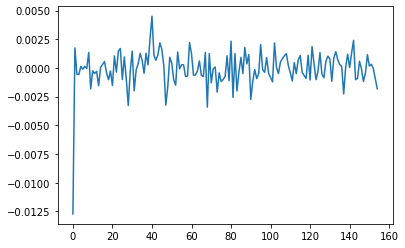

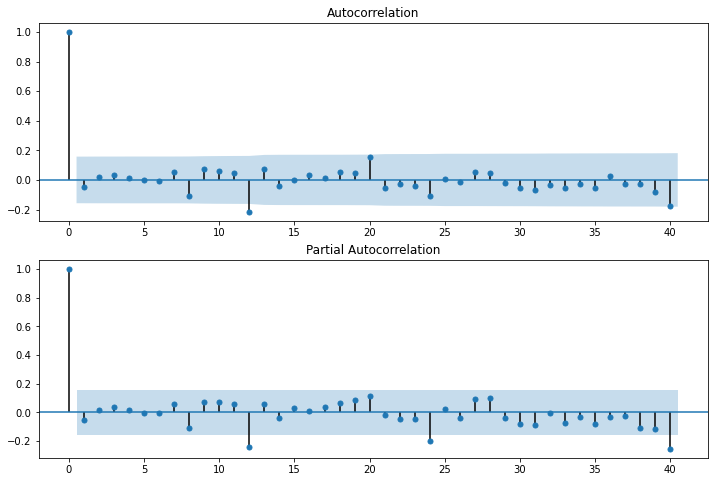

In [120]:
plt.plot(range(len(results.resid)), results.resid)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results.resid, lags=40, ax=ax2)
plt.savefig('correlation.pdf')

In [ ]:
forecast,std,conf=results.forecast(360)
prev_x = []
for i in decomp.trend:
    if not np.isnan(i):
        prev_x.append(i * (max_y - min_y) + min_y)
final_2030 = []
for i in forecast:
    final_2030.append(i * (max_y - min_y) + min_y)
time_to = len(prev_x)+len(final_2030)
now = len(prev_x)
plt.plot(range(len(prev_x)),prev_x)
plt.plot(range(now, time_to), final_2030)
plt.title('Result of the Model Trained with Drought Data')
plt.xlabel('Time Since January 2007 (Months)')
plt.ylabel('Water Elevation (ft)')
#plt.ylim([1070, 1150])
#plt.plot(forecast)
plt.savefig('result_drought.pdf')

In [84]:
res, res_std, res_conf = results.forecast(360)
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
data1 = pd.read_csv('monthlyCSV.csv', header = 0, index_col = 0)
data1 = data1.drop(range(1935, 2006))
data1 = data1.drop(2021)
npdata1 = data1.to_numpy()
g = []
for i in npdata1:
    for j in i:
        if not np.isnan(j):
            g.append(j)
min_y = min(g)
max_y = max(g)
for i in range(len(g)):
    g[i] -= min_y
    g[i] /= max_y - min_y
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(g, model = 'additive', period = 12)
trend = []
for i in decomp.trend:
    if not np.isnan(i):
        trend.append(i)
res[0] += trend[-1]
for i in range(len(res[1:])):
    res[i] += res[i-1]

In [85]:
res

array([ 1.99419219e-01,  1.87180669e-01,  1.72734641e-01,  1.56466306e-01,
        1.38692415e-01,  1.19673447e-01,  9.96236112e-02,  7.87190619e-02,
        5.71046612e-02,  3.48995372e-02,  1.22016555e-02, -1.09084211e-02,
       -3.43644415e-02, -5.81119238e-02, -8.21060643e-02, -1.06310018e-01,
       -1.30693487e-01, -1.55231553e-01, -1.79903727e-01, -2.04693157e-01,
       -2.29585987e-01, -2.54570822e-01, -2.79638289e-01, -3.04780683e-01,
       -3.29991667e-01, -3.55266028e-01, -3.80599482e-01, -4.05988503e-01,
       -4.31430193e-01, -4.56922170e-01, -4.82462472e-01, -5.08049488e-01,
       -5.33681892e-01, -5.59358594e-01, -5.85078699e-01, -6.10841468e-01,
       -6.36646296e-01, -6.62492683e-01, -6.88380221e-01, -7.14308572e-01,
       -7.40277458e-01, -7.66286652e-01, -7.92335966e-01, -8.18425246e-01,
       -8.44554365e-01, -8.70723220e-01, -8.96931723e-01, -9.23179805e-01,
       -9.49467408e-01, -9.75794483e-01, -1.00216099e+00, -1.02856690e+00,
       -1.05501219e+00, -

In [86]:
res, res_std, res_conf = results.forecast(360)
res

array([-0.00956269, -0.01223855, -0.01444603, -0.01626833, -0.01777389,
       -0.01901897, -0.02004984, -0.02090455, -0.0216144 , -0.02220512,
       -0.02269788, -0.02311008, -0.02345602, -0.02374748, -0.02399414,
       -0.02420395, -0.02438347, -0.02453807, -0.02467217, -0.02478943,
       -0.02489283, -0.02498483, -0.02506747, -0.02514239, -0.02521098,
       -0.02527436, -0.02533345, -0.02538902, -0.02544169, -0.02549198,
       -0.0255403 , -0.02558702, -0.0256324 , -0.0256767 , -0.0257201 ,
       -0.02576277, -0.02580483, -0.02584639, -0.02588754, -0.02592835,
       -0.02596889, -0.02600919, -0.02604931, -0.02608928, -0.02612912,
       -0.02616885, -0.0262085 , -0.02624808, -0.0262876 , -0.02632708,
       -0.02636651, -0.02640591, -0.02644529, -0.02648464, -0.02652397,
       -0.02656329, -0.0266026 , -0.0266419 , -0.02668119, -0.02672048,
       -0.02675975, -0.02679903, -0.0268383 , -0.02687756, -0.02691683,
       -0.02695609, -0.02699535, -0.02703461, -0.02707386, -0.02

In [ ]:
from matplotlib import pyplot
plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots(4, 1)
ax[0].plot(g)
ax[1].plot(decomp.trend)
ax[2].plot(decomp.seasonal)
ax[3].scatter(x = range(len(decomp.trend)), y= decomp.resid)
ax[0].set_ylabel('Observed', size = 15)
ax[1].set_ylabel('Trend', size = 15)
ax[2].set_ylabel('Seasonal', size = 15)
ax[3].set_ylabel('Residue', size = 15)
ax[3].set_xlabel('Time After January 1941 (Months)', size = 15)
#ax[1].tick_params(labelsize=20)
plt.savefig('decomp.pdf')

In [18]:
a = [0,1]
a.extend([2, 3])
a

[0, 1, 2, 3]

In [144]:
0.0009/0.00005

18.0